# Fintech Transaction Risk Intelligence System

## Assessment Overview
This notebook implements a comprehensive fraud detection system for financial transactions. The solution is designed to detect potentially fraudulent or high-risk financial transactions by analyzing transaction patterns, temporal trends, and other risk indicators.

Key objectives of this system:
1. Build a risk scoring model for fraud detection
2. Analyze temporal patterns in fraud occurrences
3. Implement and justify advanced feature engineering techniques
4. Handle class imbalance appropriately
5. Develop interpretable model with explainable predictions
6. Create user segmentation through unsupervised learning

## 1. Import Libraries and Dependencies


In [82]:
# # Install required packages with compatible versions
# !pip install --upgrade pip setuptools wheel
# !pip install pandas==1.5.3 numpy==1.24.3
# !pip install scikit-learn==1.2.2
# !pip install xgboost==1.7.6 lightgbm==3.3.5
# !pip install shap==0.41.0
# !pip install imbalanced-learn==0.10.1 category_encoders==2.6.1
# !pip install matplotlib==3.7.1 seaborn==0.12.2 plotly==5.15.0
# !pip install xlrd

In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report, roc_curve
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Explainability
import shap

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Saving model
import joblib
import pickle
import warnings

# Settings Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Utils
import time
import textwrap

np.random.seed(42) # Setting random seed for reproducibility

## 2. Load and Explore the Dataset


In [9]:
# Load dataset
df = pd.read_excel("../datasets/fintech_sample_fintech_transactions.xls")

print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


transaction_id customer_id  transaction_amount transaction_type  \
0       TX100703    CUST1092            5.278908           Online   
1       TX100182    CUST1021          205.156878           Online   
2       TX100221    CUST1100           77.715851              POS   
3       TX100528    CUST1099            8.440649              ATM   
4       TX100776    CUST1014           11.125070           Online   

    device_type       location time_of_day day_of_week  \
0        Mobile          Abuja   Afternoon         Fri   
1   ATM Machine          Lagos     Evening         Tue   
2  POS Terminal         Ibadan     Morning         Wed   
3  POS Terminal           Kano     Evening         Sun   
4  POS Terminal  Port Harcourt       Night         Sun   

   is_foreign_transaction  is_high_risk_country  previous_fraud_flag  \
0                       0                     1                    0   
1                       0                     0                    0   
2                       0                     1                    0   
3                       0                     0                    0   
4                       1                     0                    0   

   label_code    transaction_time  risk_score  
0           1 2024-02-04 22:00:00    0.079284  
1           0 2024-01-17 04:00:00    2.358645  
2           1 2024-01-13 15:00:00    1.794567  
3           0 2024-01-18 06:00:00    0.095569  
4           1 2024-02-05 07:00:00    0.176721

In [10]:
# Check dataset shape
print(f"Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns")

# Display data types and check for missing values
print("\nDataset Information:")
df.info()

Dataset shape: 1000 rows and 14 columns

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          1000 non-null   object        
 1   customer_id             1000 non-null   object        
 2   transaction_amount      1000 non-null   float64       
 3   transaction_type        1000 non-null   object        
 4   device_type             1000 non-null   object        
 5   location                1000 non-null   object        
 6   time_of_day             1000 non-null   object        
 7   day_of_week             1000 non-null   object        
 8   is_foreign_transaction  1000 non-null   int64         
 9   is_high_risk_country    1000 non-null   int64         
 10  previous_fraud_flag     1000 non-null   int64         
 11  label_code              1000 non-null   int64  

In [11]:
# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
df.describe()


Summary statistics for numerical columns:


transaction_amount  is_foreign_transaction  is_high_risk_country  \
count         1000.000000             1000.000000           1000.000000   
mean            72.595107                0.103000              0.057000   
min            -17.066703                0.000000              0.000000   
25%             21.041597                0.000000              0.000000   
50%             50.376081                0.000000              0.000000   
75%            102.785040                0.000000              0.000000   
max            608.378011                1.000000              1.000000   
std             73.350547                0.304111              0.231959   

       previous_fraud_flag   label_code     transaction_time   risk_score  
count          1000.000000  1000.000000                 1000  1000.000000  
mean              0.017000     0.171000  2024-01-21 19:30:00     0.749347  
min               0.000000     0.000000  2024-01-01 00:00:00    -0.285033  
25%               0.000000     0.000000  2024-01-11 09:45:00     0.201640  
50%               0.000000     0.000000  2024-01-21 19:30:00     0.493524  
75%               0.000000     0.000000  2024-02-01 05:15:00     1.038838  
max               1.000000     1.000000  2024-02-11 15:00:00     8.567216  
std               0.129336     0.376697                  NaN     0.824795

In [12]:
# Check for missing values
print("\nMissing values count per column:")
df.isnull().sum()


Missing values count per column:


transaction_id            0
customer_id               0
transaction_amount        0
transaction_type          0
device_type               0
location                  0
time_of_day               0
day_of_week               0
is_foreign_transaction    0
is_high_risk_country      0
previous_fraud_flag       0
label_code                0
transaction_time          0
risk_score                0
dtype: int64


Distribution of the target variable (label_code):
label_code
0    829
1    171
Name: count, dtype: int64

Percentage distribution:
label_code
0    82.9
1    17.1
Name: proportion, dtype: float64


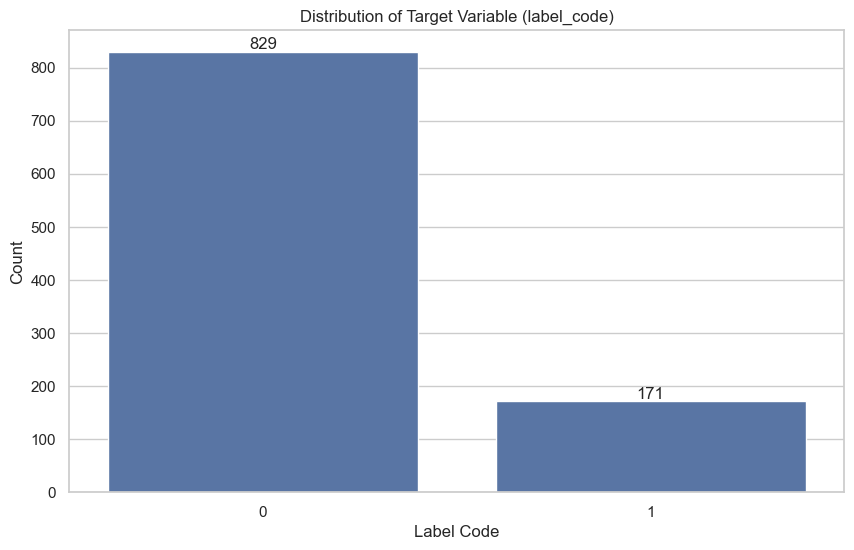


Class imbalance ratio (majority:minority): 4.85:1


In [13]:
# Distribution of the target variable (label_code)
print("\nDistribution of the target variable (label_code):")
label_counts = df['label_code'].value_counts(normalize=True) * 100
print(df['label_code'].value_counts())
print(f"\nPercentage distribution:\n{label_counts}")

# Visualize distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='label_code')
plt.title('Distribution of Target Variable (label_code)')
plt.xlabel('Label Code')
plt.ylabel('Count')

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
    
plt.show()

# Class imbalance check
imbalance_ratio = df['label_code'].value_counts().iloc[0] / df['label_code'].value_counts().iloc[-1]
print(f"\nClass imbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")

## 3. Data Preprocessing and Cleaning

In [14]:
# Check data types
print("Column data types:")
print(df.dtypes)

# Make copy of the dataframe to work with
df_cleaned = df.copy()

# Check transaction_time is already a datetime type or needs conversion
if not pd.api.types.is_datetime64_any_dtype(df_cleaned['transaction_time']):
    print("\nConverting transaction_time to datetime...")
    try:
        # Try to convert to datetime format
        df_cleaned['transaction_time'] = pd.to_datetime(df_cleaned['transaction_time'])
        print("Conversion successful!")
    except Exception as e:
        print(f"Error converting to datetime: {e}")
        # If conversion fails, check format
        print("Sample transaction_time values:")
        print(df_cleaned['transaction_time'].head())

# Display datatypes after conversion
print("\nUpdated data types:")
print(df_cleaned.dtypes)

Column data types:
transaction_id                    object
customer_id                       object
transaction_amount               float64
transaction_type                  object
device_type                       object
location                          object
time_of_day                       object
day_of_week                       object
is_foreign_transaction             int64
is_high_risk_country               int64
previous_fraud_flag                int64
label_code                         int64
transaction_time          datetime64[ns]
risk_score                       float64
dtype: object

Updated data types:
transaction_id                    object
customer_id                       object
transaction_amount               float64
transaction_type                  object
device_type                       object
location                          object
time_of_day                       object
day_of_week                       object
is_foreign_transaction             int64
is_

In [15]:
# Handle missing values
# Check percentage of missing values in each column
missing_percent = df_cleaned.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percent[missing_percent > 0])

# Strategy for handling missing values:
# 1. For numerical columns: impute with median
# 2. For categorical columns: impute with mode

# Identify numerical and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Handle missing values based on column type
for col in numerical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        # Impute with median
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median: {median_val}")

for col in categorical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        # Impute with mode
        mode_val = df_cleaned[col].mode()[0]
        df_cleaned[col] = df_cleaned[col].fillna(mode_val)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")

# Verify no missing values remain
print("\nMissing values after imputation:")
print(df_cleaned.isnull().sum().sum())

Percentage of missing values in each column:
Series([], dtype: float64)

Missing values after imputation:
0


Number of duplicate rows: 0

Checking for outliers in numerical features...
Column 'transaction_amount' has 43 outliers (4.30%)


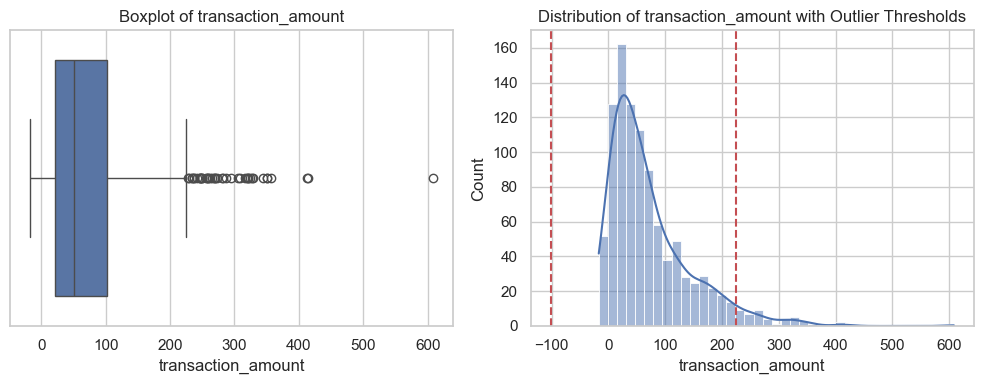

Column 'is_foreign_transaction' has 103 outliers (10.30%)


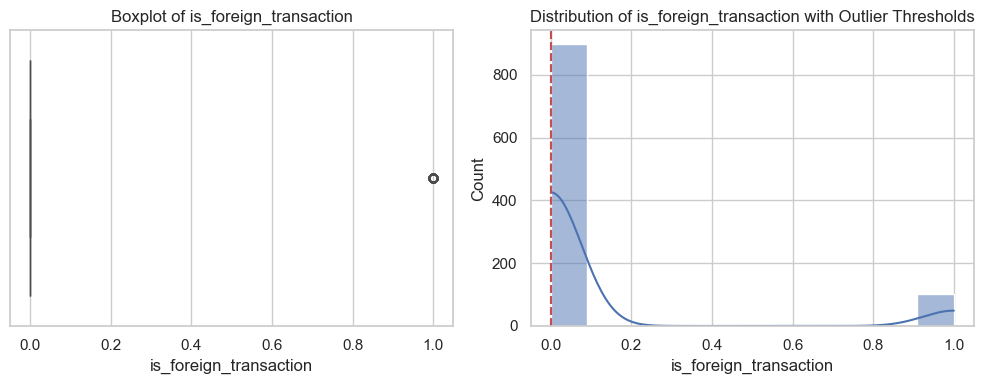

Column 'is_high_risk_country' has 57 outliers (5.70%)


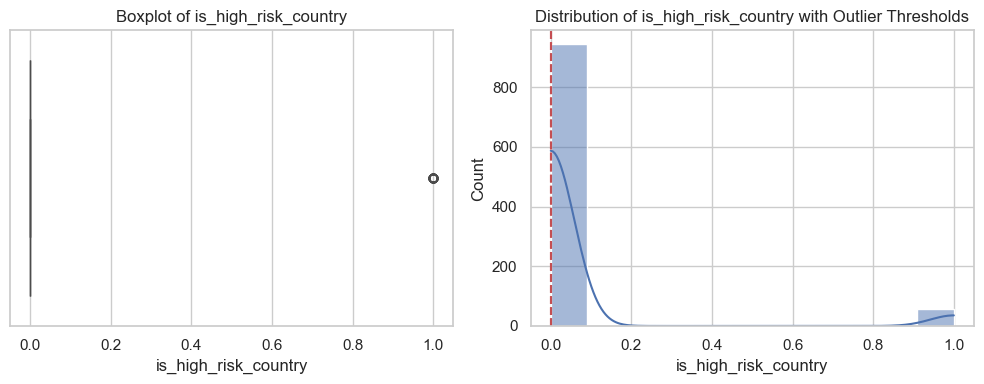

Column 'previous_fraud_flag' has 17 outliers (1.70%)


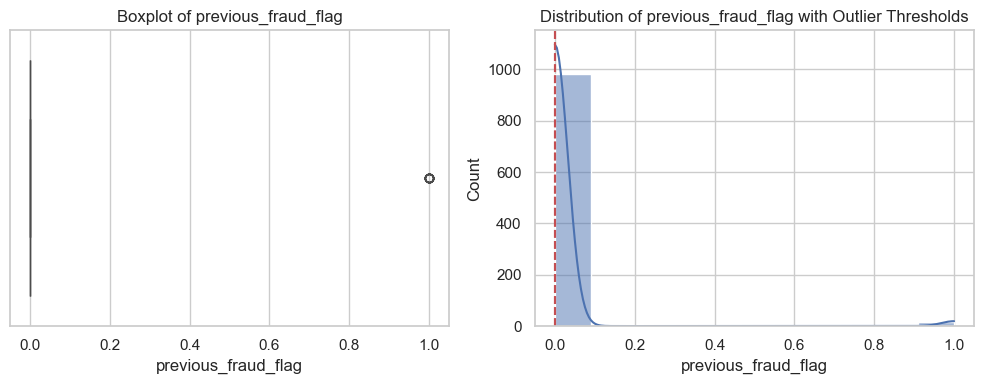

Column 'risk_score' has 60 outliers (6.00%)


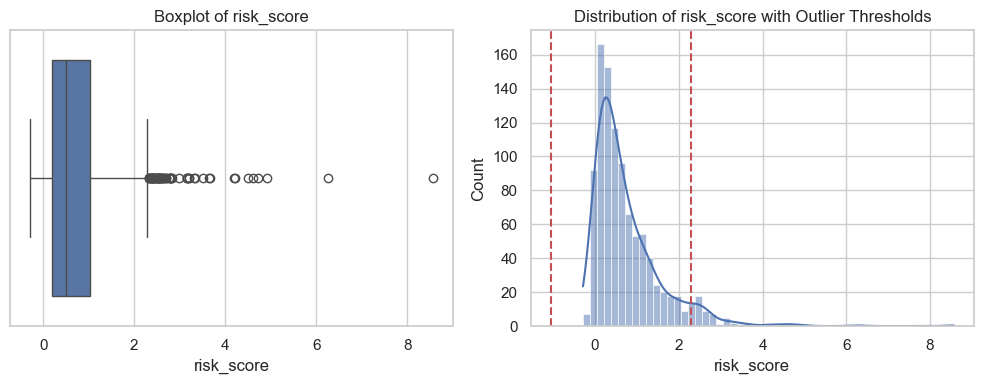

In [17]:
# Check for duplicate transactions
duplicate_count = df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Dropped {duplicate_count} duplicate rows. New shape: {df_cleaned.shape}")

# Check for outliers in numerical columns (using IQR method)
print("\nChecking for outliers in numerical features...")

for col in numerical_cols:
    if col != 'label_code':  # Skip target variable
        # Calculate IQR
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percent = (outlier_count / len(df_cleaned)) * 100
        
        # Only report if outlier percentage is significant
        if outlier_percent > 1:
            print(f"Column '{col}' has {outlier_count} outliers ({outlier_percent:.2f}%)")
            
            # Visualize the distribution with outliers
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            sns.boxplot(x=df_cleaned[col])
            plt.title(f'Boxplot of {col}')
            
            plt.subplot(1, 2, 2)
            sns.histplot(df_cleaned[col], kde=True)
            plt.axvline(x=lower_bound, color='r', linestyle='--')
            plt.axvline(x=upper_bound, color='r', linestyle='--')
            plt.title(f'Distribution of {col} with Outlier Thresholds')
            plt.tight_layout()
            plt.show()

**Note:** Outliers were identified but not removed as they might be indicative of fraudulent activity and may be important for fraud detection. However, we might want to cap extreme values for modeling stability

In [23]:
# Check columns in df_cleaned
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Columns in df_cleaned:
['transaction_id', 'customer_id', 'transaction_amount', 'transaction_type', 'device_type', 'location', 'time_of_day', 'day_of_week', 'is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag', 'label_code', 'transaction_time', 'risk_score']


## 4. Exploratory Data Analysis (EDA)

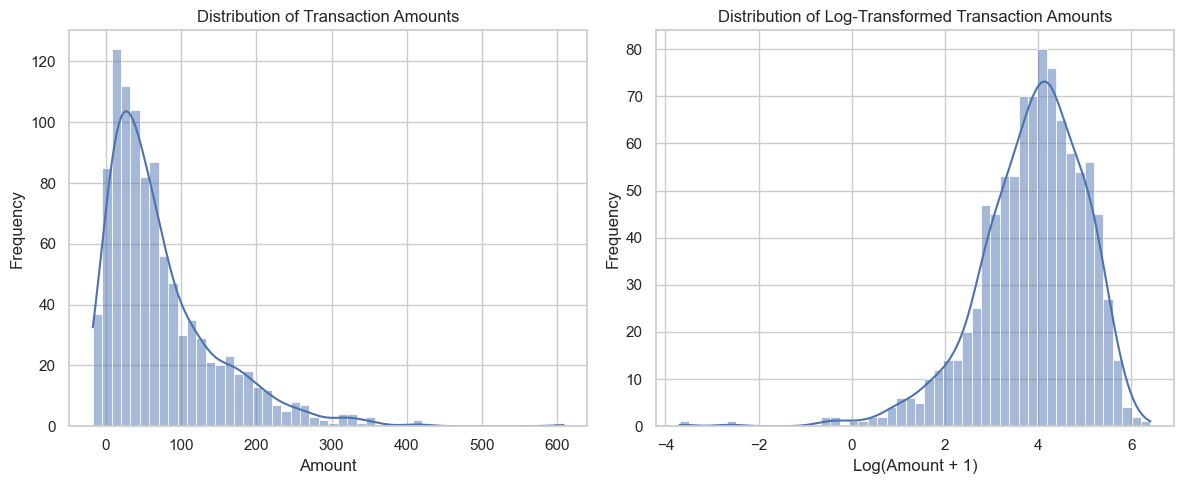

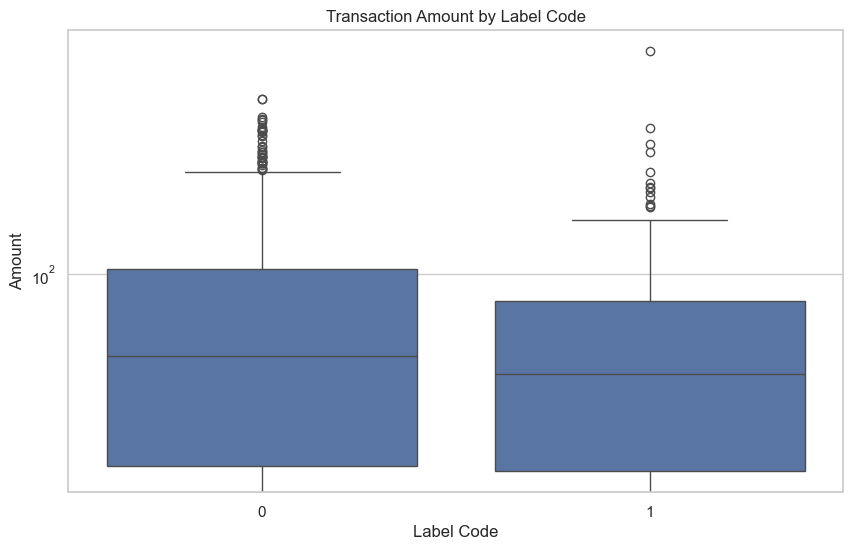

In [22]:
# Analyze distribution of key features
# Examining the distribution of transaction amounts
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['transaction_amount'], kde=True, bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Log transform for better visualization if amounts are skewed
sns.histplot(np.log1p(df_cleaned['transaction_amount']), kde=True, bins=50)
plt.title('Distribution of Log-Transformed Transaction Amounts')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check relationship between transaction amount and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='label_code', y='transaction_amount', data=df_cleaned)
plt.title('Transaction Amount by Label Code')
plt.xlabel('Label Code')
plt.ylabel('Amount')
plt.yscale('log')  # Log scale for better visualization
plt.show()

# # If 'label_code' has many unique values, creating a binary fraud indicator for simpler analysis
# if df_cleaned['label_code'].nunique() > 5:
#     # For simplicity in EDA, the highest label code is considered as fraudulent
#     fraud_threshold = df_cleaned['label_code'].median()
#     df_cleaned['is_high_risk'] = (df_cleaned['label_code'] > fraud_threshold).astype(int)
    
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='is_high_risk', y='transaction_amount', data=df_cleaned)
#     plt.title('Transaction Amount by Risk Level')
#     plt.xlabel('Is High Risk (1 = Yes, 0 = No)')
#     plt.ylabel('Amount')
#     plt.yscale('log')  # Log scale for better visualization
#     plt.show()

In [24]:
# Get statistical information about transaction amounts
print("Overall transaction amount statistics:")
print(df_cleaned['transaction_amount'].describe())

print("\nTransaction amount statistics by fraud label:")
print(df_cleaned.groupby('label_code')['transaction_amount'].describe())

Overall transaction amount statistics:
count    1000.000000
mean       72.595107
std        73.350547
min       -17.066703
25%        21.041597
50%        50.376081
75%       102.785040
max       608.378011
Name: transaction_amount, dtype: float64

Transaction amount statistics by fraud label:
            count      mean        std        min        25%        50%  \
label_code                                                                
0           829.0  74.14185  73.329636 -17.066703  21.272949  51.824305   
1           171.0  65.09657  73.202904 -16.080764  20.312805  44.508430   

                   75%         max  
label_code                          
0           104.661568  413.647461  
1            80.770823  608.378011  


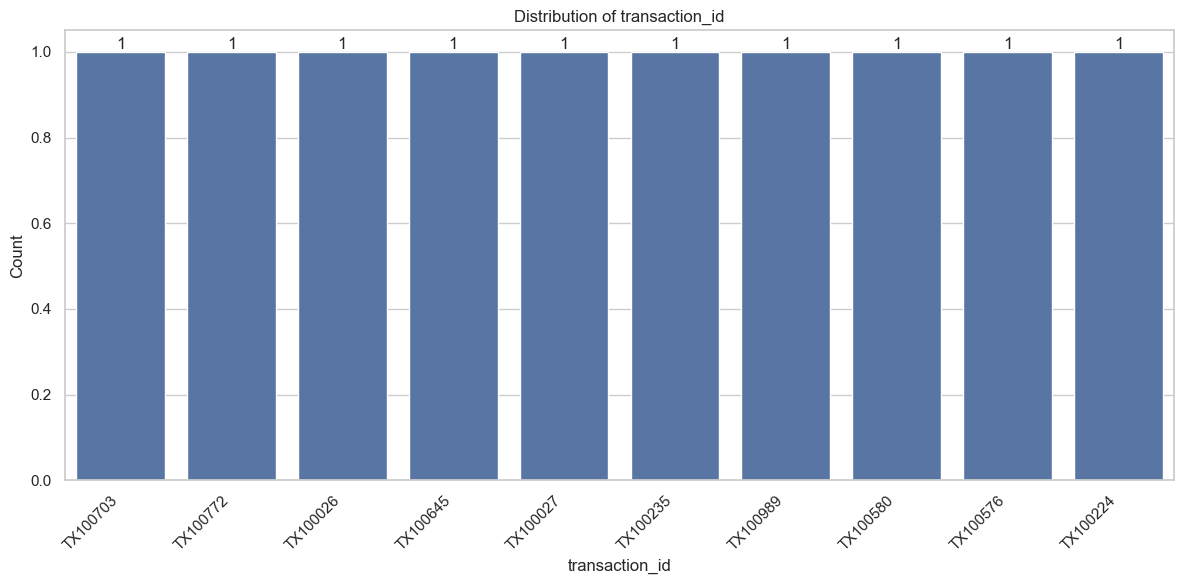

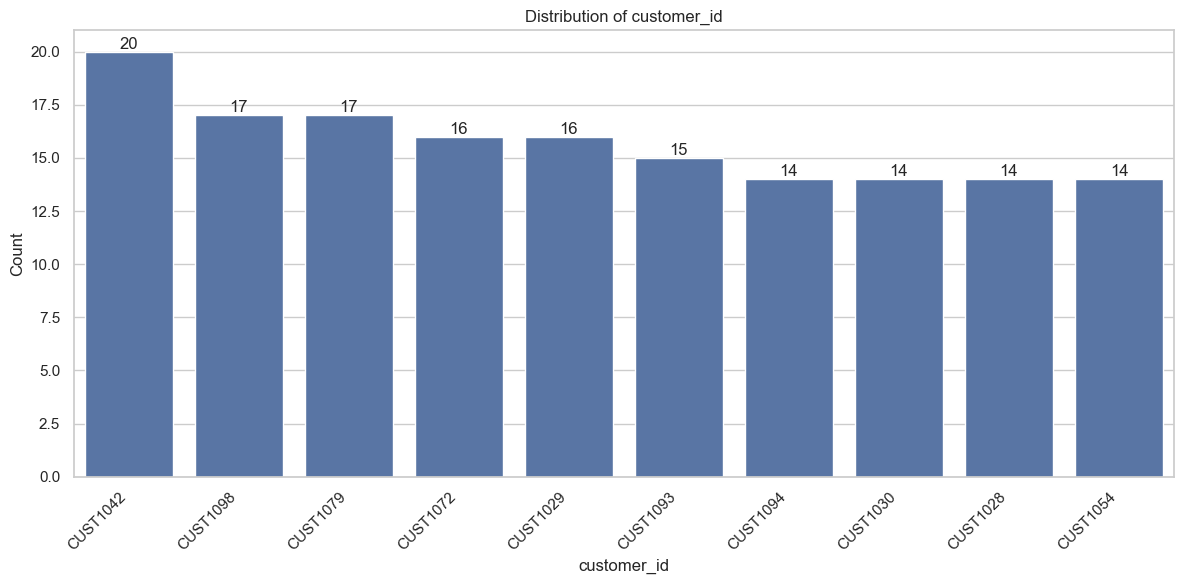

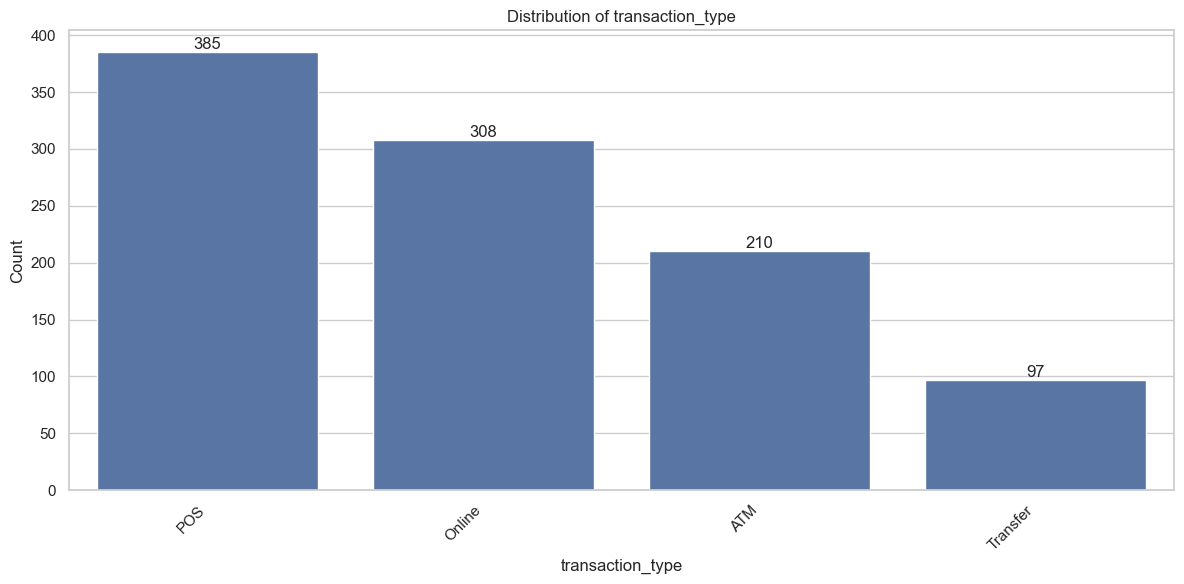

<Figure size 1200x600 with 0 Axes>

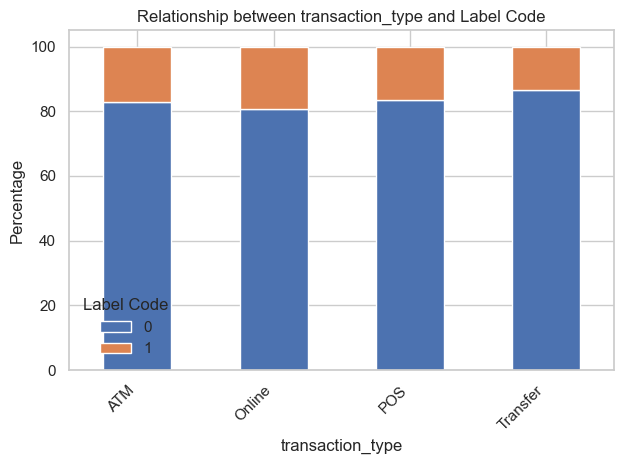

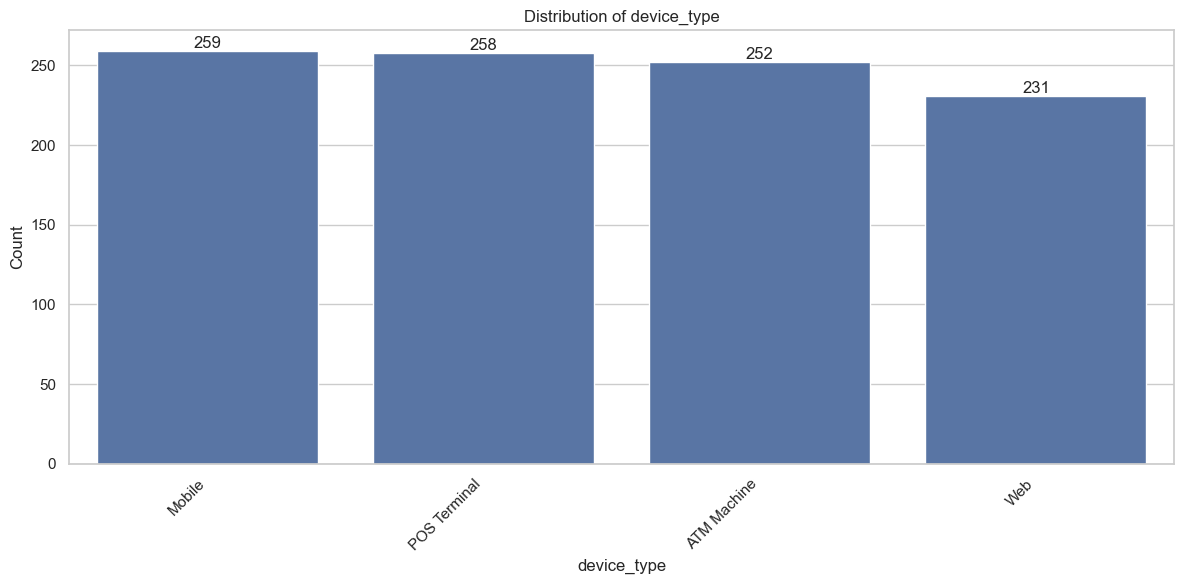

<Figure size 1200x600 with 0 Axes>

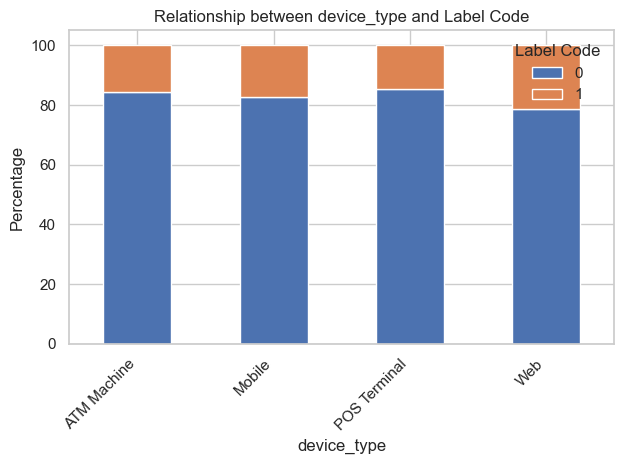

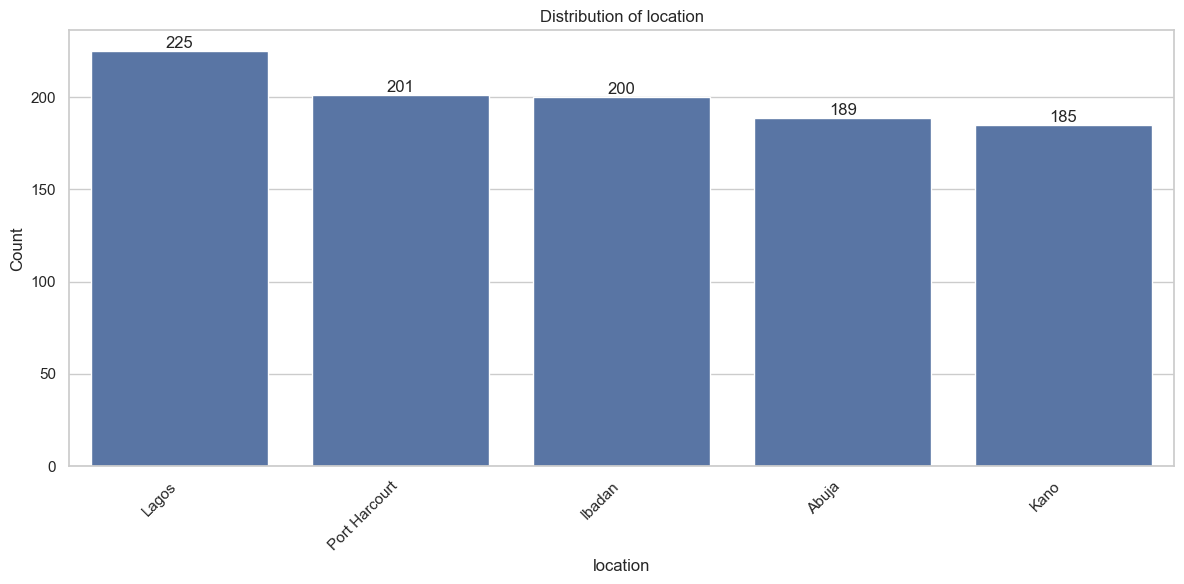

<Figure size 1200x600 with 0 Axes>

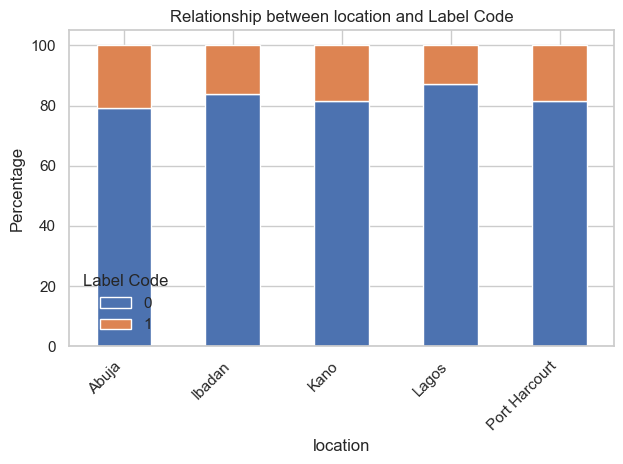

In [65]:
# Explore categorical features
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Plot distribution of categorical features
for col in categorical_cols[:5]:  # Limiting to first 5 categorical columns for brevity
    plt.figure(figsize=(12, 6))
    
    # Get value counts and limiting to top 10 categories
    value_counts = df_cleaned[col].value_counts().head(10)
    
    # Bar plot
    ax = sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Check any association with the target
    if df_cleaned[col].nunique() <= 10:  # Only for columns with reasonable number of categories
        plt.figure(figsize=(12, 6))
        cross_tab = pd.crosstab(df_cleaned[col], df_cleaned['label_code'], normalize='index') * 100
        cross_tab.plot(kind='bar', stacked=True)
        plt.title(f'Relationship between {col} and Label Code')
        plt.xlabel(col)
        plt.ylabel('Percentage')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Label Code')
        plt.tight_layout()
        plt.show()

**Customer Fraud Analysis**

Examine patterns of fraud at the customer level to identify potential anomalies:
- Identify top customers with the highest number of fraudulent transactions
- Calculate the fraud rate (percentage of fraudulent transactions) for each customer
- Visualize distributions of fraud across customers
- Identify potential patterns or anomalies related to customer-level fraud

In [68]:
# Check to 20 customer ids with fraudulent transactions and their respective number of fraud transaction counts
df_fraudulent = df_cleaned[df_cleaned['label_code'] == 1]
fraudulent_customers = df_fraudulent['customer_id'].unique()[:20]
print("Sample of 20 customer IDs with fraudulent transactions:")
print(fraudulent_customers)

Sample of 20 customer IDs with fraudulent transactions:
['CUST1092' 'CUST1100' 'CUST1014' 'CUST1052' 'CUST1017' 'CUST1091'
 'CUST1087' 'CUST1012' 'CUST1019' 'CUST1076' 'CUST1068' 'CUST1083'
 'CUST1041' 'CUST1030' 'CUST1098' 'CUST1072' 'CUST1046' 'CUST1015'
 'CUST1007' 'CUST1033']
Number of fraudulent transactions for each customer:
customer_id
CUST1092    4
CUST1100    1
CUST1014    2
CUST1052    2
CUST1017    3
CUST1091    2
CUST1087    2
CUST1012    5
CUST1019    2
CUST1076    2
CUST1068    1
CUST1083    3
CUST1041    2
CUST1030    3
CUST1098    4
CUST1072    3
CUST1046    3
CUST1015    2
CUST1007    3
CUST1033    5
Name: count, dtype: int64


Analyzing fraud patterns at the customer level...
Total fraudulent transactions: 171
Total customers with at least one fraudulent transaction: 83
Average fraudulent transactions per affected customer: 2.06

Top 10 customers with the most fraudulent transactions:
customer_id
CUST1033    5
CUST1006    5
CUST1012    5
CUST1092    4
CUST1062    4
CUST1070    4
CUST1008    4
CUST1098    4
CUST1000    4
CUST1035    3
Name: count, dtype: int64

Top 10 customers by fraud count with their fraud percentages:
   customer_id  total_transactions  fraudulent_transactions  fraud_percentage
79    CUST1033                   8                        5         62.500000
15    CUST1012                  13                        5         38.461538
10    CUST1006                  14                        5         35.714286
35    CUST1070                  11                        4         36.363636
19    CUST1062                  13                        4         30.769231
1     CUST1098              

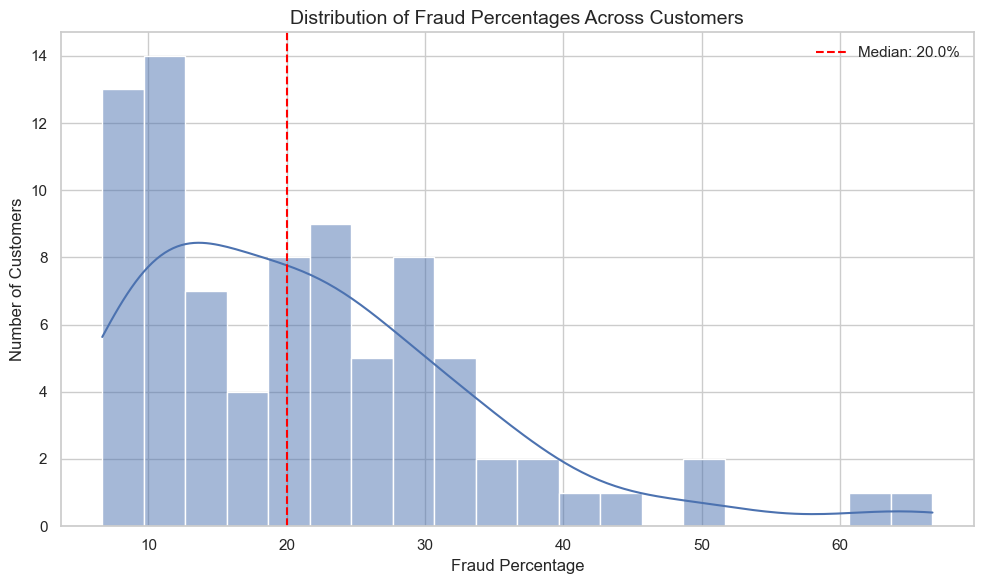

<Figure size 1200x700 with 0 Axes>

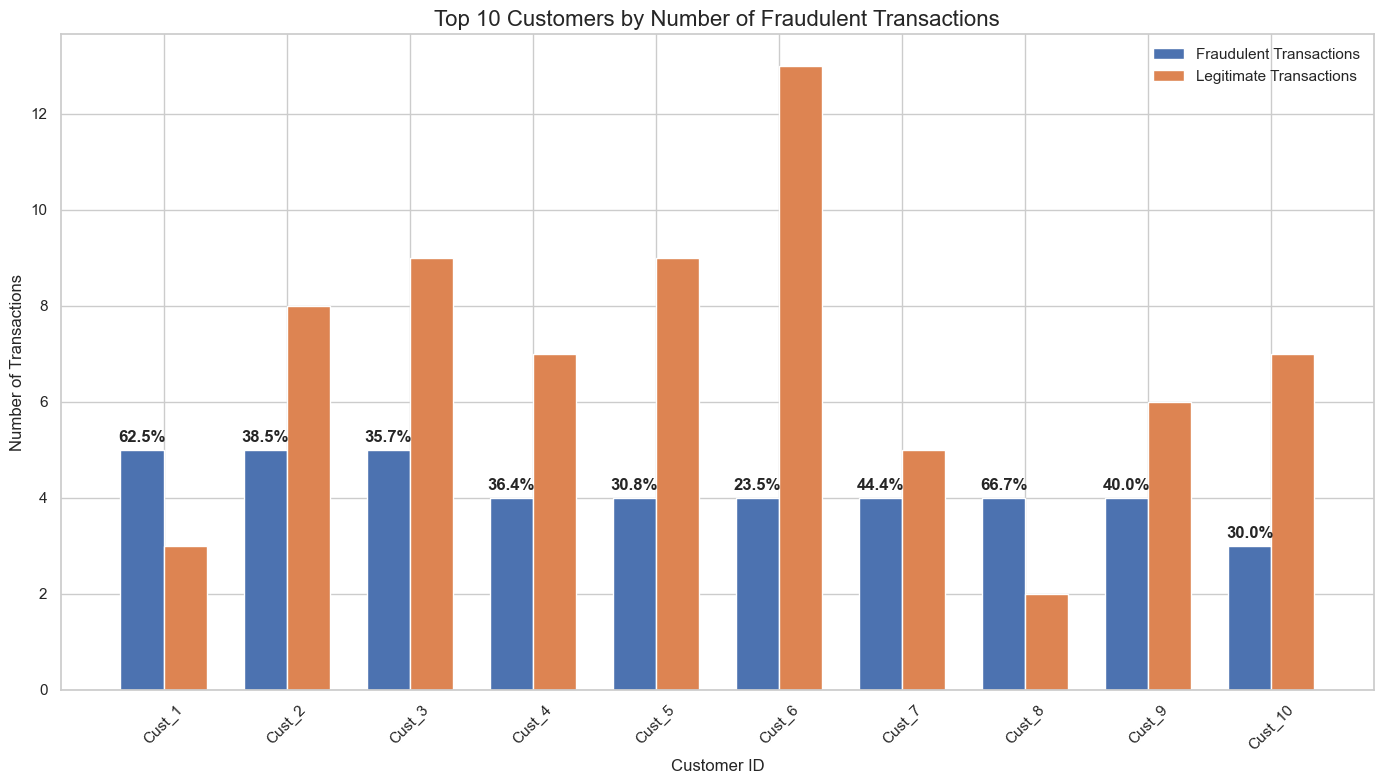

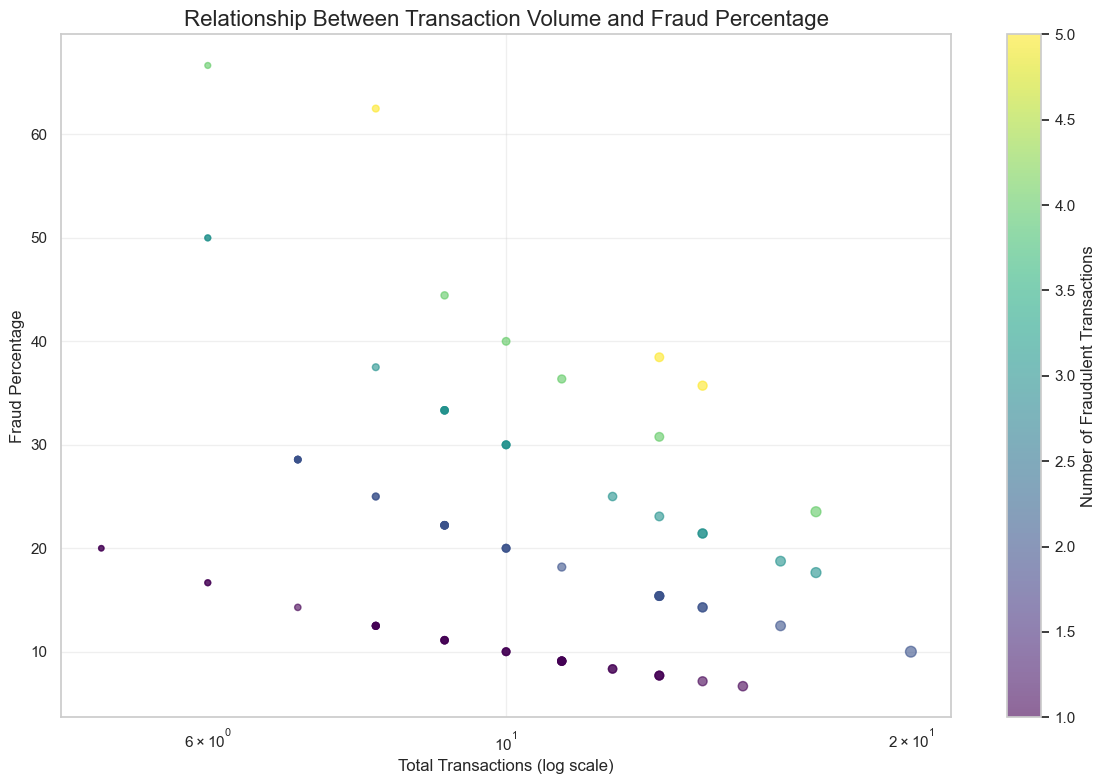


Fraud concentration analysis:
Top 1% of customers (1 customers) account for 2.92% of all fraud
Top 5% of customers (4 customers) account for 11.11% of all fraud
Top 10% of customers (8 customers) account for 20.47% of all fraud


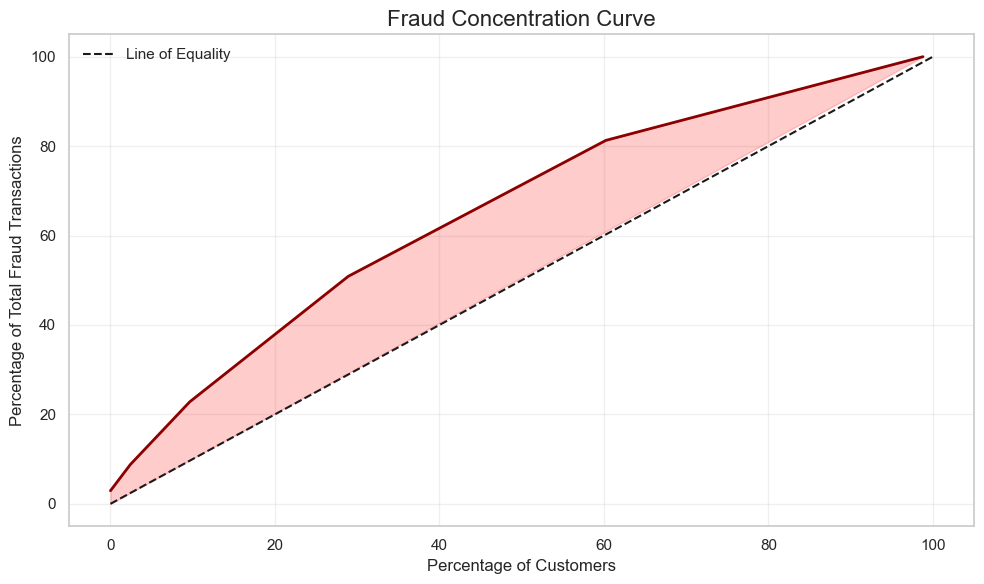

In [70]:
# Comprehensive Customer Fraud Analysis

print("Analyzing fraud patterns at the customer level...")

# 1. Identify customers with fraudulent transactions
df_fraudulent = df_cleaned[df_cleaned['label_code'] == 1]
total_fraud_transactions = len(df_fraudulent)
total_fraud_customers = df_fraudulent['customer_id'].nunique()

print(f"Total fraudulent transactions: {total_fraud_transactions}")
print(f"Total customers with at least one fraudulent transaction: {total_fraud_customers}")
print(f"Average fraudulent transactions per affected customer: {total_fraud_transactions / total_fraud_customers:.2f}")

# 2. Count fraudulent transactions per customer
fraudulent_counts = df_fraudulent['customer_id'].value_counts()
print(f"\nTop 10 customers with the most fraudulent transactions:")
top_10_fraud_customers = fraudulent_counts.head(10)
print(top_10_fraud_customers)

# 3. Calculate fraud rate for each customer
# First, get total transactions per customer
total_customer_transactions = df_cleaned['customer_id'].value_counts()

# Create a DataFrame to analyze customer fraud patterns
customer_fraud_analysis = pd.DataFrame({
    'customer_id': total_customer_transactions.index,
    'total_transactions': total_customer_transactions.values,
    'fraudulent_transactions': [fraudulent_counts.get(customer_id, 0) for customer_id in total_customer_transactions.index]
})

# Calculate fraud percentage for each customer
customer_fraud_analysis['fraud_percentage'] = (customer_fraud_analysis['fraudulent_transactions'] / 
                                             customer_fraud_analysis['total_transactions'] * 100)

# Sort by number of fraudulent transactions in descending order
customer_fraud_analysis = customer_fraud_analysis.sort_values('fraudulent_transactions', ascending=False)

# Display top 10 customers by fraud count with their fraud percentages
print("\nTop 10 customers by fraud count with their fraud percentages:")
top_10_customers = customer_fraud_analysis.head(10)
print(top_10_customers)

# 4. Identify customers with 100% fraud rate (all transactions are fraudulent)
all_fraud_customers = customer_fraud_analysis[customer_fraud_analysis['fraud_percentage'] == 100]
print(f"\nCustomers with 100% fraud rate (all transactions are fraudulent): {len(all_fraud_customers)}")
if len(all_fraud_customers) > 0:
    print("Top 5 customers with 100% fraud rate (by transaction count):")
    print(all_fraud_customers.sort_values('total_transactions', ascending=False).head(5))

# 5. VISUALIZATION: Distribution of fraud percentages across customers
plt.figure(figsize=(10, 6))
# Only include customers with at least one fraudulent transaction for this visualization
customers_with_fraud = customer_fraud_analysis[customer_fraud_analysis['fraudulent_transactions'] > 0]
sns.histplot(customers_with_fraud['fraud_percentage'], bins=20, kde=True)
plt.title('Distribution of Fraud Percentages Across Customers', fontsize=14)
plt.xlabel('Fraud Percentage', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.axvline(customers_with_fraud['fraud_percentage'].median(), color='red', linestyle='--', 
            label=f'Median: {customers_with_fraud["fraud_percentage"].median():.1f}%')
plt.legend()
plt.tight_layout()
plt.show()

# 6. VISUALIZATION: Top 10 customers by fraud count
plt.figure(figsize=(12, 7))
top_10 = customer_fraud_analysis.head(10)
x = np.arange(len(top_10))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, top_10['fraudulent_transactions'], width, label='Fraudulent Transactions')
bars2 = ax.bar(x + width/2, top_10['total_transactions'] - top_10['fraudulent_transactions'], width, 
               label='Legitimate Transactions')

# Add fraud percentage as text labels
for i, bar in enumerate(bars1):
    fraud_pct = top_10['fraud_percentage'].iloc[i]
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{fraud_pct:.1f}%', ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Customer ID', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_title('Top 10 Customers by Number of Fraudulent Transactions', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f"Cust_{i+1}" for i in range(len(top_10))], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

# 7. VISUALIZATION: Relationship between total transactions and fraud percentage
plt.figure(figsize=(12, 8))
# Only include customers with at least 5 total transactions for meaningful percentages
significant_customers = customer_fraud_analysis[customer_fraud_analysis['total_transactions'] >= 5]
# Only include customers with at least one fraud transaction
fraud_customers = significant_customers[significant_customers['fraudulent_transactions'] > 0]

# Create scatter plot with point size based on total transactions
plt.scatter(fraud_customers['total_transactions'], 
            fraud_customers['fraud_percentage'],
            alpha=0.6, 
            s=fraud_customers['total_transactions']*3, # Size points by transaction count
            c=fraud_customers['fraudulent_transactions'], # Color by fraud count
            cmap='viridis')

plt.colorbar(label='Number of Fraudulent Transactions')
plt.xscale('log')  # Log scale for better visualization if there are outliers
plt.title('Relationship Between Transaction Volume and Fraud Percentage', fontsize=16)
plt.xlabel('Total Transactions (log scale)', fontsize=12)
plt.ylabel('Fraud Percentage', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Fraud concentration analysis - what percentage of fraud is committed by top customers?
customer_fraud_analysis_sorted = customer_fraud_analysis.sort_values('fraudulent_transactions', ascending=False)
customer_fraud_analysis_sorted['cumulative_fraud'] = customer_fraud_analysis_sorted['fraudulent_transactions'].cumsum()
customer_fraud_analysis_sorted['cumulative_fraud_percentage'] = (customer_fraud_analysis_sorted['cumulative_fraud'] / 
                                                               total_fraud_transactions * 100)

# Check what percentage of total fraud is committed by top 1%, 5%, 10% of customers
total_customers_with_fraud = len(customer_fraud_analysis_sorted[customer_fraud_analysis_sorted['fraudulent_transactions'] > 0])
top_1_percent = int(total_customers_with_fraud * 0.01) if int(total_customers_with_fraud * 0.01) > 0 else 1
top_5_percent = int(total_customers_with_fraud * 0.05) if int(total_customers_with_fraud * 0.05) > 0 else 1
top_10_percent = int(total_customers_with_fraud * 0.10) if int(total_customers_with_fraud * 0.10) > 0 else 1

print("\nFraud concentration analysis:")
print(f"Top 1% of customers ({top_1_percent} customers) account for {customer_fraud_analysis_sorted['cumulative_fraud_percentage'].iloc[top_1_percent-1]:.2f}% of all fraud")
print(f"Top 5% of customers ({top_5_percent} customers) account for {customer_fraud_analysis_sorted['cumulative_fraud_percentage'].iloc[top_5_percent-1]:.2f}% of all fraud")
print(f"Top 10% of customers ({top_10_percent} customers) account for {customer_fraud_analysis_sorted['cumulative_fraud_percentage'].iloc[top_10_percent-1]:.2f}% of all fraud")

# 9. VISUALIZATION: Fraud concentration curve (similar to Lorenz curve)
plt.figure(figsize=(10, 6))
customer_percentiles = np.arange(len(customer_fraud_analysis_sorted[customer_fraud_analysis_sorted['fraudulent_transactions'] > 0])) / total_customers_with_fraud * 100

# Only plot for customers with at least one fraudulent transaction
fraudulent_customer_data = customer_fraud_analysis_sorted[customer_fraud_analysis_sorted['fraudulent_transactions'] > 0]
plt.plot(customer_percentiles, fraudulent_customer_data['cumulative_fraud_percentage'], 
         linewidth=2, color='darkred')
plt.plot([0, 100], [0, 100], 'k--', label='Line of Equality')
plt.fill_between(customer_percentiles, fraudulent_customer_data['cumulative_fraud_percentage'], 
                 np.linspace(0, 100, len(fraudulent_customer_data)), alpha=0.2, color='red')

plt.title('Fraud Concentration Curve', fontsize=16)
plt.xlabel('Percentage of Customers', fontsize=12)
plt.ylabel('Percentage of Total Fraud Transactions', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Store analysis results for potential feature engineering
# We might want to create features based on customer fraud history
customer_fraud_profiles = customer_fraud_analysis.set_index('customer_id')

**Fraud Analysis by Transaction Type**

Examining patterns of fraud across different transaction types to identify which transaction categories are most susceptible to fraud.

Analyzing fraud patterns by transaction type...

Fraud statistics by transaction type:
  transaction_type  total_transactions  fraud_transactions  \
1           Online                 308                  59   
0              ATM                 210                  36   
2              POS                 385                  63   
3         Transfer                  97                  13   

   legitimate_transactions  fraud_percentage  
1                      249         19.155844  
0                      174         17.142857  
2                      322         16.363636  
3                       84         13.402062  


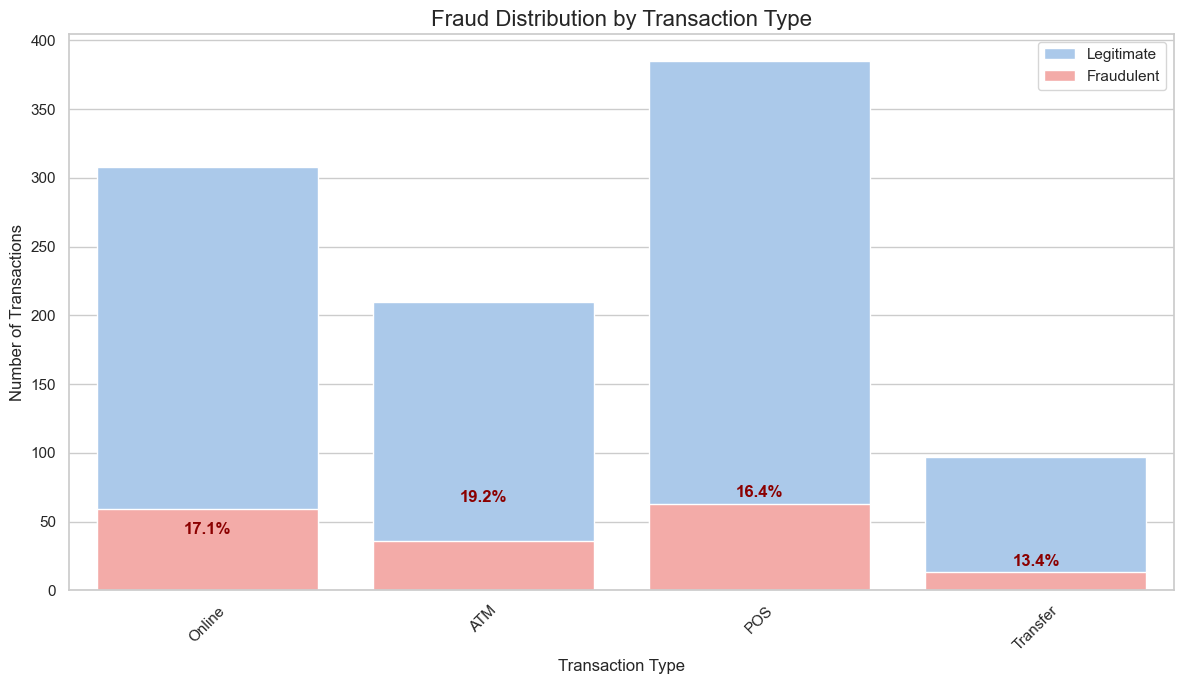

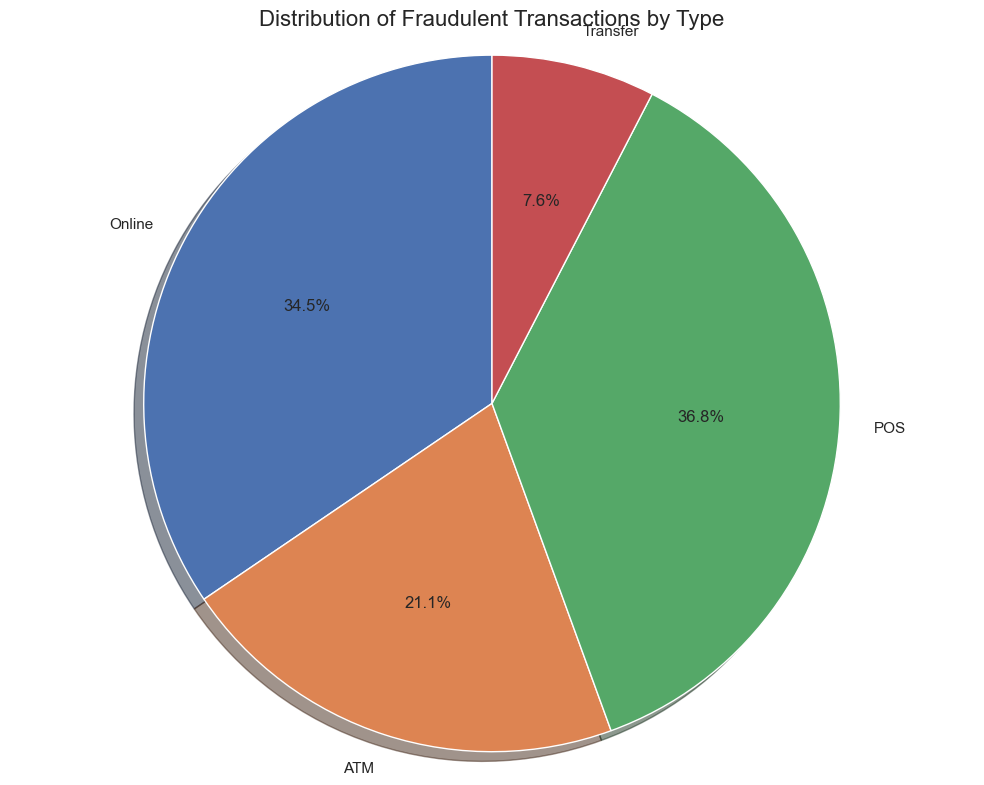

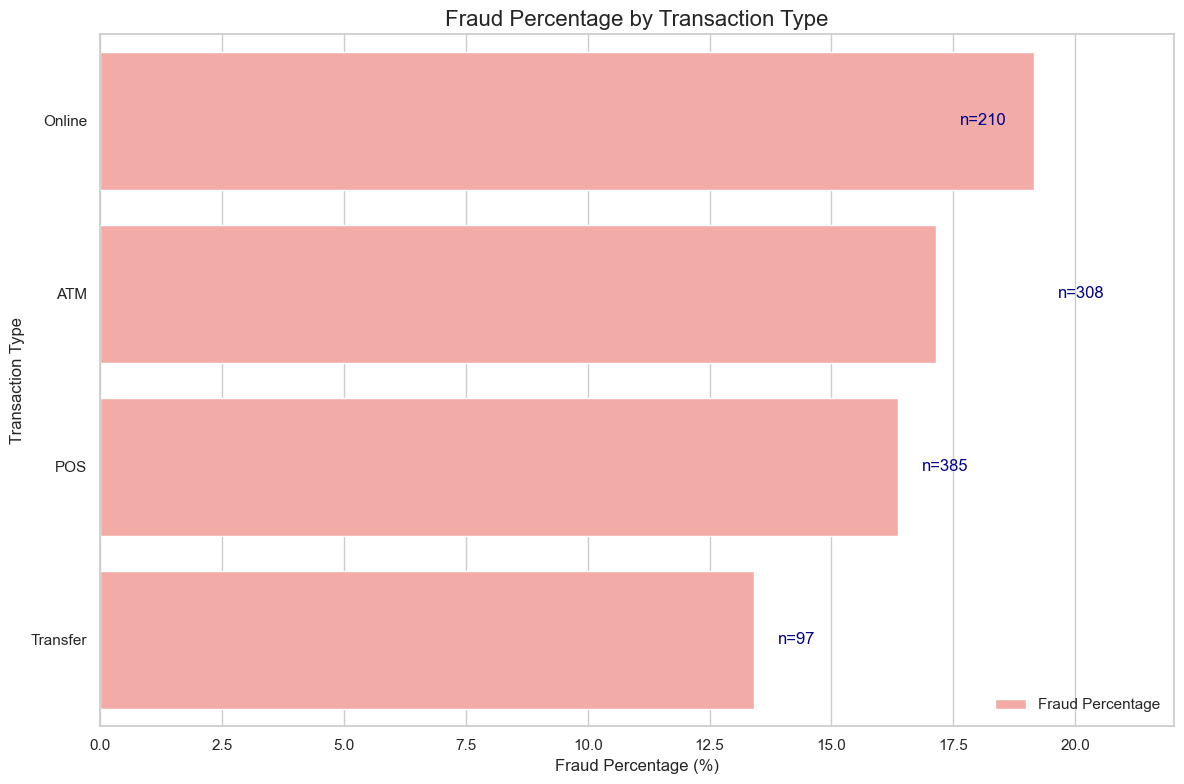


Overall fraud rate across all transactions: 17.10%

Risk ratio by transaction type (ratio of type's fraud rate to overall fraud rate):
  transaction_type  fraud_percentage  risk_ratio
1           Online         19.155844    1.120225
0              ATM         17.142857    1.002506
2              POS         16.363636    0.956938
3         Transfer         13.402062    0.783746


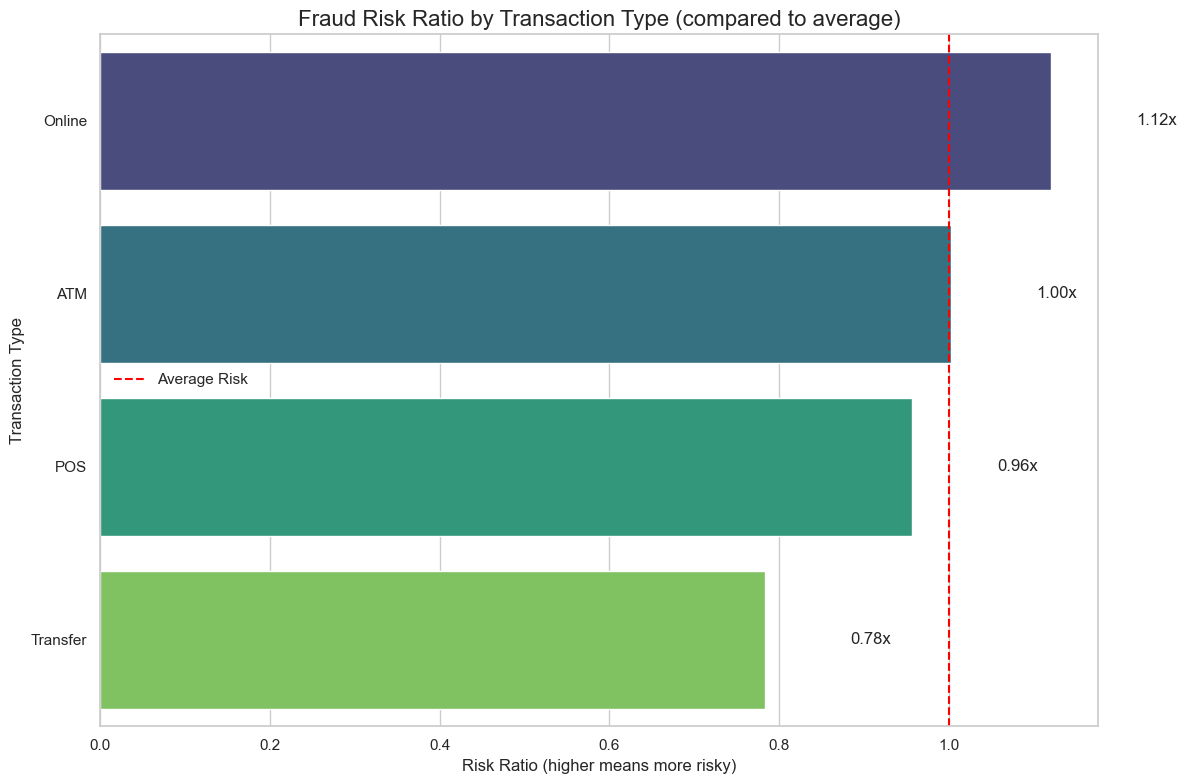

In [74]:
# Analysis of fraud patterns by transaction type
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Analyzing fraud patterns by transaction type...")

# Check if transaction_type column exists in the dataframe
if 'transaction_type' not in df_cleaned.columns:
    print("transaction_type column not found in the dataframe")
else:
    # 1. Calculate overall fraud statistics by transaction type
    # Fixed: Using a dictionary format for aggregation instead of named arguments
    transaction_type_stats = df_cleaned.groupby('transaction_type').agg({
        'transaction_id': 'count',
        'label_code': ['sum', lambda x: (x == 0).sum()]
    })
    
    # Flatten the multi-level columns
    transaction_type_stats.columns = ['total_transactions', 'fraud_transactions', 'legitimate_transactions']
    transaction_type_stats = transaction_type_stats.reset_index()
    
    # Calculate fraud percentage
    transaction_type_stats['fraud_percentage'] = (transaction_type_stats['fraud_transactions'] / 
                                                transaction_type_stats['total_transactions'] * 100)
    
    # Sort by fraud percentage in descending order
    transaction_type_stats = transaction_type_stats.sort_values('fraud_percentage', ascending=False)
    
    print("\nFraud statistics by transaction type:")
    print(transaction_type_stats)
    
    # 2. VISUALIZATION: Bar chart showing fraud percentage by transaction type
    plt.figure(figsize=(12, 7))
    sns.set_color_codes("pastel")
    
    # Plot the total transactions
    plot = sns.barplot(x="transaction_type", y="total_transactions", 
                       data=transaction_type_stats, color="b", label="Legitimate")
    
    # Plot the fraud transactions
    sns.barplot(x="transaction_type", y="fraud_transactions", 
                data=transaction_type_stats, color="r", label="Fraudulent")
    
    # Add labels for fraud percentages
    for i, row in transaction_type_stats.iterrows():
        plot.text(i, row['fraud_transactions'] + 5, 
                 f"{row['fraud_percentage']:.1f}%", 
                 ha='center', color='darkred', fontweight='bold')
    
    # Customize the plot
    plot.set_title("Fraud Distribution by Transaction Type", fontsize=16)
    plot.set_xlabel("Transaction Type", fontsize=12)
    plot.set_ylabel("Number of Transactions", fontsize=12)
    plt.legend(loc="upper right", frameon=True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. VISUALIZATION: Pie chart for fraud distribution across transaction types
    plt.figure(figsize=(10, 8))
    
    # Create a pie chart showing the distribution of fraudulent transactions by type
    fraud_distribution = transaction_type_stats['fraud_transactions']
    plt.pie(fraud_distribution, labels=transaction_type_stats['transaction_type'], 
            autopct='%1.1f%%', startangle=90, shadow=True)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Distribution of Fraudulent Transactions by Type', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 4. VISUALIZATION: Horizontal bar chart for fraud percentages
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar chart sorted by fraud percentage
    sns.set_color_codes("pastel")
    sns.barplot(x="fraud_percentage", y="transaction_type", data=transaction_type_stats,
                label="Fraud Percentage", color="r")
    
    # Add total transaction count as text on the bars
    for i, row in transaction_type_stats.iterrows():
        plt.text(row['fraud_percentage'] + 0.5, i, f"n={row['total_transactions']}", 
                va='center', color='darkblue')
    
    # Customize the plot
    plt.title('Fraud Percentage by Transaction Type', fontsize=16)
    plt.xlabel('Fraud Percentage (%)', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    plt.xlim(0, max(transaction_type_stats['fraud_percentage']) * 1.15)  # Add some padding
    plt.tight_layout()
    plt.show()
    
    # 5. Calculate risk ratio compared to average fraud rate
    overall_fraud_rate = df_cleaned['label_code'].mean() * 100
    transaction_type_stats['risk_ratio'] = transaction_type_stats['fraud_percentage'] / overall_fraud_rate
    
    print(f"\nOverall fraud rate across all transactions: {overall_fraud_rate:.2f}%")
    print("\nRisk ratio by transaction type (ratio of type's fraud rate to overall fraud rate):")
    print(transaction_type_stats[['transaction_type', 'fraud_percentage', 'risk_ratio']].sort_values('risk_ratio', ascending=False))
    
    # 6. VISUALIZATION: Risk ratio by transaction type
    plt.figure(figsize=(12, 8))
    
    # Create bar plot for risk ratio
    sns.set_color_codes("muted")
    bars = sns.barplot(x="risk_ratio", y="transaction_type", 
                      data=transaction_type_stats.sort_values('risk_ratio', ascending=False),
                      palette="viridis")
    
    # Add a vertical line at risk_ratio=1 (average risk)
    plt.axvline(x=1, color='red', linestyle='--', label='Average Risk')
    
    # Add value labels to the bars
    for i, bar in enumerate(bars.patches):
        bars.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                 f"{bar.get_width():.2f}x", ha='left', va='center')
    
    # Customize the plot
    plt.title('Fraud Risk Ratio by Transaction Type (compared to average)', fontsize=16)
    plt.xlabel('Risk Ratio (higher means more risky)', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Store the results for potential feature engineering
    transaction_type_fraud_profile = transaction_type_stats.set_index('transaction_type')

**Fraud Analysis by Device Type**

Examining patterns of fraud across different device types to identify which devices present higher fraud risk.

Analyzing fraud patterns by device type...

Fraud statistics by device type:
    device_type  total_transactions  fraud_transactions  \
3           Web                 231                  49   
1        Mobile                 259                  45   
0   ATM Machine                 252                  39   
2  POS Terminal                 258                  38   

   legitimate_transactions  fraud_percentage  
3                      182         21.212121  
1                      214         17.374517  
0                      213         15.476190  
2                      220         14.728682  


<Figure size 1400x800 with 0 Axes>

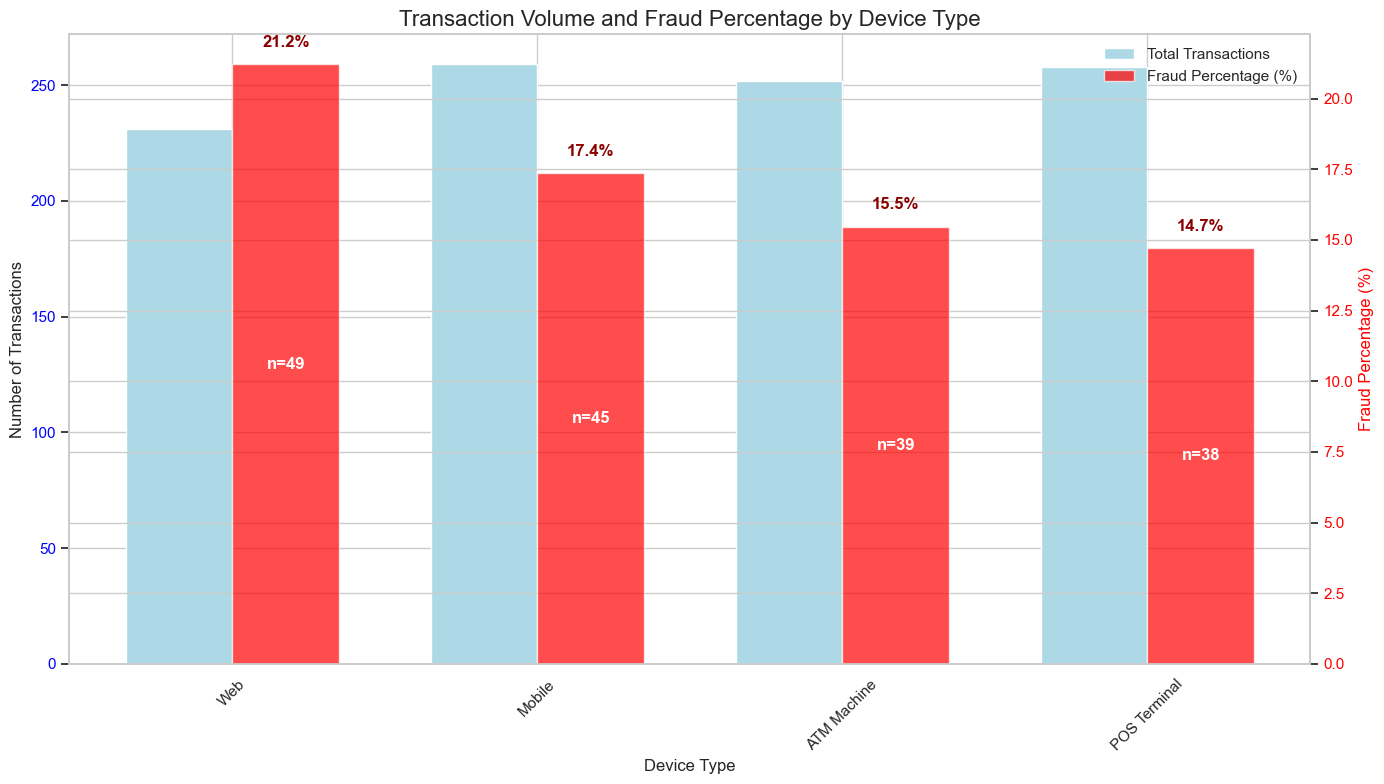

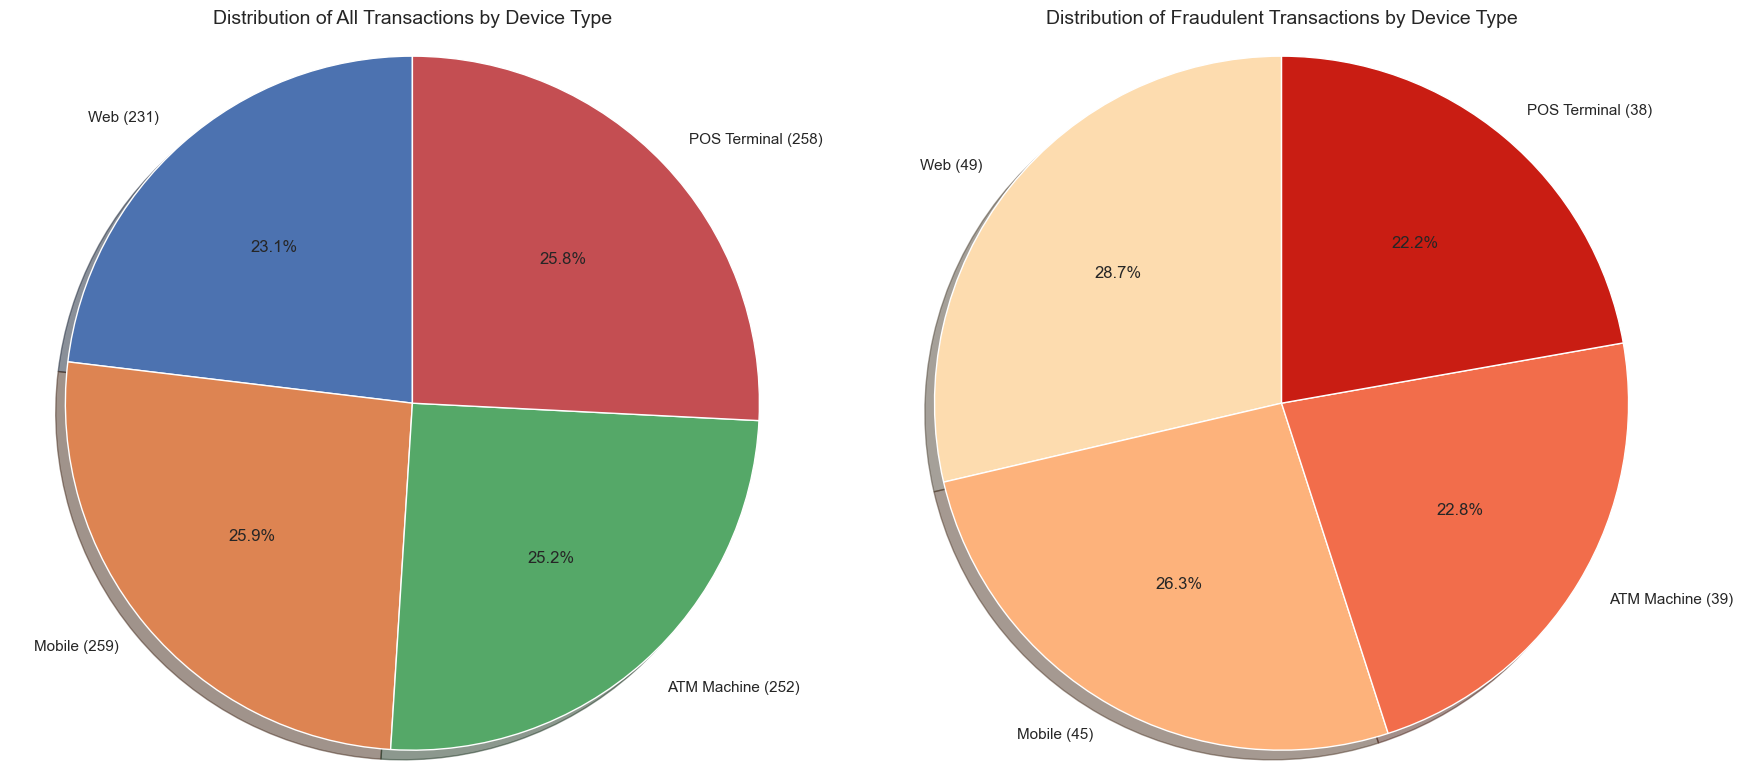


Overall fraud rate across all devices: 17.10%

Risk ratio by device type (ratio of device's fraud rate to overall fraud rate):
    device_type  fraud_percentage  risk_ratio
3           Web         21.212121    1.240475
1        Mobile         17.374517    1.016054
0   ATM Machine         15.476190    0.905040
2  POS Terminal         14.728682    0.861326


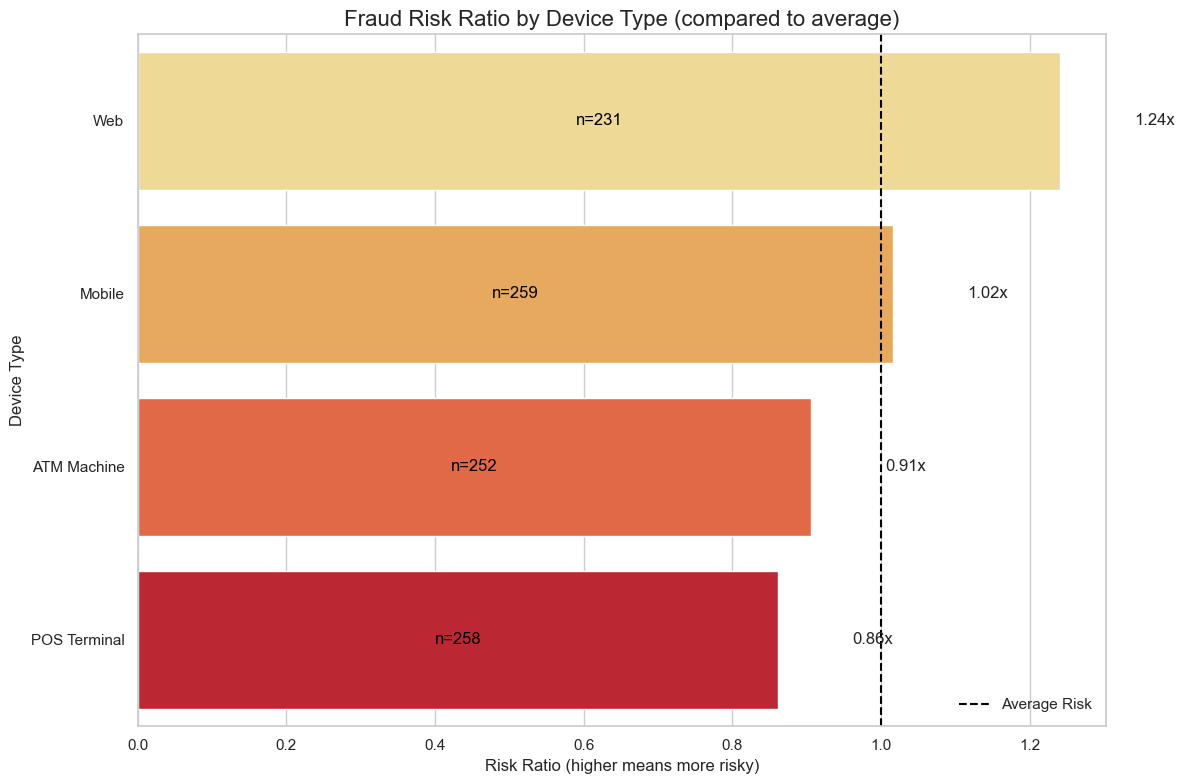


Analyzing interaction between device type and transaction type...

Fraud rate (%) for each device-transaction type combination:
transaction_type        ATM     Online        POS   Transfer    Overall
device_type                                                            
ATM Machine       16.666667  15.853659  16.666667   7.692308  15.476190
Mobile            20.754717  17.647059  18.181818   4.545455  17.374517
POS Terminal       9.523810  22.222222  12.903226   9.523810  14.728682
Web               23.913043  21.666667  17.525773  28.571429  21.212121
Overall           17.142857  19.155844  16.363636  13.402062  17.100000


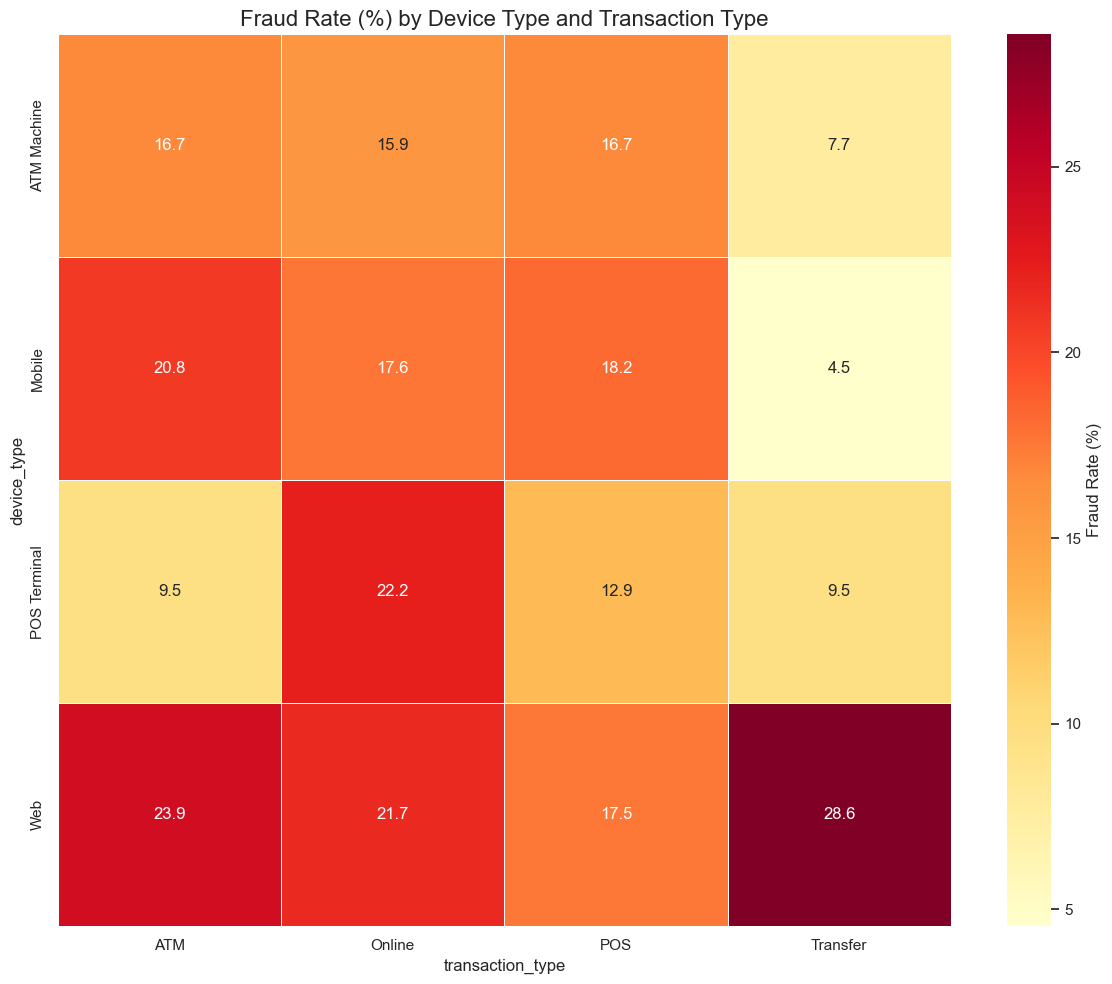

In [75]:
# Analysis of fraud patterns by device type

print("Analyzing fraud patterns by device type...")

# Check if device_type column exists in the dataframe
if 'device_type' not in df_cleaned.columns:
    print("device_type column not found in the dataframe")
else:
    # 1. Calculate overall fraud statistics by device type
    device_type_stats = df_cleaned.groupby('device_type').agg({
        'transaction_id': 'count',
        'label_code': ['sum', lambda x: (x == 0).sum()]
    })
    
    # Flatten the multi-level columns
    device_type_stats.columns = ['total_transactions', 'fraud_transactions', 'legitimate_transactions']
    device_type_stats = device_type_stats.reset_index()
    
    # Calculate fraud percentage
    device_type_stats['fraud_percentage'] = (device_type_stats['fraud_transactions'] / 
                                          device_type_stats['total_transactions'] * 100)
    
    # Sort by fraud percentage in descending order
    device_type_stats = device_type_stats.sort_values('fraud_percentage', ascending=False)
    
    print("\nFraud statistics by device type:")
    print(device_type_stats)
    
    # 2. VISUALIZATION: Bar chart showing fraud percentage by device type
    plt.figure(figsize=(14, 8))
    
    # Calculate positions for the bars
    x = np.arange(len(device_type_stats))
    width = 0.35
    
    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Plot the total transactions on the primary y-axis
    bars1 = ax1.bar(x - width/2, device_type_stats['total_transactions'], width, 
                    label='Total Transactions', color='lightblue')
    ax1.set_ylabel('Number of Transactions', fontsize=12)
    
    # Plot the fraud percentage on the secondary y-axis
    bars2 = ax2.bar(x + width/2, device_type_stats['fraud_percentage'], width, 
                    label='Fraud Percentage (%)', color='red', alpha=0.7)
    ax2.set_ylabel('Fraud Percentage (%)', fontsize=12, color='red')
    
    # Add labels and formatting
    ax1.set_xlabel('Device Type', fontsize=12)
    ax1.set_title('Transaction Volume and Fraud Percentage by Device Type', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(device_type_stats['device_type'], rotation=45)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add labels above the fraud percentage bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', color='darkred')
        
        # Also add the count of fraud transactions
        ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                f'n={device_type_stats["fraud_transactions"].iloc[i]}', 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # 3. VISUALIZATION: Pie charts for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Pie chart for transaction volume by device
    ax1.pie(device_type_stats['total_transactions'], 
            labels=[f"{d} ({n})" for d, n in zip(device_type_stats['device_type'], 
                                                device_type_stats['total_transactions'])],
            autopct='%1.1f%%', startangle=90, shadow=True)
    ax1.set_title('Distribution of All Transactions by Device Type', fontsize=14)
    ax1.axis('equal')
    
    # Pie chart for fraud transactions by device
    ax2.pie(device_type_stats['fraud_transactions'], 
            labels=[f"{d} ({n})" for d, n in zip(device_type_stats['device_type'], 
                                               device_type_stats['fraud_transactions'])],
            autopct='%1.1f%%', startangle=90, shadow=True, colors=sns.color_palette("OrRd", len(device_type_stats)))
    ax2.set_title('Distribution of Fraudulent Transactions by Device Type', fontsize=14)
    ax2.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Calculate risk ratio compared to average fraud rate
    overall_fraud_rate = df_cleaned['label_code'].mean() * 100
    device_type_stats['risk_ratio'] = device_type_stats['fraud_percentage'] / overall_fraud_rate
    
    print(f"\nOverall fraud rate across all devices: {overall_fraud_rate:.2f}%")
    print("\nRisk ratio by device type (ratio of device's fraud rate to overall fraud rate):")
    print(device_type_stats[['device_type', 'fraud_percentage', 'risk_ratio']].sort_values('risk_ratio', ascending=False))
    
    # 5. VISUALIZATION: Risk ratio by device type with color gradient
    plt.figure(figsize=(12, 8))
    
    # Create a color palette with more intense color for higher risk
    palette = sns.color_palette("YlOrRd", n_colors=len(device_type_stats))
    
    # Create bar plot for risk ratio
    bars = sns.barplot(x="risk_ratio", y="device_type", 
                      data=device_type_stats.sort_values('risk_ratio', ascending=False),
                      palette=palette)
    
    # Add a vertical line at risk_ratio=1 (average risk)
    plt.axvline(x=1, color='black', linestyle='--', label='Average Risk')
    
    # Add value labels to the bars
    for i, bar in enumerate(bars.patches):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                 f"{bar.get_width():.2f}x", ha='left', va='center')
        
        # Add count of total transactions inside the bars
        plt.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, 
                 f"n={device_type_stats.sort_values('risk_ratio', ascending=False)['total_transactions'].iloc[i]}", 
                 ha='center', va='center', color='white' if bar.get_width() > 1.5 else 'black')
    
    # Customize the plot
    plt.title('Fraud Risk Ratio by Device Type (compared to average)', fontsize=16)
    plt.xlabel('Risk Ratio (higher means more risky)', fontsize=12)
    plt.ylabel('Device Type', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 6. Additional analysis: Cross-tab of device type and transaction type 
    if 'transaction_type' in df_cleaned.columns:
        print("\nAnalyzing interaction between device type and transaction type...")
        
        # Create a crosstab
        cross_tab = pd.crosstab(df_cleaned['device_type'], 
                               df_cleaned['transaction_type'],
                               values=df_cleaned['label_code'],
                               aggfunc=lambda x: x.mean() * 100,
                               margins=True,
                               margins_name='Overall')
        
        print("\nFraud rate (%) for each device-transaction type combination:")
        print(cross_tab)
        
        # Visualization of the crosstab as a heatmap (excluding margins)
        plt.figure(figsize=(12, 10))
        cross_tab_for_plot = cross_tab.iloc[:-1, :-1]  # Exclude the margins
        
        # Plot the heatmap
        sns.heatmap(cross_tab_for_plot, annot=True, cmap="YlOrRd", fmt=".1f", linewidths=0.5,
                   cbar_kws={'label': 'Fraud Rate (%)'})
        plt.title('Fraud Rate (%) by Device Type and Transaction Type', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Store the results for potential feature engineering
    device_type_fraud_profile = device_type_stats.set_index('device_type')

**Fraud Analysis by Location**

Examining geographic patterns of fraud to identify high-risk locations and regional fraud patterns.

Analyzing fraud patterns by location...
Location-related columns found: ['location', 'is_high_risk_country']
Using 'location' for location fraud analysis

Fraud statistics by location (showing only locations with at least 10 transactions):
        location  total_transactions  fraud_transactions  \
0          Abuja                 189                  39   
4  Port Harcourt                 201                  37   
2           Kano                 185                  34   
1         Ibadan                 200                  32   
3          Lagos                 225                  29   

   legitimate_transactions  fraud_percentage  
0                      150         20.634921  
4                      164         18.407960  
2                      151         18.378378  
1                      168         16.000000  
3                      196         12.888889  


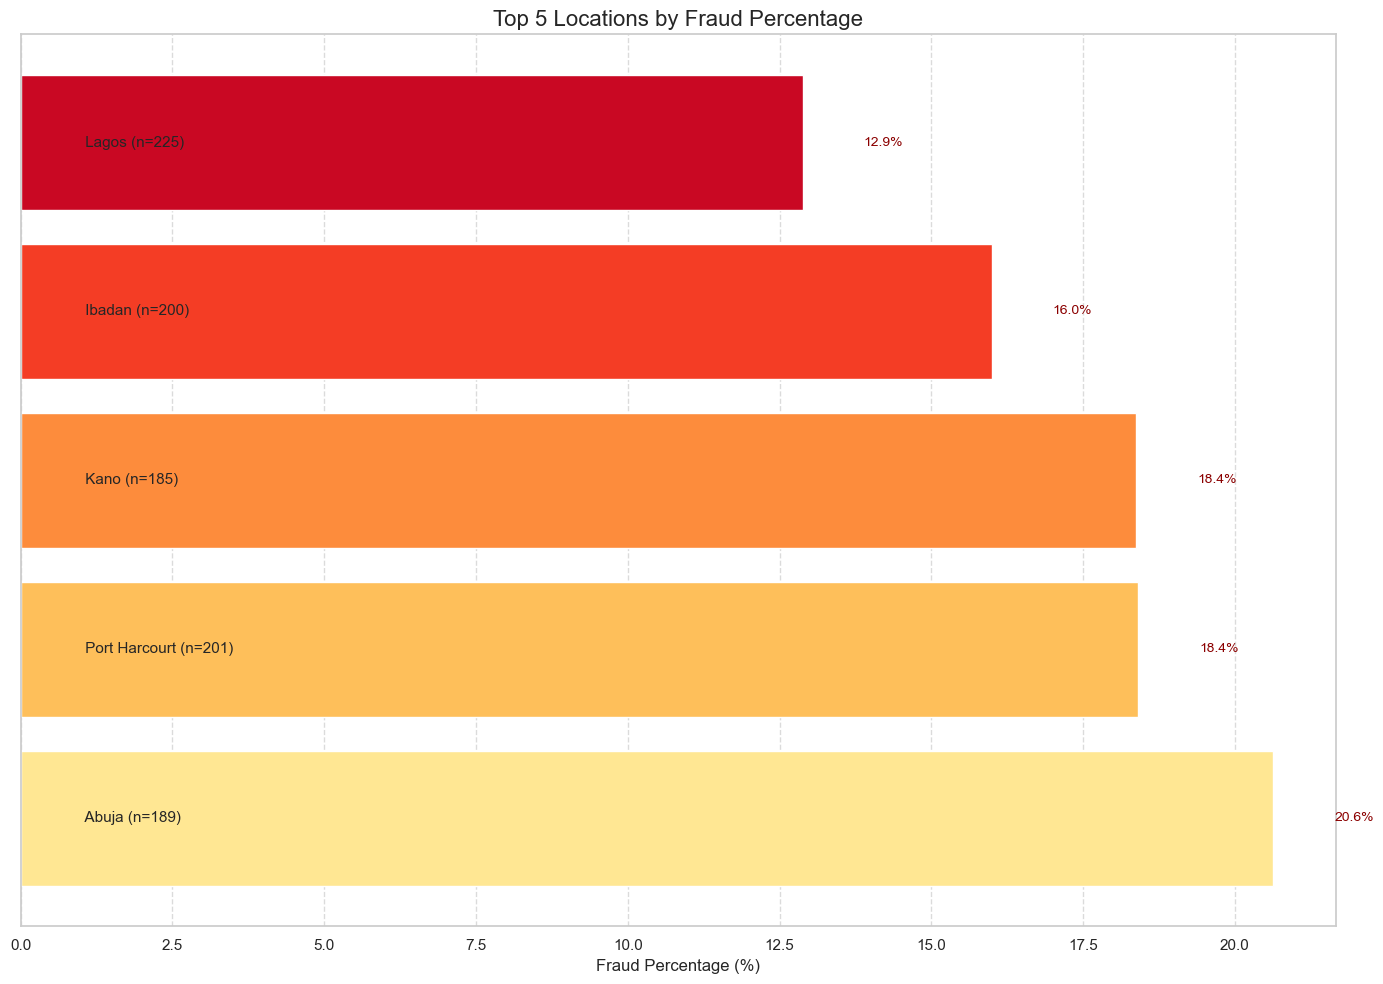

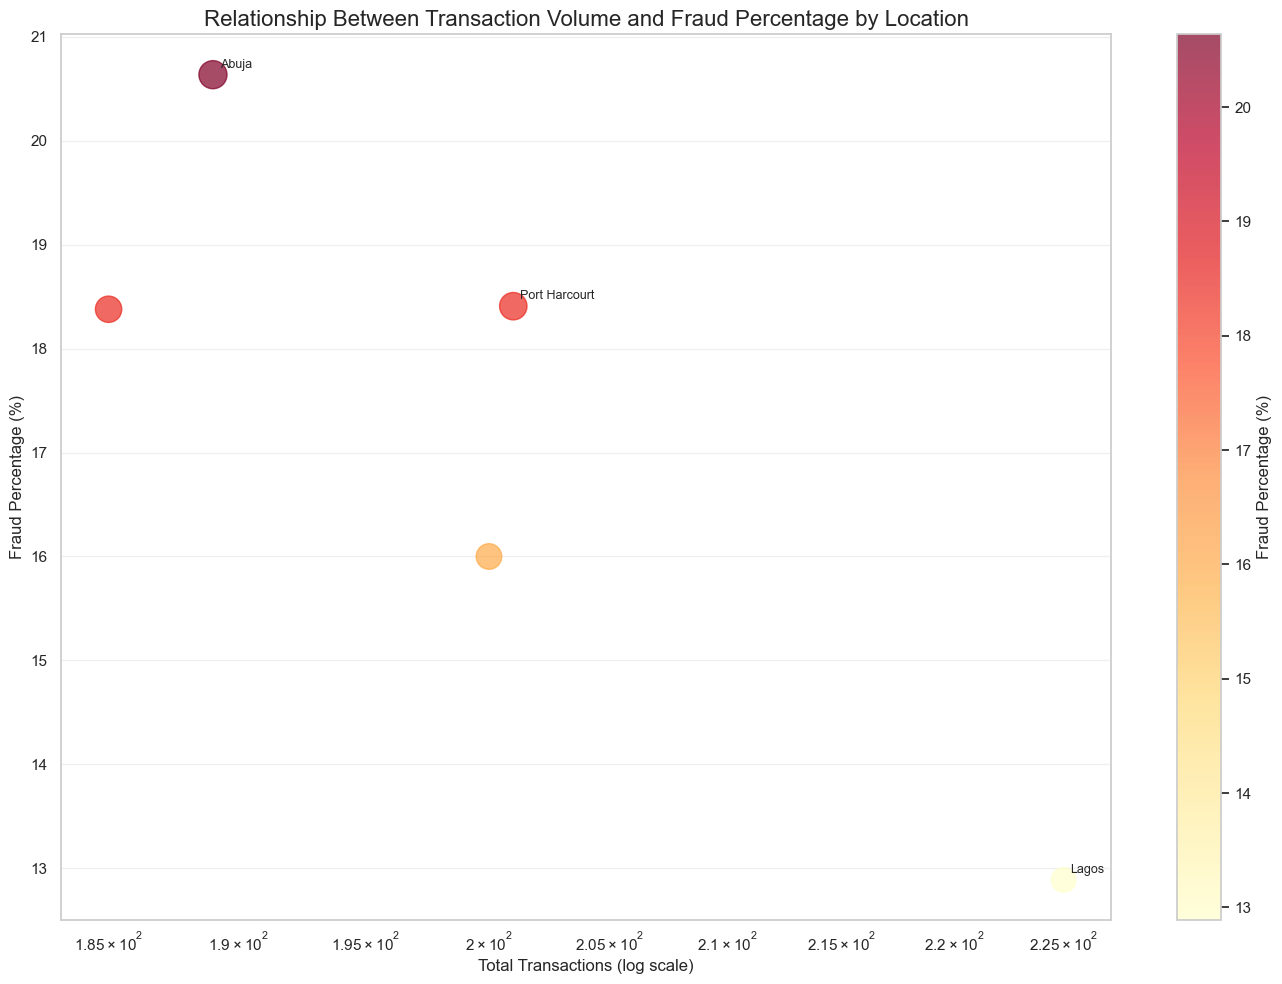


Overall fraud rate across all locations: 17.10%

Top risk locations (risk ratio compared to average):
        location  total_transactions  fraud_percentage  risk_ratio
0          Abuja                 189         20.634921    1.206721
4  Port Harcourt                 201         18.407960    1.076489
2           Kano                 185         18.378378    1.074759
1         Ibadan                 200         16.000000    0.935673
3          Lagos                 225         12.888889    0.753736

Geographic concentration of fraud:
3 out of 5 locations (60.0%) account for 50% of all fraud
4 out of 5 locations (80.0%) account for 75% of all fraud
5 out of 5 locations (100.0%) account for 90% of all fraud


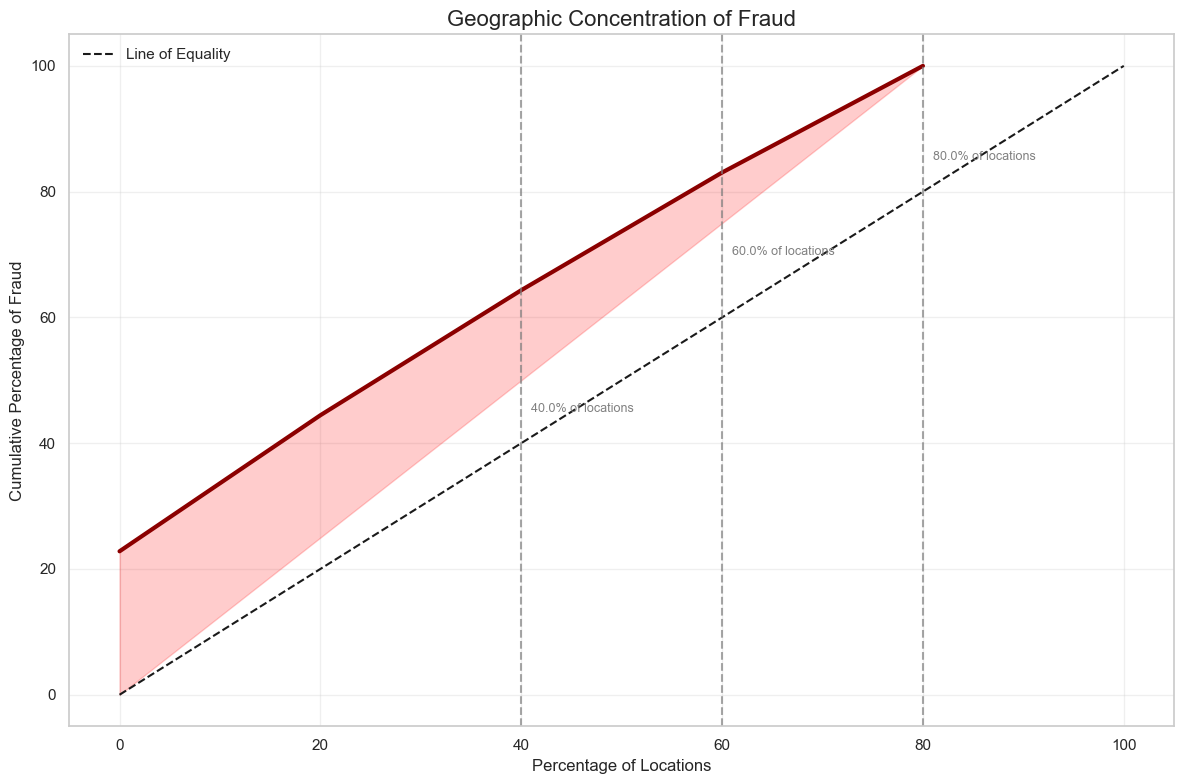

In [78]:
# Analysis of fraud patterns by location

print("Analyzing fraud patterns by location...")

# Check for location-related columns in the dataframe
location_columns = [col for col in df_cleaned.columns if any(x in col.lower() for x in ['location', 'country', 'state', 'city', 'zip', 'postal', 'region', 'address'])]

if not location_columns:
    print("No location-related columns found in the dataframe.")
else:
    print(f"Location-related columns found: {location_columns}")
    
    location_col = location_columns[0]  # Default to first found
    
    # Check if it's a country or state/region column
    for col in location_columns:
        if 'location' in col.lower():
            location_col = col
        elif 'state' in col.lower() or 'region' in col.lower():
            location_col = col
            break
    
    print(f"Using '{location_col}' for location fraud analysis")
    
    # 1. Calculate overall fraud statistics by location
    # Fixed: Using a dictionary format for aggregation instead of named arguments
    location_stats = df_cleaned.groupby(location_col).agg({
        'transaction_id': 'count',
        'label_code': ['sum', lambda x: (x == 0).sum()]
    })
    
    # Flatten the multi-level columns
    location_stats.columns = ['total_transactions', 'fraud_transactions', 'legitimate_transactions']
    location_stats = location_stats.reset_index()
    
    # Calculate fraud percentage
    location_stats['fraud_percentage'] = (location_stats['fraud_transactions'] / 
                                       location_stats['total_transactions'] * 100)
    
    # Sort by fraud percentage in descending order
    location_stats = location_stats.sort_values('fraud_percentage', ascending=False)
    
    # Keep only locations with at least 10 transactions for meaningful analysis
    min_transactions = 10
    filtered_locations = location_stats[location_stats['total_transactions'] >= min_transactions]
    
    print(f"\nFraud statistics by location (showing only locations with at least {min_transactions} transactions):")
    print(filtered_locations.head(20))  # Show top 20 locations by fraud percentage
    
    # 2. VISUALIZATION: Top N locations by fraud percentage
    top_n = min(15, len(filtered_locations))  # Show top 15 or fewer if there aren't that many
    
    plt.figure(figsize=(14, 10))
    
    # Create a colormap where higher fraud percentage = darker red
    top_locations = filtered_locations.head(top_n)
    colors = sns.color_palette("YlOrRd", n_colors=top_n)
    
    # Create horizontal bar chart
    bars = plt.barh(y=range(top_n), 
                   width=top_locations['fraud_percentage'],
                   color=colors)
    
    # Add location names and transaction counts
    for i, (_, row) in enumerate(top_locations.iterrows()):
        plt.text(1, i, f" {row[location_col]} (n={row['total_transactions']})", 
                va='center', fontsize=11)
        
        # Add fraud percentage at the end of each bar
        plt.text(row['fraud_percentage'] + 1, i, f"{row['fraud_percentage']:.1f}%", 
                va='center', fontsize=10, color='darkred')
    
    # Remove y-ticks as we've added custom labels
    plt.yticks([])
    
    # Customize the plot
    plt.xlabel('Fraud Percentage (%)', fontsize=12)
    plt.title(f'Top {top_n} Locations by Fraud Percentage', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. VISUALIZATION: Relationship between transaction volume and fraud percentage
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot with point size based on fraud transactions
    scatter = plt.scatter(filtered_locations['total_transactions'], 
                         filtered_locations['fraud_percentage'],
                         s=filtered_locations['fraud_transactions'] * 10 + 20,  # Size based on fraud count
                         alpha=0.7,
                         c=filtered_locations['fraud_percentage'], # Color by fraud percentage
                         cmap='YlOrRd')
    
    # Add location labels for points with high fraud percentage or high volume
    threshold_pct = filtered_locations['fraud_percentage'].quantile(0.75)  # Top 25% by fraud percentage
    threshold_vol = filtered_locations['total_transactions'].quantile(0.75)  # Top 25% by volume
    
    for _, row in filtered_locations.iterrows():
        if row['fraud_percentage'] >= threshold_pct or row['total_transactions'] >= threshold_vol:
            plt.annotate(row[location_col], 
                        (row['total_transactions'], row['fraud_percentage']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Customize the plot
    plt.xscale('log')  # Log scale for better visualization
    plt.colorbar(label='Fraud Percentage (%)')
    plt.title('Relationship Between Transaction Volume and Fraud Percentage by Location', fontsize=16)
    plt.xlabel('Total Transactions (log scale)', fontsize=12)
    plt.ylabel('Fraud Percentage (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Calculate risk ratio compared to average fraud rate
    overall_fraud_rate = df_cleaned['label_code'].mean() * 100
    location_stats['risk_ratio'] = location_stats['fraud_percentage'] / overall_fraud_rate
    
    print(f"\nOverall fraud rate across all locations: {overall_fraud_rate:.2f}%")
    print("\nTop risk locations (risk ratio compared to average):")
    print(location_stats[location_stats['total_transactions'] >= min_transactions][
        [location_col, 'total_transactions', 'fraud_percentage', 'risk_ratio']
    ].sort_values('risk_ratio', ascending=False).head(20))
    
    # 5. VISUALIZATION: Geographic fraud concentration (only if the data supports it)
    # If we have country or state data, create a concentration statistic
    
    # Calculate what percentage of total fraud comes from each location
    location_stats['fraud_contribution'] = location_stats['fraud_transactions'] / location_stats['fraud_transactions'].sum() * 100
    
    # Sort by fraud contribution in descending order
    location_stats_by_contribution = location_stats.sort_values('fraud_contribution', ascending=False)
    
    # Calculate cumulative percentage
    location_stats_by_contribution['cumulative_fraud_contribution'] = location_stats_by_contribution['fraud_contribution'].cumsum()
    
    # Find how many locations account for X% of fraud
    thresholds = [50, 75, 90]
    print("\nGeographic concentration of fraud:")
    
    for threshold in thresholds:
        locations_needed = np.argmax(location_stats_by_contribution['cumulative_fraud_contribution'] >= threshold) + 1
        total_locations = len(location_stats_by_contribution)
        print(f"{locations_needed} out of {total_locations} locations ({locations_needed/total_locations*100:.1f}%) account for {threshold}% of all fraud")
    
    # 6. VISUALIZATION: Geographic fraud concentration
    plt.figure(figsize=(12, 8))
    
    # Create indices representing the percentage of locations
    location_percentile = np.arange(len(location_stats_by_contribution)) / len(location_stats_by_contribution) * 100
    
    # Plot the cumulative fraud contribution curve
    plt.plot(location_percentile, location_stats_by_contribution['cumulative_fraud_contribution'], 
             linewidth=3, color='darkred')
    
    # Add reference line for perfect equality
    plt.plot([0, 100], [0, 100], 'k--', label='Line of Equality')
    
    # Add vertical lines for thresholds
    for threshold in thresholds:
        x_pos = np.argmax(location_stats_by_contribution['cumulative_fraud_contribution'] >= threshold) / len(location_stats_by_contribution) * 100
        plt.axvline(x=x_pos, color='gray', linestyle='--', alpha=0.7)
        plt.text(x_pos + 1, threshold - 5, f"{x_pos:.1f}% of locations", fontsize=9, color='gray')
    
    # Customize the plot
    plt.fill_between(location_percentile, location_stats_by_contribution['cumulative_fraud_contribution'], 
                    np.linspace(0, 100, len(location_stats_by_contribution)), alpha=0.2, color='red')
    plt.title('Geographic Concentration of Fraud', fontsize=16)
    plt.xlabel('Percentage of Locations', fontsize=12)
    plt.ylabel('Cumulative Percentage of Fraud', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Store the results for potential feature engineering
    location_fraud_profile = location_stats.set_index(location_col)

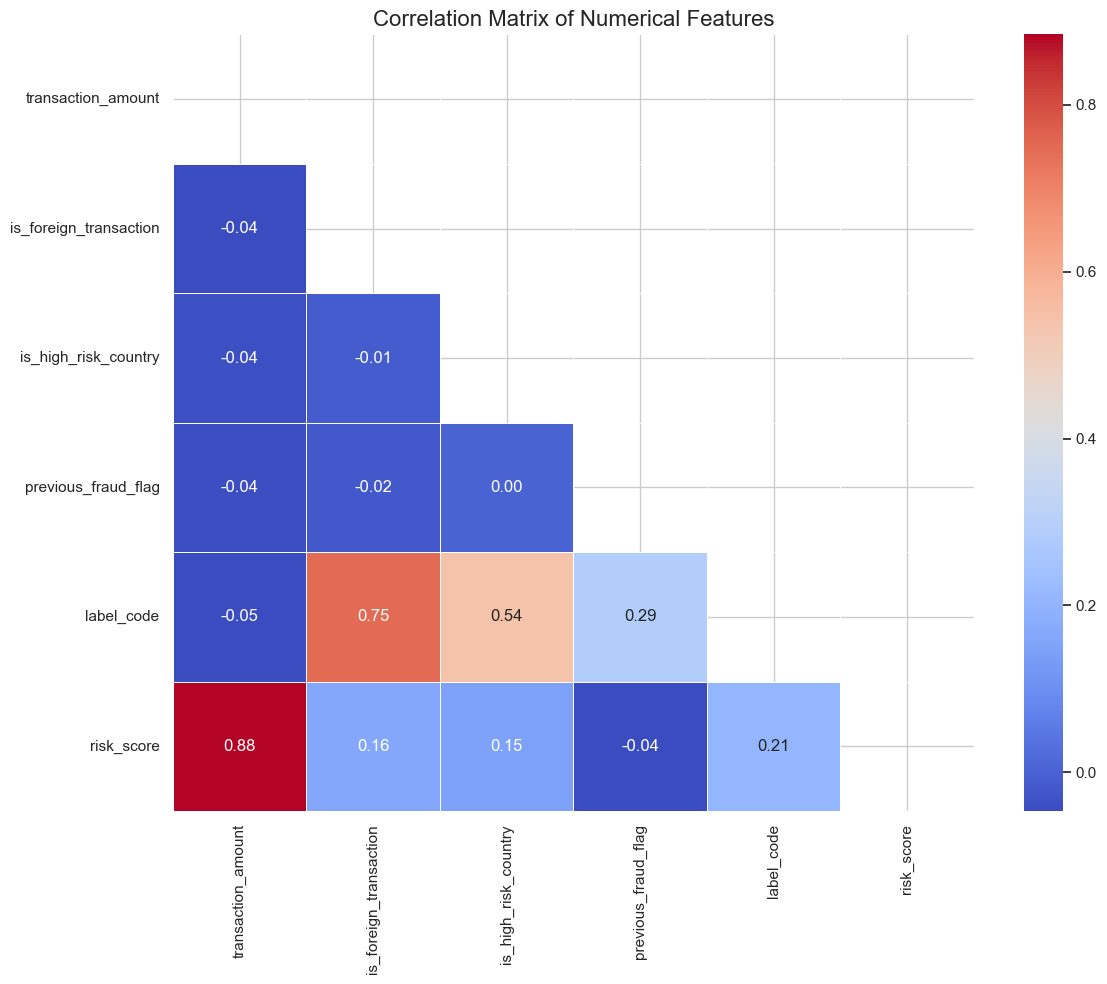

Highly correlated feature pairs:
transaction_amount and risk_score: 0.88
is_foreign_transaction and label_code: 0.75
is_high_risk_country and label_code: 0.54


In [27]:
# Correlation analysis
# Selecting numerical columns for correlation analysis
numerical_df = df_cleaned.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
corr_matrix = numerical_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Identify highly correlated features (absolute correlation > 0.7)
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [(col1, col2, corr_matrix.loc[col1, col2]) 
                       for col1 in high_corr.index 
                       for col2 in high_corr.columns 
                       if abs(high_corr.loc[col1, col2]) > 0.5]

print("Highly correlated feature pairs:")
for col1, col2, corr_val in high_corr_features:
    print(f"{col1} and {col2}: {corr_val:.2f}")

## 5. Temporal Pattern Analysis

Understanding temporal patterns is crucial for fraud detection. Therefore it's important to analyze how fraud patterns correlate with time-based features like time of day, day of week, and other temporal trends.

Temporal features extracted from transaction_time


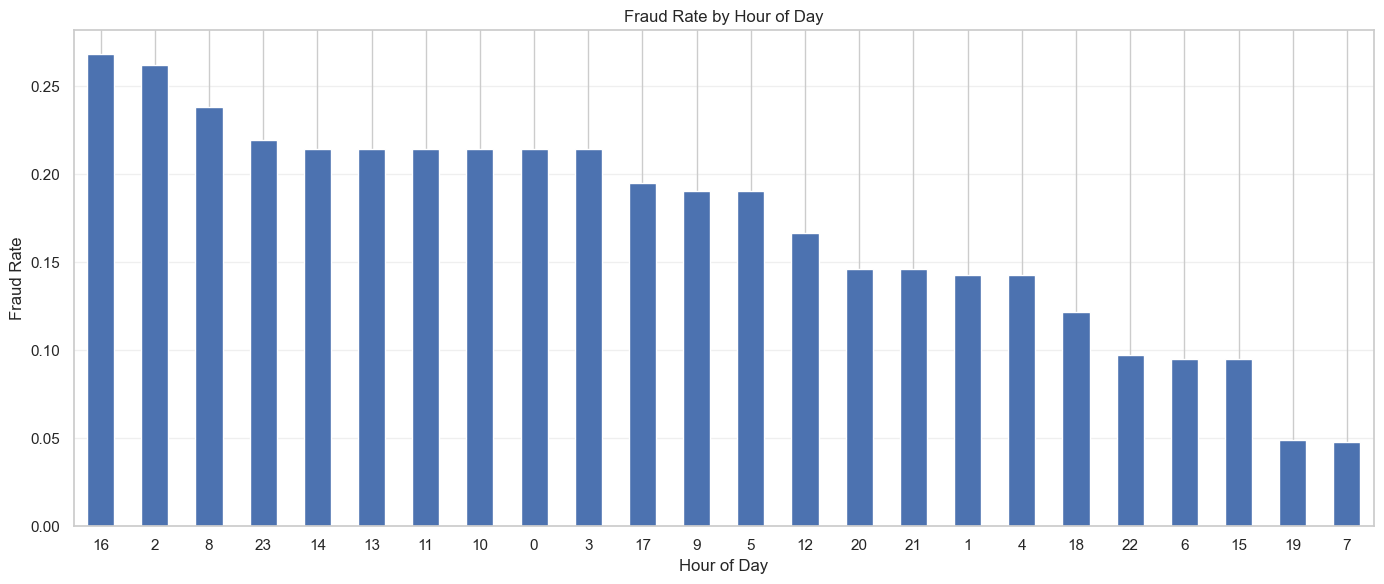

In [28]:
# Extract temporal features from transaction_time
# Ensuring transaction_time is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df_cleaned['transaction_time']):
    try:
        df_cleaned['transaction_time'] = pd.to_datetime(df_cleaned['transaction_time'])
    except Exception as e:
        print(f"Error converting transaction_time to datetime: {e}")
        print("Will try to use time_of_day and day_of_week columns directly.")

# Extracting various time components
if pd.api.types.is_datetime64_any_dtype(df_cleaned['transaction_time']):
    df_cleaned['hour'] = df_cleaned['transaction_time'].dt.hour
    df_cleaned['day_of_week_num'] = df_cleaned['transaction_time'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_cleaned['day_name'] = df_cleaned['transaction_time'].dt.day_name()
    df_cleaned['month'] = df_cleaned['transaction_time'].dt.month
    df_cleaned['quarter'] = df_cleaned['transaction_time'].dt.quarter
    df_cleaned['is_weekend'] = df_cleaned['day_of_week_num'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise
    
    # Defining time of day periods
    bins = [0, 6, 12, 18, 24]
    labels = ['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
    df_cleaned['time_period'] = pd.cut(df_cleaned['hour'], bins=bins, labels=labels, include_lowest=True)
    
    print("Temporal features extracted from transaction_time")
else:
    # If transaction_time is not available, using the provided time_of_day and day_of_week columns
    if 'time_of_day' in df_cleaned.columns and 'day_of_week' in df_cleaned.columns:
        print("Using provided time_of_day and day_of_week columns")
    else:
        print("Warning: No temporal features available for analysis")

# Function to calculate fraud rate by group
def fraud_rate_by_group(df, group_col, target_col='label_code', binary_target=False, risk_threshold=None):
    if binary_target:
        # Create binary target if it doesn't exist
        if 'is_high_risk' not in df.columns:
            df['is_high_risk'] = (df[target_col] > risk_threshold).astype(int)
        
        # Calculate fraud rate by group
        fraud_by_group = df.groupby(group_col)['is_high_risk'].mean().sort_values(ascending=False)
        return fraud_by_group
    else:
        # For non-binary target, return the average target value by group
        return df.groupby(group_col)[target_col].mean().sort_values(ascending=False)

# Analyze fraud patterns by hour of day
if 'hour' in df_cleaned.columns:
    # Fraud rate by hour
    fraud_by_hour = fraud_rate_by_group(df_cleaned, 'hour', binary_target=True, risk_threshold=df_cleaned['label_code'].median())
    
    plt.figure(figsize=(14, 6))
    fraud_by_hour.plot(kind='bar')
    plt.title('Fraud Rate by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
elif 'time_of_day' in df_cleaned.columns:
    # Fraud rate by time of day
    fraud_by_time = fraud_rate_by_group(df_cleaned, 'time_of_day', binary_target=True, risk_threshold=df_cleaned['label_code'].median())
    
    plt.figure(figsize=(14, 6))
    fraud_by_time.plot(kind='bar')
    plt.title('Fraud Rate by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

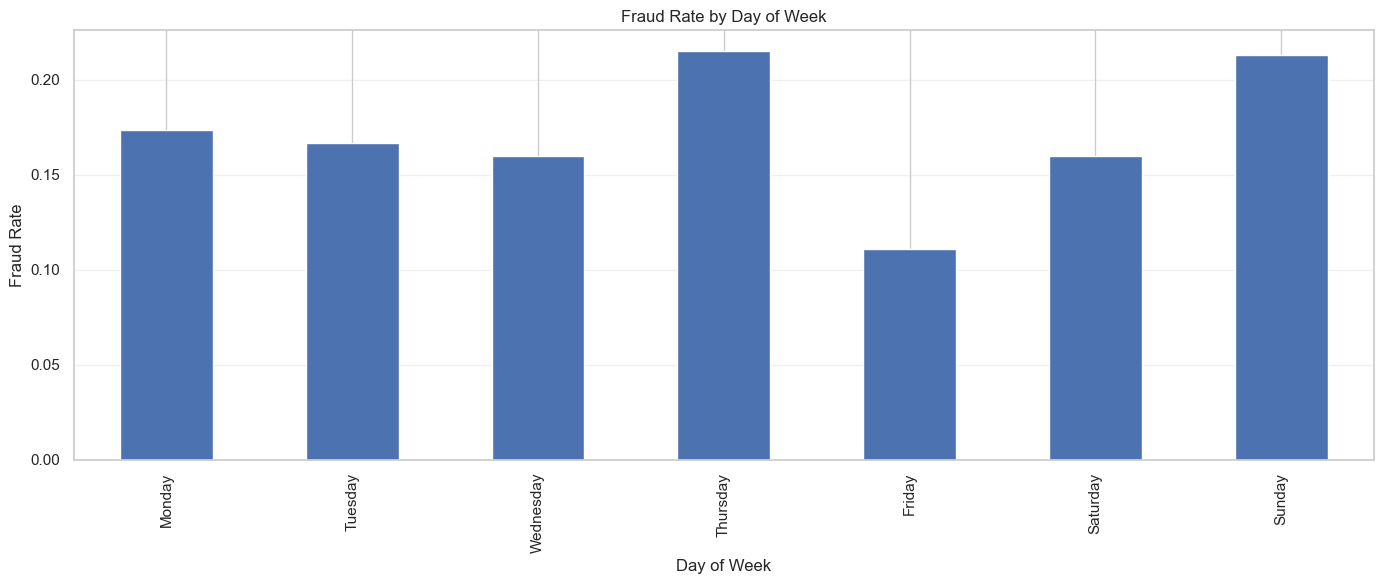

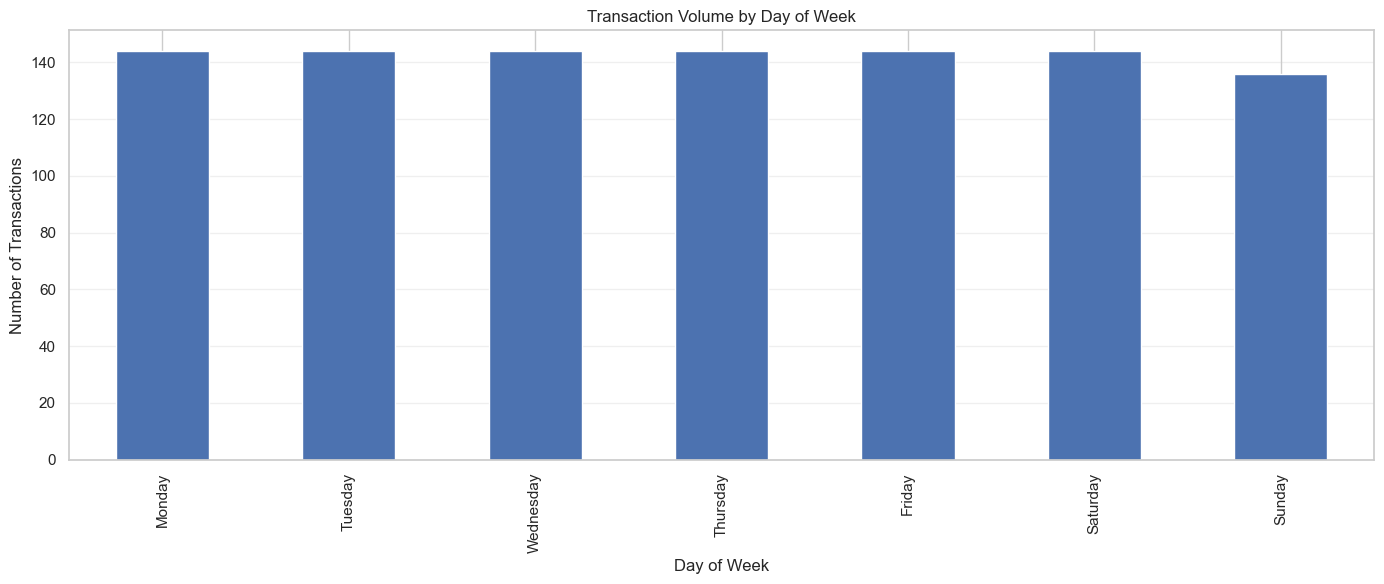

In [29]:
# Analyze fraud patterns by day of week
if 'day_name' in df_cleaned.columns:
    # Define order of days for consistent plotting
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Fraud rate by day of week
    fraud_by_day = df_cleaned.groupby('day_name')['is_high_risk'].mean()
    fraud_by_day = fraud_by_day.reindex(day_order)
    
    plt.figure(figsize=(14, 6))
    fraud_by_day.plot(kind='bar')
    plt.title('Fraud Rate by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Fraud Rate')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Transaction volume by day of week
    volume_by_day = df_cleaned['day_name'].value_counts()
    volume_by_day = volume_by_day.reindex(day_order)
    
    plt.figure(figsize=(14, 6))
    volume_by_day.plot(kind='bar')
    plt.title('Transaction Volume by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Transactions')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
elif 'day_of_week' in df_cleaned.columns:
    # Fraud rate by day of week
    fraud_by_day = fraud_rate_by_group(df_cleaned, 'day_of_week', binary_target=True, risk_threshold=df_cleaned['label_code'].median())
    
    plt.figure(figsize=(14, 6))
    fraud_by_day.plot(kind='bar')
    plt.title('Fraud Rate by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Fraud Rate')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Transaction volume by day of week
    volume_by_day = df_cleaned['day_of_week'].value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    volume_by_day.plot(kind='bar')
    plt.title('Transaction Volume by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Transactions')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

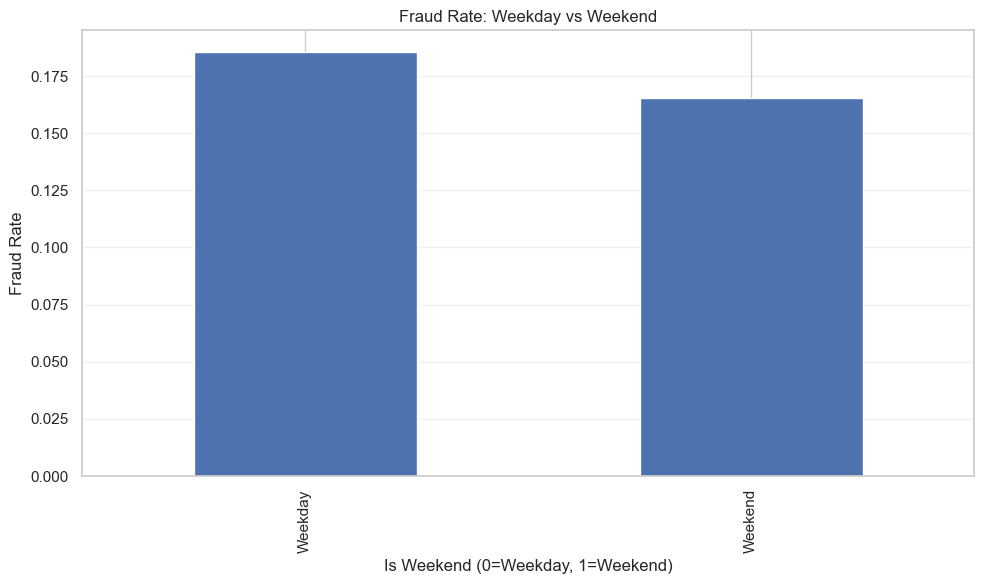

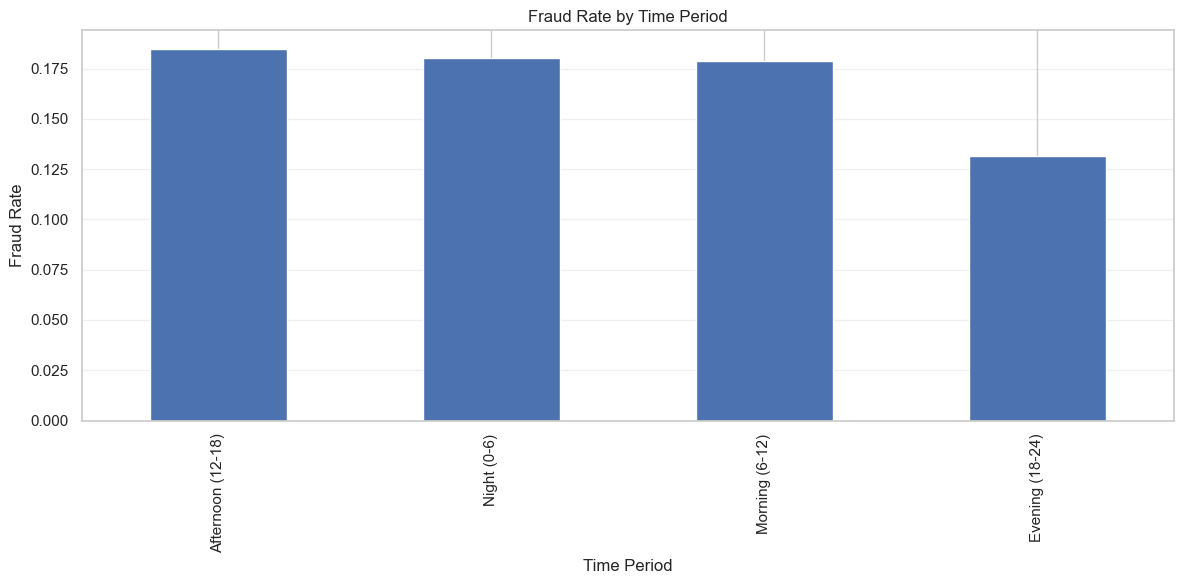

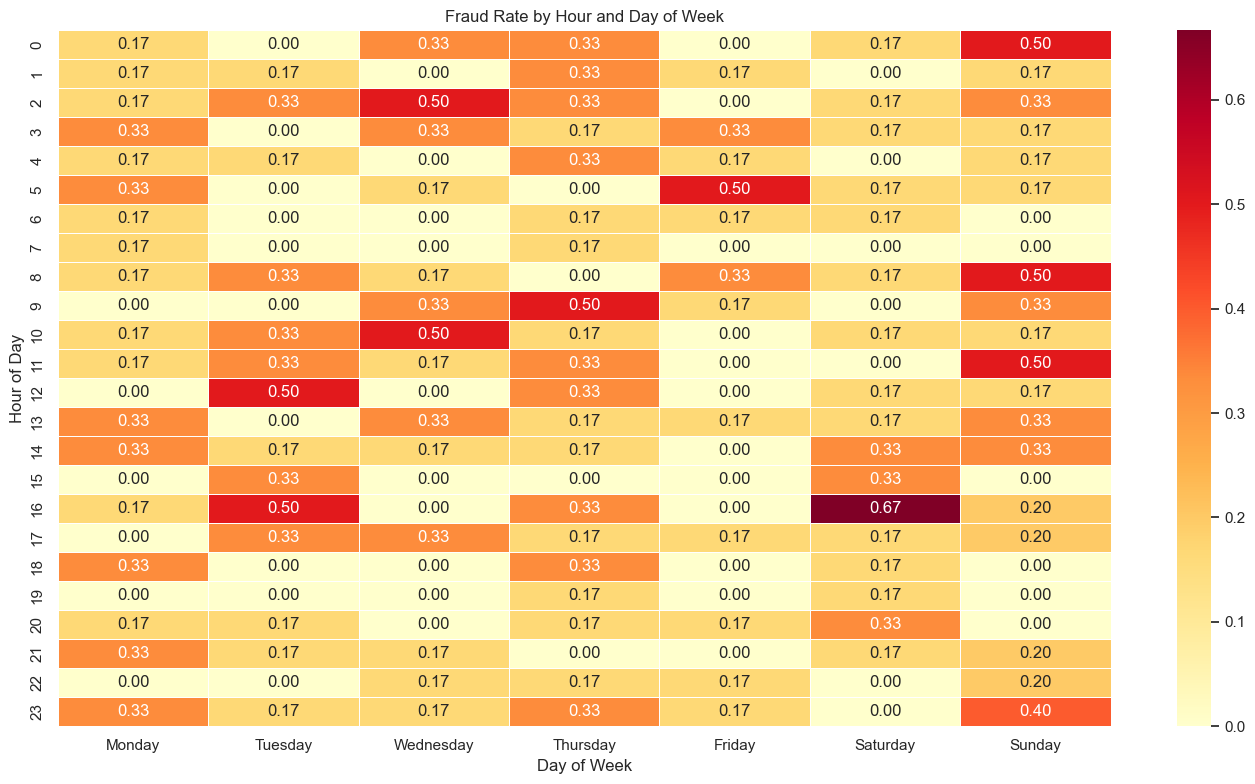


Key findings from temporal pattern analysis:
--------------------------------------------
- Peak fraud hour: 16:00 (rate: 0.2683)
- Lowest fraud hour: 7:00 (rate: 0.0476)
- Peak fraud day: Thursday (rate: 0.2153)
- Lowest fraud day: Friday (rate: 0.1111)
- Weekend vs Weekday fraud rate: 0.1857 vs 0.1653
- Weekend fraud is higher than weekday fraud


In [30]:
# Analyze weekend vs weekday patterns
if 'is_weekend' in df_cleaned.columns:
    # Fraud rate by weekend status
    fraud_by_weekend = fraud_rate_by_group(df_cleaned, 'is_weekend', binary_target=True, risk_threshold=df_cleaned['label_code'].median())
    
    plt.figure(figsize=(10, 6))
    fraud_by_weekend.plot(kind='bar')
    plt.title('Fraud Rate: Weekday vs Weekend')
    plt.xlabel('Is Weekend (0=Weekday, 1=Weekend)')
    plt.ylabel('Fraud Rate')
    plt.xticks([0, 1], ['Weekday', 'Weekend'])
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Analyze fraud patterns by time period
if 'time_period' in df_cleaned.columns:
    # Fraud rate by time period
    fraud_by_period = fraud_rate_by_group(df_cleaned, 'time_period', binary_target=True, risk_threshold=df_cleaned['label_code'].median())
    
    plt.figure(figsize=(12, 6))
    fraud_by_period.plot(kind='bar')
    plt.title('Fraud Rate by Time Period')
    plt.xlabel('Time Period')
    plt.ylabel('Fraud Rate')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create heatmap of hour vs day for fraud rate
if 'hour' in df_cleaned.columns and 'day_name' in df_cleaned.columns:
    # Create pivot table of fraud rate by hour and day
    pivot = pd.pivot_table(df_cleaned, values='is_high_risk', index='hour', columns='day_name', aggfunc='mean')
    
    # Reorder columns to standard week order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot = pivot.reindex(columns=day_order)
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt=".2f", linewidths=0.5)
    plt.title('Fraud Rate by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.tight_layout()
    plt.show()

# Summary of temporal patterns findings
print("\nKey findings from temporal pattern analysis:")
print("--------------------------------------------")

if 'hour' in df_cleaned.columns:
    peak_hour = fraud_by_hour.idxmax()
    min_hour = fraud_by_hour.idxmin()
    print(f"- Peak fraud hour: {peak_hour}:00 (rate: {fraud_by_hour.max():.4f})")
    print(f"- Lowest fraud hour: {min_hour}:00 (rate: {fraud_by_hour.min():.4f})")

if 'day_name' in df_cleaned.columns:
    peak_day = fraud_by_day.idxmax()
    min_day = fraud_by_day.idxmin()
    print(f"- Peak fraud day: {peak_day} (rate: {fraud_by_day.max():.4f})")
    print(f"- Lowest fraud day: {min_day} (rate: {fraud_by_day.min():.4f})")

if 'is_weekend' in df_cleaned.columns:
    weekend_rate = fraud_by_weekend.get(1, 0)
    weekday_rate = fraud_by_weekend.get(0, 0)
    print(f"- Weekend vs Weekday fraud rate: {weekend_rate:.4f} vs {weekday_rate:.4f}")
    print(f"- Weekend fraud is {'higher' if weekend_rate > weekday_rate else 'lower'} than weekday fraud")

**📊 Fraud Rate by Time Period**

Observation: Fraud rates are highest in the Afternoon (12pm–6pm) and Night (12am–6am), both slightly under 18.5%, while Evening (6pm–12am) is the lowest (~13%).

Interpretation: Although the differences aren't massive, there is a noticeable dip in fraud during the evening, suggesting that fraud detection or user behavior changes during that period may play a role.

Impact: This could justify slightly higher fraud scoring or alert thresholds for transactions in the afternoon and night.

**📊 Fraud Rate – Weekday vs Weekend**

Observation: Weekday fraud rate (~18.5%) is higher than the weekend rate (~16.5%).

Interpretation: Contrary to typical expectations, fraud is more prevalent on weekdays, which might be tied to higher transaction volume, more complex workflows, or reduced scrutiny during routine business operations.

Impact: The difference is modest but still actionable — useful for model features or dynamic fraud scoring strategies based on day type.

## 6. Feature Engineering

Based on our exploratory analysis, advanced features will be created to improve the model's ability to detect fraudulent transactions. This includes interaction features, temporal transformations, and encoding categorical variables.

In [49]:
df_cleaned.head()

transaction_id customer_id  transaction_amount transaction_type  \
0       TX100703    CUST1092            5.278908           Online   
1       TX100182    CUST1021          205.156878           Online   
2       TX100221    CUST1100           77.715851              POS   
3       TX100528    CUST1099            8.440649              ATM   
4       TX100776    CUST1014           11.125070           Online   

    device_type       location time_of_day day_of_week  \
0        Mobile          Abuja   Afternoon         Fri   
1   ATM Machine          Lagos     Evening         Tue   
2  POS Terminal         Ibadan     Morning         Wed   
3  POS Terminal           Kano     Evening         Sun   
4  POS Terminal  Port Harcourt       Night         Sun   

   is_foreign_transaction  is_high_risk_country  previous_fraud_flag  \
0                       0                     1                    0   
1                       0                     0                    0   
2                       0                     1                    0   
3                       0                     0                    0   
4                       1                     0                    0   

   label_code    transaction_time  risk_score  hour  day_of_week_num  \
0           1 2024-02-04 22:00:00    0.079284    22                6   
1           0 2024-01-17 04:00:00    2.358645     4                2   
2           1 2024-01-13 15:00:00    1.794567    15                5   
3           0 2024-01-18 06:00:00    0.095569     6                3   
4           1 2024-02-05 07:00:00    0.176721     7                0   

    day_name  month  quarter  is_weekend        time_period  is_high_risk  
0     Sunday      2        1           1    Evening (18-24)             1  
1  Wednesday      1        1           0        Night (0-6)             0  
2   Saturday      1        1           1  Afternoon (12-18)             1  
3   Thursday      1        1           0        Night (0-6)             0  
4     Monday      2        1           0     Morning (6-12)             1

In [51]:
# Create a copy of our dataframe for feature engineering
df_featured = df_cleaned.copy()

# Function to encapsulate all feature engineering steps for reusability
def engineer_features(df):
    """
    Apply feature engineering transformations to the dataset.
    
    Parameters:
    df (DataFrame): Input DataFrame
    
    Returns:
    DataFrame: DataFrame with engineered features
    """
    df_result = df.copy()
    
    # Dictionary to track created features and their rationale
    feature_explanations = {}
    
    # 1. Temporal Features
    if 'transaction_time' in df_result.columns and pd.api.types.is_datetime64_any_dtype(df_result['transaction_time']):
        # Basic temporal features
        if 'hour' not in df_result.columns:
            df_result['hour'] = df_result['transaction_time'].dt.hour
            feature_explanations['hour'] = "Hour of day (0-23) extracted from transaction_time to capture time-of-day patterns"
            
        if 'day_of_week_num' not in df_result.columns:
            df_result['day_of_week_num'] = df_result['transaction_time'].dt.dayofweek
            feature_explanations['day_of_week_num'] = "Day of week (0=Monday, 6=Sunday) to capture weekly patterns"
            
        if 'is_weekend' not in df_result.columns:
            df_result['is_weekend'] = df_result['day_of_week_num'].isin([5, 6]).astype(int)
            feature_explanations['is_weekend'] = "Binary indicator for weekend (1) vs weekday (0)"
            
        # Advanced temporal features
        # Hour cyclical encoding - converts hours to circular coordinates
        df_result['hour_sin'] = np.sin(2 * np.pi * df_result['hour'] / 24)
        df_result['hour_cos'] = np.cos(2 * np.pi * df_result['hour'] / 24)
        feature_explanations['hour_sin'] = "Sine transformation of hour to preserve cyclical nature of time"
        feature_explanations['hour_cos'] = "Cosine transformation of hour to preserve cyclical nature of time"
        
        # Day of week cyclical encoding
        df_result['day_sin'] = np.sin(2 * np.pi * df_result['day_of_week_num'] / 7)
        df_result['day_cos'] = np.cos(2 * np.pi * df_result['day_of_week_num'] / 7)
        feature_explanations['day_sin'] = "Sine transformation of day of week to preserve cyclical nature"
        feature_explanations['day_cos'] = "Cosine transformation of day of week to preserve cyclical nature"
        
        # Time buckets (business hours, after hours, late night)
        time_conditions = [
            (df_result['hour'] >= 9) & (df_result['hour'] < 17),  # 9am-5pm
            (df_result['hour'] >= 17) & (df_result['hour'] < 22),  # 5pm-10pm
            (df_result['hour'] >= 22) | (df_result['hour'] < 9)    # 10pm-9am
        ]
        time_values = ['business_hours', 'evening_hours', 'late_night']
        df_result['time_category'] = np.select(time_conditions, time_values, default='unknown')
        feature_explanations['time_category'] = "Categorization of hours into business hours, evening, and late night"
        
    # Use existing time_of_day and day_of_week for unavailable transaction_time
    elif 'time_of_day' in df_result.columns and 'day_of_week' in df_result.columns:
        print("Using existing time_of_day and day_of_week columns for temporal features")
    
    # Create dummy variables for the dataset's own time features if available
    for col in ['time_of_day', 'day_of_week', 'time_category']:
        if col in df_result.columns and df_result[col].dtype == 'object':
            # Get dummies but drop one category to avoid multicollinearity
            dummies = pd.get_dummies(df_result[col], prefix=col, drop_first=True)
            df_result = pd.concat([df_result, dummies], axis=1)
            feature_explanations[f"{col} dummies"] = f"One-hot encoded {col} categories (minus one to avoid multicollinearity)"
    
    print(f"Created {len(feature_explanations)} temporal features")
    
    return df_result, feature_explanations

# Apply temporal feature engineering
df_featured, temporal_feature_explanations = engineer_features(df_featured)

# Display new temporal features
temporal_cols = [col for col in df_featured.columns if col not in df_cleaned.columns]
print(f"New temporal features created: {len(temporal_cols)}")
print(temporal_cols)

# Display the first few rows with new features
df_featured[temporal_cols].head()

Created 8 temporal features
New temporal features created: 16
['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_category', 'time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night', 'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed', 'time_category_evening_hours', 'time_category_late_night']


Created 8 temporal features
New temporal features created: 16
['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'time_category', 'time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night', 'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed', 'time_category_evening_hours', 'time_category_late_night']


hour_sin      hour_cos   day_sin   day_cos   time_category  \
0 -0.500000  8.660254e-01 -0.781831  0.623490      late_night   
1  0.866025  5.000000e-01  0.974928 -0.222521      late_night   
2 -0.707107 -7.071068e-01 -0.974928 -0.222521  business_hours   
3  1.000000  6.123234e-17  0.433884 -0.900969      late_night   
4  0.965926 -2.588190e-01  0.000000  1.000000      late_night   

   time_of_day_Evening  time_of_day_Morning  time_of_day_Night  \
0                False                False              False   
1                 True                False              False   
2                False                 True              False   
3                 True                False              False   
4                False                False               True   

   day_of_week_Mon  day_of_week_Sat  day_of_week_Sun  day_of_week_Thu  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False             True            False   
4            False            False             True            False   

   day_of_week_Tue  day_of_week_Wed  time_category_evening_hours  \
0            False            False                        False   
1             True            False                        False   
2            False             True                        False   
3            False            False                        False   
4            False            False                        False   

   time_category_late_night  
0                      True  
1                      True  
2                     False  
3                      True  
4                      True

In [52]:
# Create interaction features and transaction risk indicators
def create_interaction_features(df):
    """
    Create interaction features to capture complex relationships.
    
    Parameters:
    df (DataFrame): Input DataFrame
    
    Returns:
    DataFrame: DataFrame with interaction features
    """
    df_result = df.copy()
    feature_explanations = {}
    
    # Identify key columns that might be useful for interactions
    # These would typically include:
    # - amount (transaction amount)
    # - device_type 
    # - location/country information 
    # - is_foreign_transaction flag 
    # - customer risk score 
    
    # For robustness, Check which interactions columns are actually have in the dataset
    # amount_col = 'amount' if 'amount' in df_result.columns else None
    amount_col = next((col for col in df_result.columns if col in ['transaction_amount', 'amount', 'tx_amount']), None)
    device_col = 'device_type' if 'device_type' in df_result.columns else None
    country_col = next((col for col in df_result.columns if 'country' in col.lower()), None)
    foreign_col = next((col for col in df_result.columns if 'foreign' in col.lower()), None)
    
    # Create available interactions
    
    # 1. Amount × Time interactions - fraudsters often target specific times with specific amounts
    if amount_col and 'hour' in df_result.columns:
        df_result['amount_hour'] = df_result[amount_col] * df_result['hour']
        feature_explanations['amount_hour'] = "Interaction between transaction amount and hour of day. Captures patterns like large transactions at unusual hours."
        
        if 'is_weekend' in df_result.columns:
            df_result['amount_weekend'] = df_result[amount_col] * df_result['is_weekend']
            feature_explanations['amount_weekend'] = "Interaction between amount and weekend flag. Captures weekend-specific transaction amount patterns."
    
    # 2. Device type × Amount interactions
    if amount_col and device_col:
        # First encode device type numerically if it's categorical
        if df_result[device_col].dtype == 'object':
            device_risk = df_result.groupby(device_col)['label_code'].mean()
            df_result['device_risk_score'] = df_result[device_col].map(device_risk)
            feature_explanations['device_risk_score'] = "Average risk score by device type, capturing inherent device risk"
            
            # Now create interaction
            df_result['amount_device'] = df_result[amount_col] * df_result['device_risk_score']
            feature_explanations['amount_device'] = "Interaction between amount and device risk score. High-risk devices making large transactions may indicate fraud."
    
    # 3. Foreign transaction × Amount
    if amount_col and foreign_col:
        df_result['amount_foreign'] = df_result[amount_col] * df_result[foreign_col]
        feature_explanations['amount_foreign'] = "Interaction between amount and foreign transaction flag. Captures risky cross-border high-value transactions."
    
    # 4. Transaction amount relative to user's typical behavior (z-score)
    # This requires user_id to be present
    user_id_col = next((col for col in df_result.columns if 'user_id' in col.lower() or 'customer_id' in col.lower()), None)
    if amount_col and user_id_col:
        # Calculate mean and std of amount by user
        user_amount_stats = df_result.groupby(user_id_col)[amount_col].agg(['mean', 'std']).reset_index()
        user_amount_stats['std'] = user_amount_stats['std'].fillna(0)  # Handle users with only one transaction
        
        # Merge back to original dataframe
        df_result = df_result.merge(user_amount_stats, on=user_id_col, how='left')
        
        # Calculate z-score: (x - mean) / std
        df_result['amount_zscore'] = (df_result[amount_col] - df_result['mean']) / df_result['std'].replace(0, 1)
        feature_explanations['amount_zscore'] = "Z-score of transaction amount relative to user's typical behavior. Flags unusually large transactions."
        
        # Drop intermediate columns
        df_result = df_result.drop(['mean', 'std'], axis=1)
    
    # 5. Risk score aggregations (if location/merchant information available)
    location_col = next((col for col in df_result.columns if 'location' in col.lower() or 'merchant' in col.lower()), None)
    if location_col and 'label_code' in df_result.columns:
        location_risk = df_result.groupby(location_col)['label_code'].mean().reset_index()
        location_risk.columns = [location_col, 'location_risk']
        df_result = df_result.merge(location_risk, on=location_col, how='left')
        feature_explanations['location_risk'] = "Average risk score by location/merchant, capturing high-risk areas or merchants"
        
        if amount_col:
            df_result['amount_location_risk'] = df_result[amount_col] * df_result['location_risk']
            feature_explanations['amount_location_risk'] = "Interaction between amount and location risk. Large transactions in risky locations are more suspicious."
    
    print(f"Created {len(feature_explanations)} interaction features")
    return df_result, feature_explanations

# Apply interaction feature engineering
df_featured, interaction_feature_explanations = create_interaction_features(df_featured)

# Display new interaction features
interaction_cols = [col for col in df_featured.columns 
                    if col not in df_cleaned.columns and 
                       col not in temporal_feature_explanations]
print(f"New interaction features created: {len(interaction_cols)}")
print(interaction_cols)

# Display the first few rows with new features
if interaction_cols:
    df_featured[interaction_cols].head()
else:
    print("No interaction features could be created due to data limitations.")

Created 8 interaction features
New interaction features created: 19
['time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night', 'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed', 'time_category_evening_hours', 'time_category_late_night', 'amount_hour', 'amount_weekend', 'device_risk_score', 'amount_device', 'amount_foreign', 'amount_zscore', 'location_risk', 'amount_location_risk']


In [53]:
# Create aggregate features and statistical metrics
def create_aggregate_features(df):
    """
    Create aggregate statistical features to capture behavioral patterns.
    
    Parameters:
    df (DataFrame): Input DataFrame
    
    Returns:
    DataFrame: DataFrame with aggregate features
    """
    df_result = df.copy()
    feature_explanations = {}
    
    # Identify key columns for aggregation
    user_id_col = next((col for col in df_result.columns 
                       if 'user_id' in col.lower() or 'customer_id' in col.lower()), None)
    # amount_col = 'amount' if 'amount' in df_result.columns else None
    amount_col = next((col for col in df_result.columns if col in ['transaction_amount', 'amount', 'tx_amount']), None)
    
    # If user_id and transaction amount, user behavior metrics can be calculated
    if user_id_col and amount_col:
        # Calculate rolling metrics if timestamp is available
        time_col = next((col for col in df_result.columns 
                         if 'time' in col.lower() and pd.api.types.is_datetime64_any_dtype(df_result[col])), None)
        
        if time_col:
            # Sort by user and time
            df_result = df_result.sort_values([user_id_col, time_col])
            
            # Group by user
            grouped = df_result.groupby(user_id_col)
            
            # Calculate rolling statistics for each user (last 3 transactions)
            # Rolling mean amount
            df_result['rolling_mean_amount'] = grouped[amount_col].transform(
                lambda x: x.rolling(3, min_periods=1).mean())
            feature_explanations['rolling_mean_amount'] = "Rolling average of last 3 transaction amounts by user"
            
            # Rolling standard deviation of amount
            df_result['rolling_std_amount'] = grouped[amount_col].transform(
                lambda x: x.rolling(3, min_periods=1).std().fillna(0))
            feature_explanations['rolling_std_amount'] = "Rolling standard deviation of last 3 transaction amounts by user"
            
            # Relative change from previous transaction
            df_result['amount_pct_change'] = grouped[amount_col].pct_change().fillna(0)
            feature_explanations['amount_pct_change'] = "Percentage change from previous transaction amount"
            
            # Time since last transaction (in hours)
            df_result['hours_since_last_tx'] = grouped[time_col].diff().dt.total_seconds() / 3600
            df_result['hours_since_last_tx'] = df_result['hours_since_last_tx'].fillna(0)
            feature_explanations['hours_since_last_tx'] = "Hours elapsed since user's last transaction"
        
        else:
            # Without time information,  some user-level aggregates can still be calculated
            # Calculate user average transaction amount
            user_avg = df_result.groupby(user_id_col)[amount_col].transform('mean')
            df_result['user_avg_amount'] = user_avg
            feature_explanations['user_avg_amount'] = "Average transaction amount by user across all transactions"
            
            # Calculate user transaction count
            user_count = df_result.groupby(user_id_col)[amount_col].transform('count')
            df_result['user_tx_count'] = user_count
            feature_explanations['user_tx_count'] = "Total number of transactions by user"
    
    # Create global metrics (regardless of user identity)
    if amount_col:
        # Global amount statistics
        df_result['amount_global_mean_ratio'] = df_result[amount_col] / df_result[amount_col].mean()
        feature_explanations['amount_global_mean_ratio'] = "Ratio of transaction amount to global average amount"
        
        # Percentile rank of transaction amount
        df_result['amount_percentile'] = df_result[amount_col].rank(pct=True)
        feature_explanations['amount_percentile'] = "Percentile rank of transaction amount in overall distribution"
    
    print(f"Created {len(feature_explanations)} aggregate statistical features")
    return df_result, feature_explanations

# Apply aggregate feature engineering
df_featured, aggregate_feature_explanations = create_aggregate_features(df_featured)

# Display new aggregate features
aggregate_cols = [col for col in df_featured.columns 
                 if col not in df_cleaned.columns and 
                    col not in temporal_feature_explanations and
                    col not in interaction_feature_explanations]
print(f"New aggregate features created: {len(aggregate_cols)}")
print(aggregate_cols)

# Display the first few rows with new features
if aggregate_cols:
    df_featured[aggregate_cols].head()
else:
    print("No aggregate features could be created due to data limitations.")

Created 6 aggregate statistical features
New aggregate features created: 17
['time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night', 'day_of_week_Mon', 'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu', 'day_of_week_Tue', 'day_of_week_Wed', 'time_category_evening_hours', 'time_category_late_night', 'rolling_mean_amount', 'rolling_std_amount', 'amount_pct_change', 'hours_since_last_tx', 'amount_global_mean_ratio', 'amount_percentile']


In [54]:
# Summarize all created features and their explanations
all_features = {}
all_features.update(temporal_feature_explanations)
all_features.update(interaction_feature_explanations)
all_features.update(aggregate_feature_explanations)

print(f"Total engineered features created: {len(all_features)}")

# Display feature explanations in a DataFrame for better readability
feature_df = pd.DataFrame({
    'Feature': all_features.keys(),
    'Explanation': all_features.values()
})
feature_df

Total engineered features created: 22


Total engineered features created: 22


Feature  \
0                   hour_sin   
1                   hour_cos   
2                    day_sin   
3                    day_cos   
4              time_category   
5        time_of_day dummies   
6        day_of_week dummies   
7      time_category dummies   
8                amount_hour   
9             amount_weekend   
10         device_risk_score   
11             amount_device   
12            amount_foreign   
13             amount_zscore   
14             location_risk   
15      amount_location_risk   
16       rolling_mean_amount   
17        rolling_std_amount   
18         amount_pct_change   
19       hours_since_last_tx   
20  amount_global_mean_ratio   
21         amount_percentile   

                                          Explanation  
0   Sine transformation of hour to preserve cyclic...  
1   Cosine transformation of hour to preserve cycl...  
2   Sine transformation of day of week to preserve...  
3   Cosine transformation of day of week to preser...  
4   Categorization of hours into business hours, e...  
5   One-hot encoded time_of_day categories (minus ...  
6   One-hot encoded day_of_week categories (minus ...  
7   One-hot encoded time_category categories (minu...  
8   Interaction between transaction amount and hou...  
9   Interaction between amount and weekend flag. C...  
10  Average risk score by device type, capturing i...  
11  Interaction between amount and device risk sco...  
12  Interaction between amount and foreign transac...  
13  Z-score of transaction amount relative to user...  
14  Average risk score by location/merchant, captu...  
15  Interaction between amount and location risk. ...  
16  Rolling average of last 3 transaction amounts ...  
17  Rolling standard deviation of last 3 transacti...  
18  Percentage change from previous transaction am...  
19        Hours elapsed since user's last transaction  
20  Ratio of transaction amount to global average ...  
21  Percentile rank of transaction amount in overa...

In [55]:
df_featured.columns

Index(['transaction_id', 'customer_id', 'transaction_amount',
       'transaction_type', 'device_type', 'location', 'time_of_day',
       'day_of_week', 'is_foreign_transaction', 'is_high_risk_country',
       'previous_fraud_flag', 'label_code', 'transaction_time', 'risk_score',
       'hour', 'day_of_week_num', 'day_name', 'month', 'quarter', 'is_weekend',
       'time_period', 'is_high_risk', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'time_category', 'time_of_day_Evening',
       'time_of_day_Morning', 'time_of_day_Night', 'day_of_week_Mon',
       'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu',
       'day_of_week_Tue', 'day_of_week_Wed', 'time_category_evening_hours',
       'time_category_late_night', 'amount_hour', 'amount_weekend',
       'device_risk_score', 'amount_device', 'amount_foreign', 'amount_zscore',
       'location_risk', 'amount_location_risk', 'rolling_mean_amount',
       'rolling_std_amount', 'amount_pct_change', 'hours_since_last_tx',
      

Performing feature selection and dimensionality reduction...
Found 1 categorical columns that need special handling
Missing values handled successfully
Removing identifier columns: ['transaction_id', 'customer_id']
Removing raw timestamp columns: ['transaction_time']
Removing redundant temporal features: ['hour', 'day_of_week_num']
Initial feature set: 46 features

--- Correlation Analysis ---
Analyzing correlations among 25 numeric features


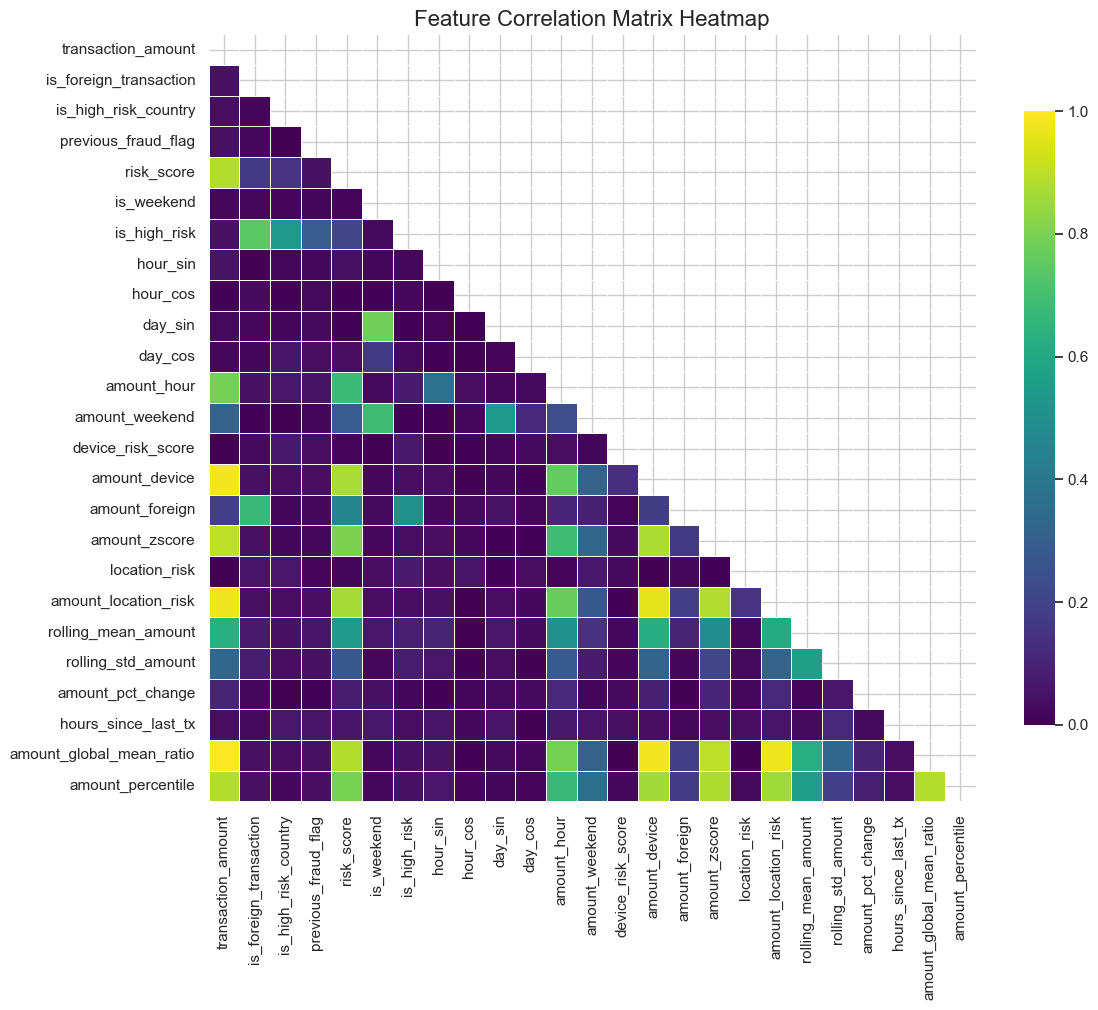


--- Top 15 Features by Correlation with Target Variable ---
is_high_risk                1.000000
is_foreign_transaction      0.746108
is_high_risk_country        0.541328
amount_foreign              0.503190
previous_fraud_flag         0.289552
risk_score                  0.207839
rolling_mean_amount         0.089146
rolling_std_amount          0.077686
location_risk               0.071465
amount_hour                 0.070399
device_risk_score           0.065279
amount_global_mean_ratio    0.046453
transaction_amount          0.046453
amount_percentile           0.046155
amount_device               0.038603
dtype: float64


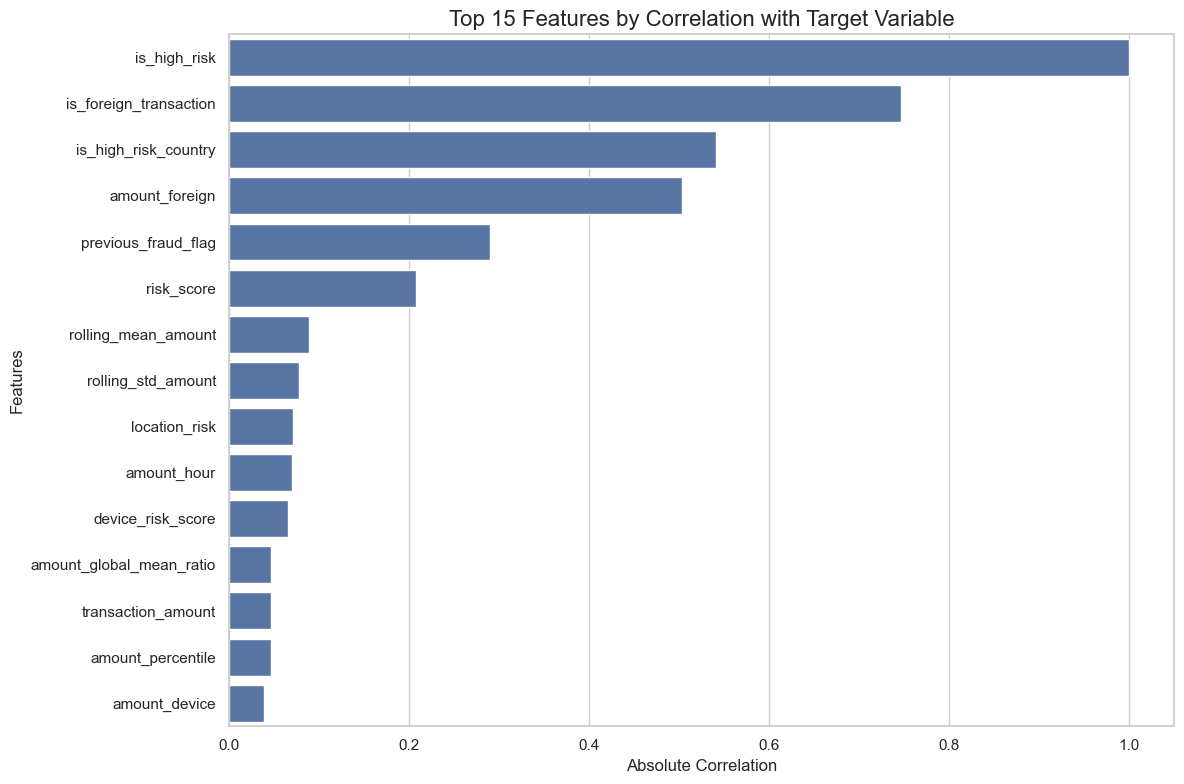

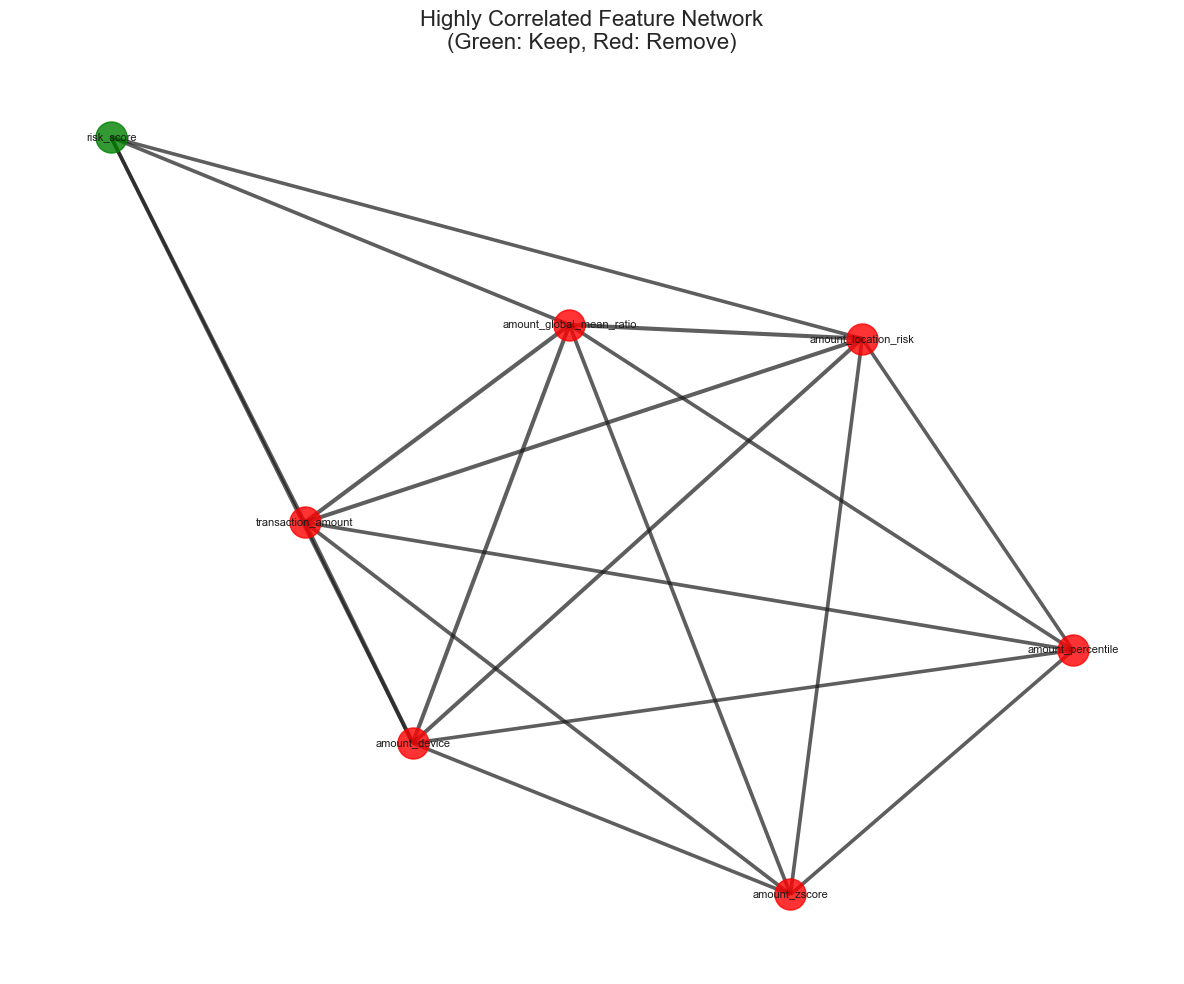


Found 19 highly correlated feature pairs (r > 0.85):
  - risk_score and transaction_amount: 0.884
  - amount_device and transaction_amount: 0.981
  - amount_device and risk_score: 0.871
  - amount_zscore and transaction_amount: 0.899
  - amount_zscore and amount_device: 0.874
  - amount_location_risk and transaction_amount: 0.976
  - amount_location_risk and risk_score: 0.865
  - amount_location_risk and amount_device: 0.959
  - amount_location_risk and amount_zscore: 0.881
  - amount_global_mean_ratio and transaction_amount: 1.000
  - ... and 9 more pairs

Features to drop due to high correlation: 6

Top 10 features dropped and reasons:
  1. transaction_amount: Removed due to high correlation with amount_global_mean_ratio (r=1.000), which has stronger correlation with target (0.046 vs 0.046)
  2. amount_device: Removed due to high correlation with amount_percentile (r=0.861), which has stronger correlation with target (0.046 vs 0.039)
  3. amount_zscore: Removed due to high correlati

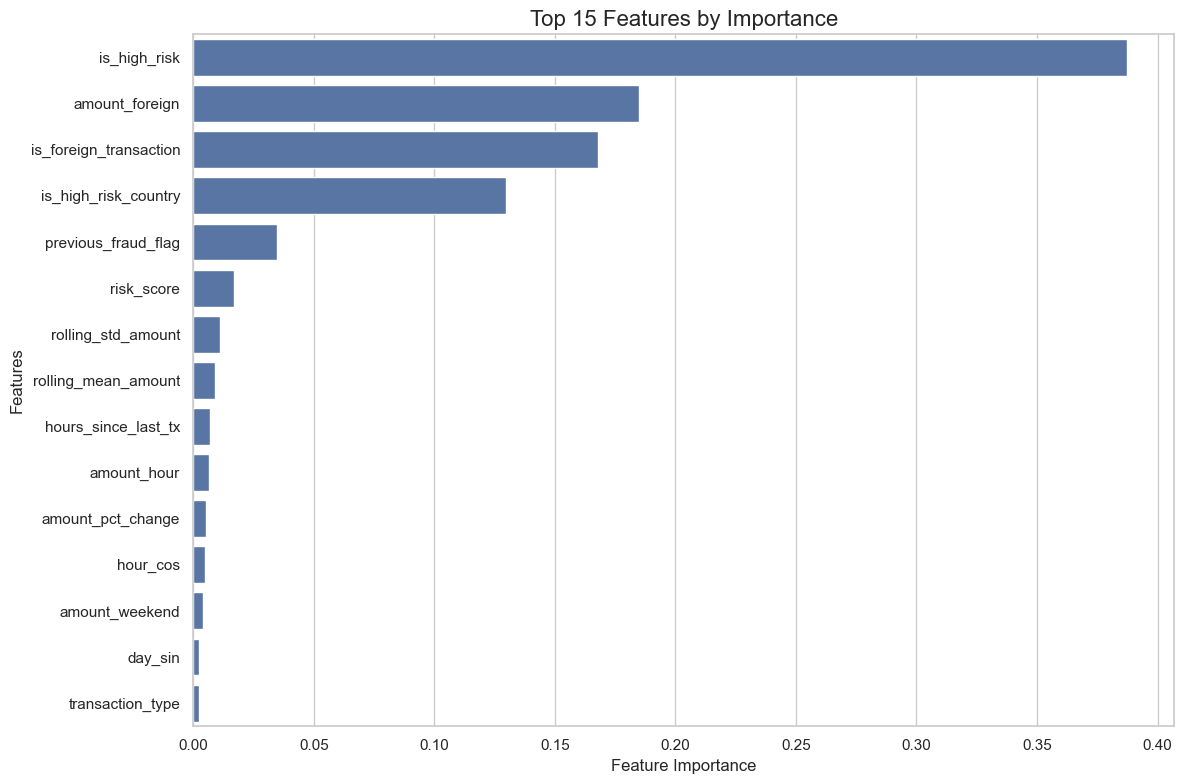

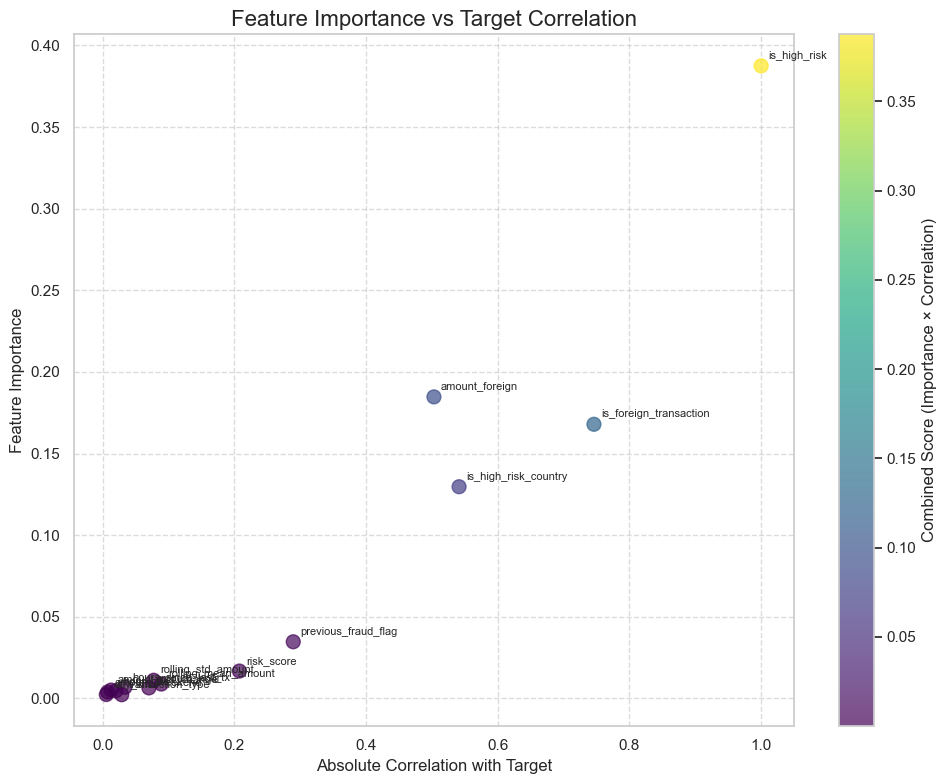


Option 1: Top 20 features selected
Option 2: 10 features selected (covering 95.0% of total importance)


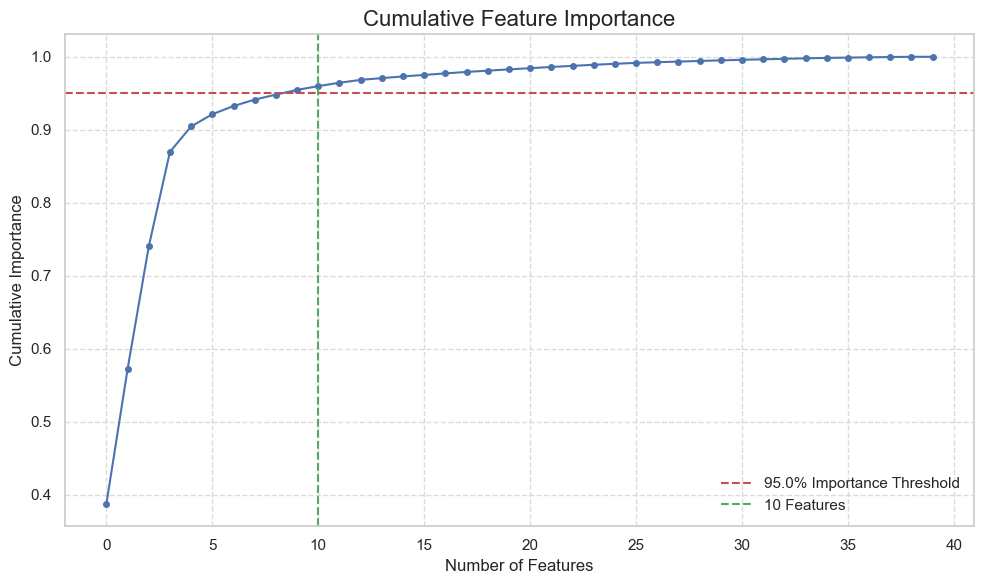


Selected 10 features based on cumulative importance
Removing 1 feature(s) with perfect correlation to target:
  - is_high_risk: correlation = 1.000 (identical to label_code → dropped due to leakage)

Final number of features for modeling: 9
Top final features: ['amount_foreign', 'is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag', 'risk_score', 'rolling_std_amount', 'rolling_mean_amount', 'hours_since_last_tx', 'amount_hour'] 


In [62]:
# Feature Selection and Dimensionality Reduction
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("Performing feature selection and dimensionality reduction...")

# 1. Handle remaining missing values in engineered features
# Identify categorical columns needing special handling
categorical_cols = df_featured.select_dtypes(include=['category']).columns.tolist()
print(f"Found {len(categorical_cols)} categorical columns that need special handling")

# Handle missing values separately for categorical and non-categorical columns
if categorical_cols:
    # Fill categorical columns with the most frequent value
    for col in categorical_cols:
        if df_featured[col].isna().any():
            most_frequent = df_featured[col].value_counts().index[0]
            df_featured[col] = df_featured[col].fillna(most_frequent)
    
    # Fill remaining non-categorical columns with 0
    non_categorical = [col for col in df_featured.columns if col not in categorical_cols]
    df_featured[non_categorical] = df_featured[non_categorical].fillna(0)
else:
    # If no categorical columns, fill everything with 0
    df_featured = df_featured.fillna(0)

print("Missing values handled successfully")

# 2. Identify and exclude non-predictive columns
# Identifiers should definitely be excluded because they cause overfitting and don't generalize
id_columns = [col for col in df_featured.columns if 'id' in col.lower() and col != 'label_code']
print(f"Removing identifier columns: {id_columns}")

# Timestamp columns should be excluded as their components have been extracted
timestamp_cols = []
if 'transaction_time' in df_featured.columns and 'hour' in df_featured.columns:
    timestamp_cols = ['transaction_time']
    print(f"Removing raw timestamp columns: {timestamp_cols}")

# 3. Exclude redundant temporal features, keeping engineered versions
redundant_temporal = []
if 'hour_sin' in df_featured.columns and 'hour_cos' in df_featured.columns and 'hour' in df_featured.columns:
    redundant_temporal.append('hour')  # Remove raw hour as we have cyclical encoding
if 'day_sin' in df_featured.columns and 'day_cos' in df_featured.columns and 'day_of_week_num' in df_featured.columns:
    redundant_temporal.append('day_of_week_num')  # Remove raw day as we have cyclical encoding
print(f"Removing redundant temporal features: {redundant_temporal}")

# Combine all columns to exclude
exclude_cols = id_columns + timestamp_cols + redundant_temporal

# 4. Get remaining features (excluding target variable and excluded columns)
feature_cols = [col for col in df_featured.columns if col != 'label_code' and col not in exclude_cols]
print(f"Initial feature set: {len(feature_cols)} features")

# 5. Analyze feature correlation to identify highly correlated features
print("\n--- Correlation Analysis ---")
# Filter to numeric columns only for correlation analysis
numeric_features = [f for f in feature_cols if df_featured[f].dtype in ['int64', 'float64']]
print(f"Analyzing correlations among {len(numeric_features)} numeric features")

# Calculate correlation matrix
correlation_matrix = df_featured[numeric_features].corr().abs()

# Visualize correlation matrix with heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create mask for upper triangle
heatmap = sns.heatmap(correlation_matrix, 
                       mask=mask,
                       cmap='viridis', 
                       vmin=0, 
                       vmax=1, 
                       center=0.5,
                       square=True, 
                       linewidths=0.5, 
                       annot=False,
                       cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate and visualize correlation with target variable
target_correlations = df_featured[numeric_features].corrwith(df_featured['label_code']).abs().sort_values(ascending=False)
print("\n--- Top 15 Features by Correlation with Target Variable ---")
print(target_correlations.head(15))

# Plot top correlations with target
plt.figure(figsize=(12, 8))
top_target_correlations = target_correlations.head(15)
sns.barplot(x=top_target_correlations.values, y=top_target_correlations.index)
plt.title('Top 15 Features by Correlation with Target Variable', fontsize=16)
plt.xlabel('Absolute Correlation', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (above threshold)
correlation_threshold = 0.85
high_corr_pairs = []
high_corr_features_to_drop = set()
high_corr_features_to_keep = set()
feature_removal_reasons = {}  # To track why each feature was dropped

# Upper triangular matrix iteration (avoid duplicate pairs)
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            corr = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((col_i, col_j, corr))
            
            # Strategy: Keep the one that has higher correlation with target
            if 'label_code' in df_featured.columns:
                corr_i_target = abs(df_featured[col_i].corr(df_featured['label_code']))
                corr_j_target = abs(df_featured[col_j].corr(df_featured['label_code']))
                
                if corr_j_target <= corr_i_target:
                    drop_feature = col_j
                    keep_feature = col_i
                    reason = f"Removed due to high correlation with {keep_feature} (r={corr:.3f}), which has stronger correlation with target ({corr_i_target:.3f} vs {corr_j_target:.3f})"
                else:
                    drop_feature = col_i
                    keep_feature = col_j
                    reason = f"Removed due to high correlation with {keep_feature} (r={corr:.3f}), which has stronger correlation with target ({corr_j_target:.3f} vs {corr_i_target:.3f})"
                
                # Add the features and reason
                high_corr_features_to_drop.add(drop_feature)
                high_corr_features_to_keep.add(keep_feature)
                feature_removal_reasons[drop_feature] = reason
            else:
                # If no target column, then second feature will be dropped by default
                drop_feature = col_j
                high_corr_features_to_drop.add(drop_feature)
                feature_removal_reasons[drop_feature] = f"Removed due to high correlation with {col_i} (r={corr:.3f}), using default strategy (keep first feature)"

# Network graph of highly correlated features
if high_corr_pairs and len(high_corr_pairs) > 1:
    try:
        import networkx as nx
        
        # Create network graph of highly correlated features
        plt.figure(figsize=(12, 10))
        G = nx.Graph()
        
        # Add edges for highly correlated feature pairs
        for col_i, col_j, corr in high_corr_pairs:
            G.add_edge(col_i, col_j, weight=corr)
            
        # Add nodes for features to be kept and dropped
        for node in G.nodes():
            if node in high_corr_features_to_drop:
                G.nodes[node]['status'] = 'drop'
            elif node in high_corr_features_to_keep:
                G.nodes[node]['status'] = 'keep'
            else:
                G.nodes[node]['status'] = 'unknown'
        
        # Set positions and draw
        pos = nx.spring_layout(G, k=0.4)
        
        # Draw nodes with different colors
        keep_nodes = [n for n in G.nodes() if G.nodes[n]['status'] == 'keep']
        drop_nodes = [n for n in G.nodes() if G.nodes[n]['status'] == 'drop']
        
        nx.draw_networkx_nodes(G, pos, nodelist=keep_nodes, node_color='green', node_size=500, alpha=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=drop_nodes, node_color='red', node_size=500, alpha=0.8)
        
        # Draw edges with varying thickness based on correlation
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=[w * 3 for w in edge_weights], alpha=0.7)
        
        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=8)
        
        plt.title('Highly Correlated Feature Network\n(Green: Keep, Red: Remove)', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("NetworkX library not available - skipping correlation network visualization")

# Print information about highly correlated features
if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs (r > {correlation_threshold}):")
    for col_i, col_j, corr in high_corr_pairs[:10]:  # Show top 10 pairs
        print(f"  - {col_i} and {col_j}: {corr:.3f}")
    if len(high_corr_pairs) > 10:
        print(f"  - ... and {len(high_corr_pairs) - 10} more pairs")
    
    print(f"\nFeatures to drop due to high correlation: {len(high_corr_features_to_drop)}")
    print("\nTop 10 features dropped and reasons:")
    for i, (feature, reason) in enumerate(list(feature_removal_reasons.items())[:10], 1):
        print(f"  {i}. {feature}: {reason}")
    if len(feature_removal_reasons) > 10:
        print(f"  ... and {len(feature_removal_reasons) - 10} more features")

# Update feature list to remove highly correlated features
feature_cols = [f for f in feature_cols if f not in high_corr_features_to_drop]
print(f"\nFeature set after correlation analysis: {len(feature_cols)} features")

# 6. Feature Importance Analysis with Random Forest
print("\n--- Feature Importance Analysis ---")
# Prepare data for feature importance
X_importance = df_featured[feature_cols].copy()  # Using copy to avoid modifying original data
y = df_featured['label_code']

# Handle categorical features - convert to numeric for RandomForest
object_and_category_cols = X_importance.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Converting {len(object_and_category_cols)} categorical/object columns for analysis")

# Use label encoding for categorical features 
for col in object_and_category_cols:
    # Converting to string first to handle any category type issues
    X_importance[col] = X_importance[col].astype(str)
    # Then converting to category codes (simple label encoding)
    X_importance[col] = X_importance[col].astype('category').cat.codes

# Verify all columns to numeric are properly converted
if not X_importance.select_dtypes(include=['object', 'category']).columns.tolist():
    print("All features successfully converted to numeric format for analysis")
else:
    remaining_cats = X_importance.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Warning: {len(remaining_cats)} columns still non-numeric: {remaining_cats}")
    # Drop any remaining non-numeric columns as a fallback
    X_importance = X_importance.select_dtypes(exclude=['object', 'category'])

# Train a Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_importance, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_importance.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# VISUALIZATION 4: Plot top 15 features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Features by Importance', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Combine feature importance with target correlation
# Create a DataFrame with both metrics
combined_metrics = pd.DataFrame({
    'feature': X_importance.columns,
    'importance': rf.feature_importances_,
})

# Add target correlation (only for numeric features)
for feature in combined_metrics['feature']:
    if feature in numeric_features:
        combined_metrics.loc[combined_metrics['feature'] == feature, 'target_correlation'] = abs(df_featured[feature].corr(df_featured['label_code']))
    else:
        # For categorical features encoded as numeric, correlation will be calculated with their encoded versions
        combined_metrics.loc[combined_metrics['feature'] == feature, 'target_correlation'] = abs(X_importance[feature].corr(y))

# Sort by importance and show top features
combined_metrics = combined_metrics.sort_values('importance', ascending=False).head(15)

# Create a scatter plot comparing importance vs correlation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    combined_metrics['target_correlation'], 
    combined_metrics['importance'],
    s=100,  # size of points
    alpha=0.7,
    c=combined_metrics['importance'] * combined_metrics['target_correlation'],  # color by combined score
    cmap='viridis'
)
plt.colorbar(scatter, label='Combined Score (Importance × Correlation)')

# Add feature labels to the points
for i, feature in enumerate(combined_metrics['feature']):
    plt.annotate(
        feature,
        (combined_metrics['target_correlation'].iloc[i], combined_metrics['importance'].iloc[i]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )

plt.title('Feature Importance vs Target Correlation', fontsize=16)
plt.xlabel('Absolute Correlation with Target', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 7. Feature Selection based on importance
# Option 1: Keep top N features
top_n = 20  
top_features = feature_importances['feature'][:top_n].tolist()

# Option 2: Keep features that account for X% of cumulative importance
cumulative_importance = feature_importances['importance'].cumsum() / feature_importances['importance'].sum()
importance_threshold = 0.95  # Keep features that account for 95% of importance
n_features_to_keep = np.argmax(cumulative_importance >= importance_threshold) + 1
cumulative_top_features = feature_importances['feature'][:n_features_to_keep].tolist()

print(f"\nOption 1: Top {top_n} features selected")
print(f"Option 2: {n_features_to_keep} features selected (covering {importance_threshold*100}% of total importance)")

# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_importance.values, marker='o', markersize=4)
plt.axhline(y=importance_threshold, color='r', linestyle='--', label=f'{importance_threshold*100}% Importance Threshold')
plt.axvline(x=n_features_to_keep, color='g', linestyle='--', label=f'{n_features_to_keep} Features')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Choosing selected features to use based on X% of cumulative importance
selected_features = cumulative_top_features
print(f"\nSelected {len(selected_features)} features based on cumulative importance")

# Drop any 100%-correlated features to avoid leakage ---
perfect_corr_feats = [
    f for f in selected_features
    if abs(df_featured[f].corr(df_featured['label_code'])) == 1.0
]
if perfect_corr_feats:
    print(f"Removing {len(perfect_corr_feats)} feature(s) with perfect correlation to target:")
    for feat in perfect_corr_feats:
        corr_val = df_featured[feat].corr(df_featured['label_code'])
        print(f"  - {feat}: correlation = {corr_val:.3f} (identical to label_code → dropped due to leakage)")
    # actually remove them
    selected_features = [f for f in selected_features if f not in perfect_corr_feats]
else:
    print("No perfectly correlated features found.")

# # 8. Additional Dimensionality Reduction with PCA 

# print("\n--- PCA Dimensionality Reduction ---")
# # Standardize data for PCA
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_importance[selected_features])

# # Apply PCA
# pca = PCA(n_components=0.95)  # Retain 95% of variance
# X_pca = pca.fit_transform(X_scaled)

# pca_selected_features = [f"PC{i+1}" for i in range(X_pca.shape[1])]


# print(f"Reduced dimensions from {len(selected_features)} to {X_pca.shape[1]} with PCA")
# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# # Plot explained variance
# plt.figure(figsize=(10, 6))
# plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.axhline(y=0.95, color='r', linestyle='-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by Components')
# plt.show()


# 9. Final feature list for modeling
final_feature_cols = selected_features
# final_feature_cols = pca_selected_features
print(f"\nFinal number of features for modeling: {len(final_feature_cols)}")
print("Top final features:", final_feature_cols[:10], "..." if len(final_feature_cols) > 10 else "")

# Store final feature list
feature_cols = final_feature_cols

In [63]:
# Create X and y for modeling
X = df_featured[feature_cols]
y = df_featured['label_code']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (1000, 9)
Target vector shape: (1000,)


## 7. Target Variable Analysis and Imbalance Strategy

Analyzing the target variable (`label_code`) in more detail and implement appropriate strategies to handle any class imbalance that exists in the data.

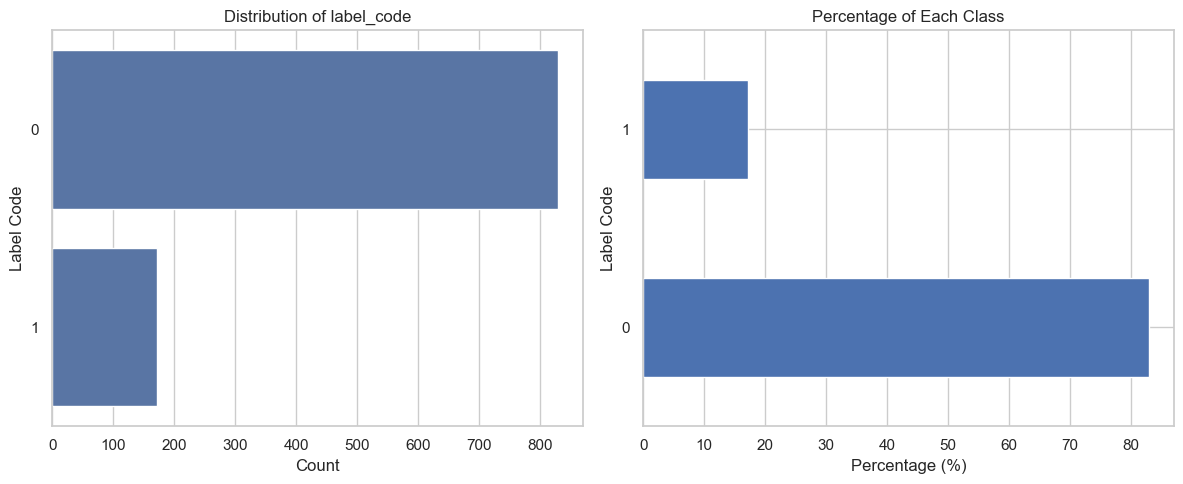

Number of unique classes in target variable: 2
Binary classification task detected
Majority class (0): 829 samples (82.90%)
Minority class (1): 171 samples (17.10%)
Class imbalance ratio: 4.85:1

Moderate class imbalance detected. Will use appropriate evaluation metrics and sampling techniques.


In [79]:
# Analyze target variable distribution in more detail
plt.figure(figsize=(12, 5))

# Plot distribution of target variable
plt.subplot(1, 2, 1)
sns.countplot(y=y)
plt.title('Distribution of label_code')
plt.xlabel('Count')
plt.ylabel('Label Code')

# Plot percentage of each class
plt.subplot(1, 2, 2)
y.value_counts(normalize=True).mul(100).plot(kind='barh')
plt.title('Percentage of Each Class')
plt.xlabel('Percentage (%)')
plt.ylabel('Label Code')
plt.tight_layout()
plt.show()

# Check if the target is binary or multi-class
num_classes = y.nunique()
print(f"Number of unique classes in target variable: {num_classes}")

if num_classes == 2:
    print("Binary classification task detected")
    
    # Check class imbalance ratio
    class_counts = y.value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
    
    print(f"Majority class ({majority_class}): {class_counts[majority_class]} samples ({class_counts[majority_class]/len(y)*100:.2f}%)")
    print(f"Minority class ({minority_class}): {class_counts[minority_class]} samples ({class_counts[minority_class]/len(y)*100:.2f}%)")
    print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")
    
    # Determine if class imbalance is severe (typically >10:1)
    imbalance_severe = imbalance_ratio > 10
    
    if imbalance_severe:
        print("\nSevere class imbalance detected. Implementing mitigation strategies...")
    else:
        print("\nModerate class imbalance detected. Will use appropriate evaluation metrics and sampling techniques.")
else:
    print(f"Multi-class classification task with {num_classes} classes")
    
    # For multi-class, we can check if any class is severely underrepresented
    class_percents = y.value_counts(normalize=True).mul(100)
    min_class_percent = class_percents.min()
    print(f"Smallest class represents {min_class_percent:.2f}% of the data")
    
    # If any class is less than 5%, we'll consider it imbalanced
    imbalance_severe = min_class_percent < 5
    
    if imbalance_severe:
        print("Some classes are severely underrepresented. Implementing mitigation strategies...")
    else:
        print("Class distribution is relatively balanced across multiple classes.")

In [80]:
# Set up train/test split before applying any sampling techniques
# This ensures that evaluation is on the original distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts(normalize=True).mul(100)}")
print(f"Test set class distribution:\n{y_test.value_counts(normalize=True).mul(100)}")

# Function to handle class imbalance using various strategies
def handle_class_imbalance(X_train, y_train, strategy='smote', sampling_ratio=None):
    """
    Apply various techniques to handle class imbalance.
    
    Parameters:
    X_train (DataFrame): Training features
    y_train (Series): Training target
    strategy (str): One of 'smote', 'adasyn', 'random_under', 'class_weight'
    sampling_ratio (float): Desired ratio of minority to majority class (used by SMOTE and undersampling)
    
    Returns:
    tuple: (X_resampled, y_resampled) or (X_train, y_train, class_weights)
    """
    if strategy == 'smote':
        print("Applying SMOTE to oversample minority class...")
        smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        print(f"Shape after SMOTE: {X_resampled.shape}")
        print(f"Class distribution after SMOTE:\n{pd.Series(y_resampled).value_counts(normalize=True).mul(100)}")
        return X_resampled, y_resampled
    
    elif strategy == 'adasyn':
        try:
            from imblearn.over_sampling import ADASYN
            print("Applying ADASYN to oversample minority class...")
            adasyn = ADASYN(sampling_strategy=sampling_ratio, random_state=42)
            X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
            print(f"Shape after ADASYN: {X_resampled.shape}")
            print(f"Class distribution after ADASYN:\n{pd.Series(y_resampled).value_counts(normalize=True).mul(100)}")
            return X_resampled, y_resampled
        except ImportError:
            print("ADASYN not available, falling back to SMOTE")
            return handle_class_imbalance(X_train, y_train, strategy='smote', sampling_ratio=sampling_ratio)
    
    elif strategy == 'random_under':
        print("Applying random undersampling to reduce majority class...")
        under_sampler = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
        X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)
        print(f"Shape after undersampling: {X_resampled.shape}")
        print(f"Class distribution after undersampling:\n{pd.Series(y_resampled).value_counts(normalize=True).mul(100)}")
        return X_resampled, y_resampled
    
    elif strategy == 'class_weight':
        print("Computing class weights for cost-sensitive learning...")
        # Calculate class weights inversely proportional to frequency
        class_counts = y_train.value_counts()
        total_samples = len(y_train)
        n_classes = len(class_counts)
        class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}
        print(f"Class weights: {class_weights}")
        return X_train, y_train, class_weights
    
    else:
        print(f"Unknown strategy: {strategy}. Using original data.")
        return X_train, y_train

# Determine if we need to apply imbalance handling techniques based on earlier analysis
need_imbalance_handling = True  # Set based on your earlier analysis

if need_imbalance_handling:
    if num_classes == 2:
        # Binary classification with imbalance
        # Using SMOTE to oversample the minority class
        X_train_resampled, y_train_resampled = handle_class_imbalance(
            X_train, y_train, strategy='smote', sampling_ratio=0.5)  # aim for 1:2 ratio
        
        # Also get class weights for models that support weighted learning
        _, _, class_weights = handle_class_imbalance(
            X_train, y_train, strategy='class_weight')
    else:
        # Multi-class with imbalance
        X_train_resampled, y_train_resampled = handle_class_imbalance(
            X_train, y_train, strategy='smote', sampling_ratio='auto')
        
        _, _, class_weights = handle_class_imbalance(
            X_train, y_train, strategy='class_weight')
else:
    # No severe imbalance, use original data
    X_train_resampled = X_train
    y_train_resampled = y_train
    class_weights = None

Training set shape: (800, 9), Test set shape: (200, 9)
Training set class distribution:
label_code
0    82.875
1    17.125
Name: proportion, dtype: float64
Test set class distribution:
label_code
0    83.0
1    17.0
Name: proportion, dtype: float64
Applying SMOTE to oversample minority class...
Shape after SMOTE: (994, 9)
Class distribution after SMOTE:
label_code
0    66.700201
1    33.299799
Name: proportion, dtype: float64
Computing class weights for cost-sensitive learning...
Class weights: {0: 0.6033182503770739, 1: 2.9197080291970803}


## 8. Model Selection and Training

Train several models using engineered features and handling of class imbalance. Different algorithms will be compared to find the best performing one for the fraud detection task.

In [84]:
# Define preprocessor for categorical and numerical features
# This will be used in the model pipeline
def create_preprocessor(X):
    """Create a column transformer to preprocess features"""
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'  # Include any columns not explicitly specified
    )
    
    return preprocessor

# Create preprocessor
preprocessor = create_preprocessor(X_train)

# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced' if class_weights is None else class_weights,
        random_state=42
    ),
    
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced' if class_weights is None else class_weights,
        random_state=42,
        n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'  # Prevents warning
    )
}

# Add LightGBM if available
try:
    models['LightGBM'] = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
except Exception as e:
    print(f"LightGBM not available: {e}")

print(f"Models to evaluate: {list(models.keys())}")

# Function to train a model with cross-validation and return results
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, preprocessor=None, cv=5):
    """
    Train a model with cross-validation and evaluate on test set.
    
    Parameters:
    model_name (str): Name of the model
    model: Model instance
    X_train, y_train: Training data
    X_test, y_test: Test data
    preprocessor: Feature preprocessor
    cv (int): Number of cross-validation folds
    
    Returns:
    dict: Performance metrics
    """
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Create pipeline with preprocessor
    if preprocessor is not None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else:
        pipeline = model
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Train on full training set
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    if len(np.unique(y_test)) == 2:  # Binary classification
        # For binary classification, we need to get the score for the positive class
        pos_label = 1  # Assuming 1 is the positive class
        y_score = y_pred_proba[:, 1]
        
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_score)
        
        # Precision-recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_score)
        pr_auc = auc(recall_curve, precision_curve)
    else:  # Multi-class
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # For multi-class, ROC-AUC is calculated in a one-vs-rest fashion
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            pr_auc = 0  # Not directly applicable for multi-class
        except:
            roc_auc = 0
            pr_auc = 0
            print("Could not calculate ROC-AUC for multi-class")
    
    training_time = time.time() - start_time
    
    # Store results
    results = {
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cv_scores_mean': cv_scores.mean(),
        'cv_scores_std': cv_scores.std(),
        'training_time': training_time
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    
    return results

Models to evaluate: ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


In [87]:
# Train and evaluate each model
results = {}

# There's a choice to use resampled data or original data with class weights
# Using resampled data for all models except those that handle
# class imbalance internally (like RandomForest and LogisticRegression with class_weight)
for model_name, model in models.items():
    # For models that support class weights, use original data
    if model_name in ['LogisticRegression', 'RandomForest']:
        results[model_name] = train_and_evaluate_model(
            model_name, model, X_train, y_train, X_test, y_test, preprocessor)
    # For other models, use resampled data
    else:
        results[model_name] = train_and_evaluate_model(
            model_name, model, X_train_resampled, y_train_resampled, X_test, y_test, preprocessor)

# Compile results into a DataFrame for comparison
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'PR-AUC': [results[m]['pr_auc'] for m in results],
    'CV ROC-AUC': [results[m]['cv_scores_mean'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
})

# Sort by F1 score (or another metric of choice)
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display results
results_df


Training LogisticRegression...
Cross-validation ROC-AUC: 0.9928 ± 0.0145
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000
PR-AUC: 1.0000
Training time: 0.05 seconds

Training RandomForest...
Cross-validation ROC-AUC: 0.9996 ± 0.0008
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000
PR-AUC: 1.0000
Training time: 0.58 seconds

Training GradientBoosting...
Cross-validation ROC-AUC: 0.9996 ± 0.0008
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000
PR-AUC: 1.0000
Training time: 0.58 seconds

Training GradientBoosting...
Cross-validation ROC-AUC: 0.9819 ± 0.0161
Accuracy: 0.9950
Precision: 0.9714
Recall: 1.0000
F1 Score: 0.9855
ROC-AUC: 1.0000
PR-AUC: 1.0000
Training time: 0.71 seconds

Training XGBoost...
Cross-validation ROC-AUC: 0.9819 ± 0.0161
Accuracy: 0.9950
Precision: 0.9714
Recall: 1.0000
F1 Score: 0.9855
ROC-AUC: 1.0000
PR-AUC: 1.0000
Training time: 0.71 seconds

Training XGBoost...


Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0  LogisticRegression     1.000   1.000000  1.000000  1.000000  1.000000   
1        RandomForest     1.000   1.000000  1.000000  1.000000  1.000000   
2    GradientBoosting     0.995   0.971429  1.000000  0.985507  1.000000   
3             XGBoost     0.995   1.000000  0.970588  0.985075  0.997342   
4            LightGBM     0.980   1.000000  0.882353  0.937500  0.983168   

     PR-AUC  CV ROC-AUC  Training Time (s)  
0  1.000000    0.992760           0.052430  
1  1.000000    0.999610           0.578728  
2  1.000000    0.981862           0.710728  
3  0.990903    0.972240           0.146391  
4  0.969199    0.969222           0.340236

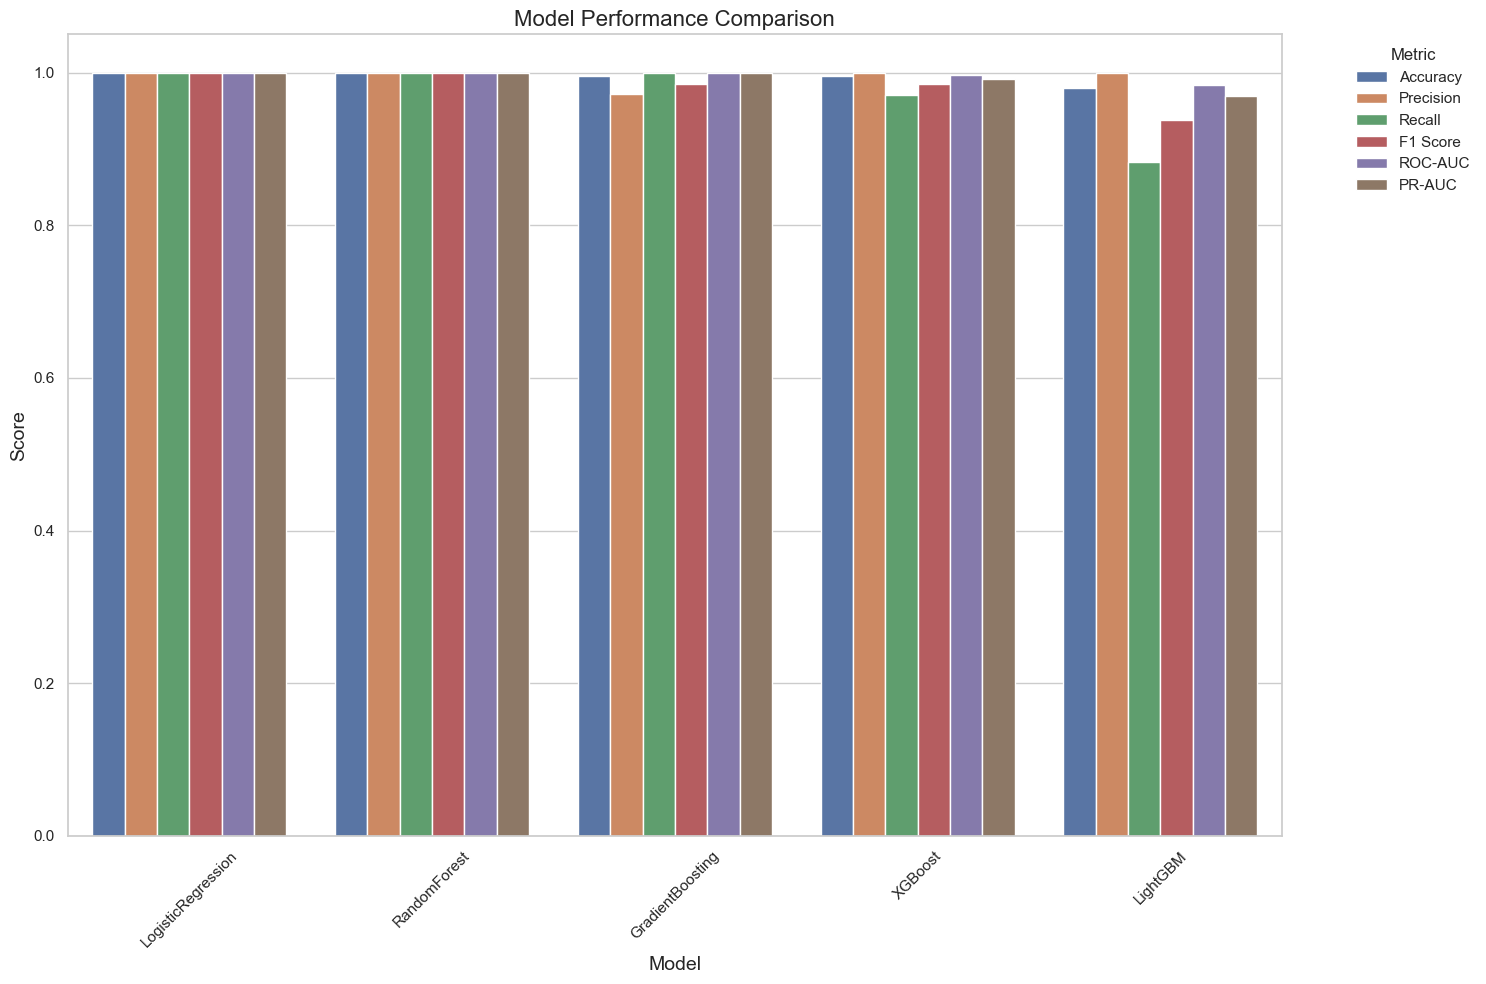

Best performing model: LogisticRegression


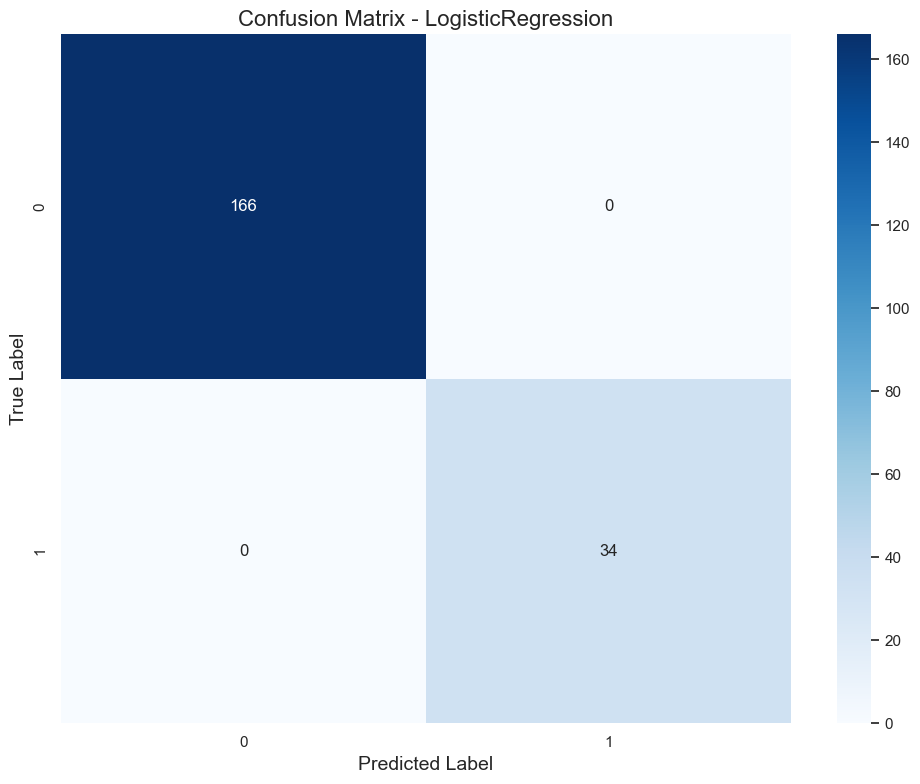

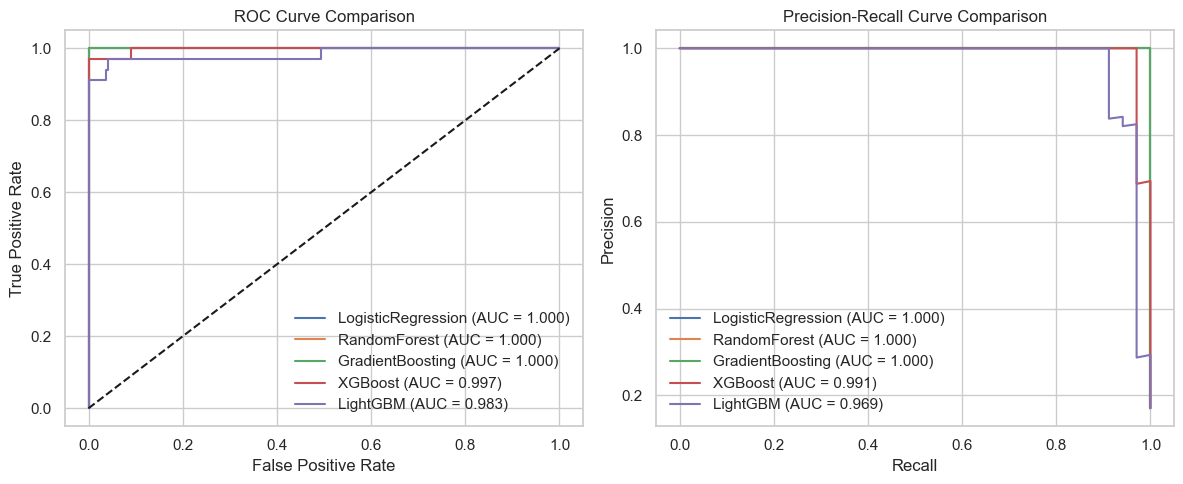

In [88]:
# Visualize model performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'PR-AUC']

# Create a bar chart to compare models across metrics
plt.figure(figsize=(15, 10))

# Reshape the data for easier plotting
model_names = results_df['Model'].tolist()
data = []
for metric in metrics:
    for model in model_names:
        row = results_df[results_df['Model'] == model]
        data.append({
            'Model': model,
            'Metric': metric,
            'Value': row[metric].values[0]
        })
performance_df = pd.DataFrame(data)

# Plot
sns.barplot(x='Model', y='Value', hue='Metric', data=performance_df)
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Identify the best performing model based on F1 score (or your preferred metric)
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"Best performing model: {best_model_name}")

# For the best model, plot confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# For binary classification, also plot ROC curve and PR curve
if len(np.unique(y_test)) == 2:
    # ROC Curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for model_name in results:
        model = results[model_name]['model']
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['roc_auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for model_name in results:
        model = results[model_name]['model']
        y_score = model.predict_proba(X_test)[:, 1]
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_score)
        plt.plot(recall_curve, precision_curve, label=f"{model_name} (AUC = {results[model_name]['pr_auc']:.3f})")
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

## 9. Model Evaluation

Now that we've trained multiple models, let's evaluate them in more detail to select the best one for deployment and understand its performance characteristics.

Detailed evaluation of the best performing model: LogisticRegression

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        34

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



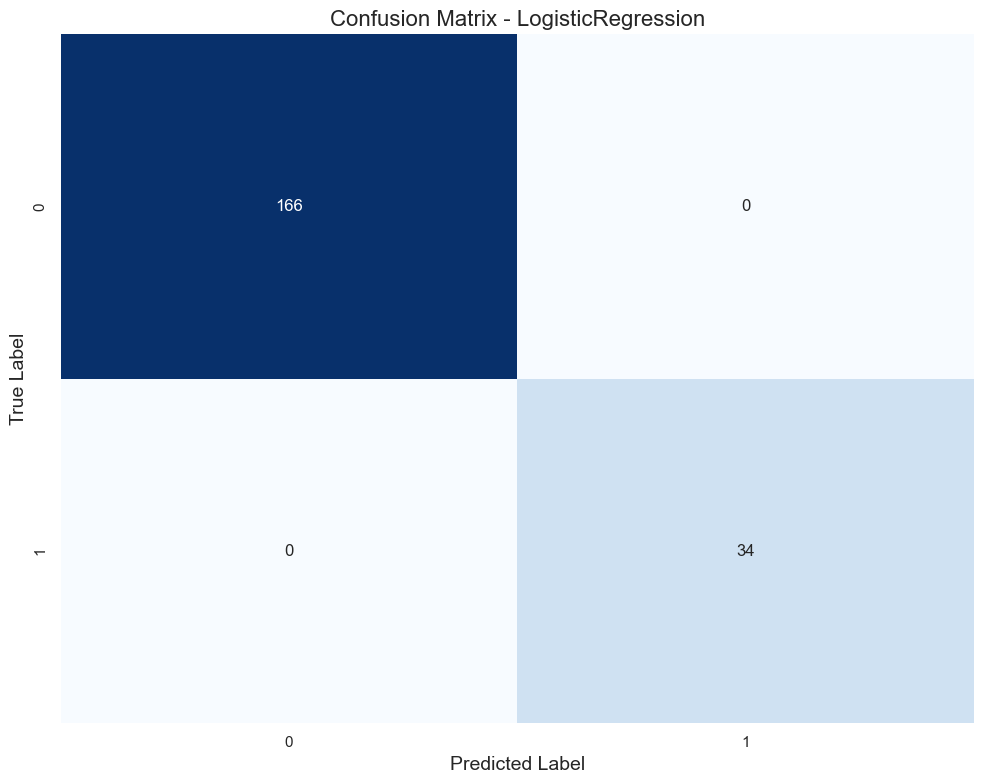

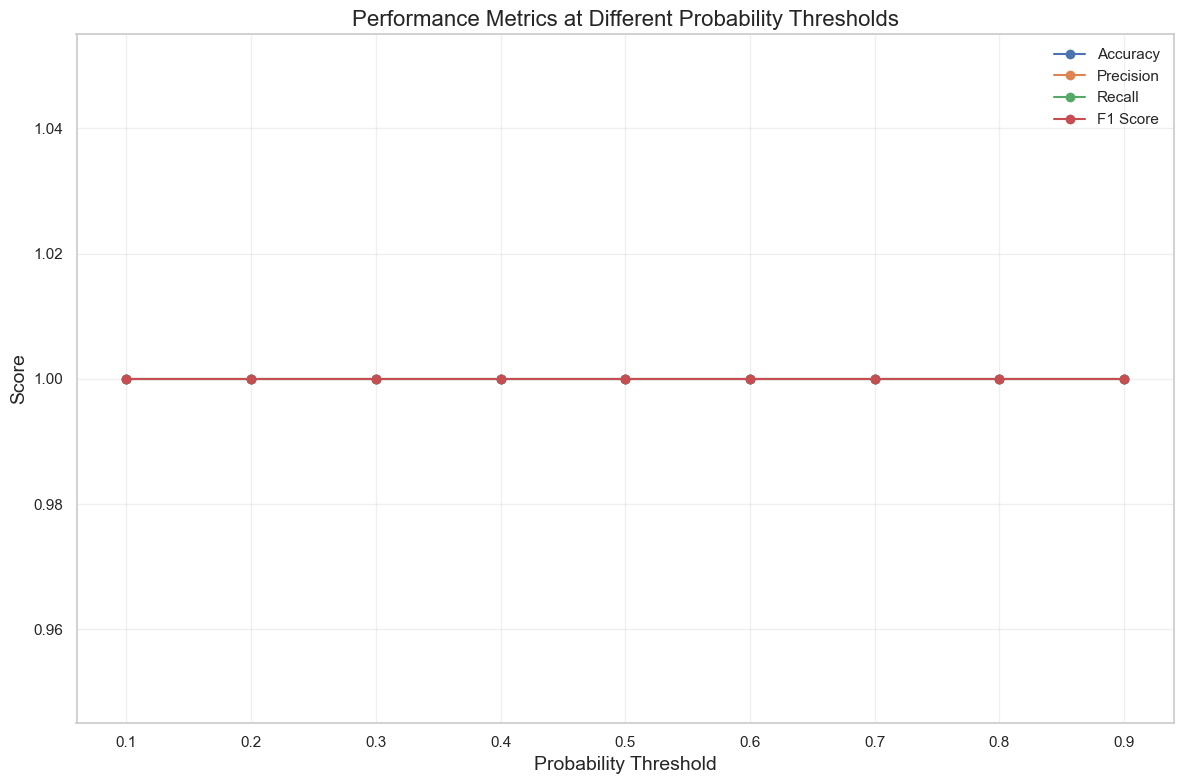

Optimal threshold for F1 score: 0.10
Metrics at optimal threshold:
- Accuracy: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- F1 Score: 1.0000

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00        34

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



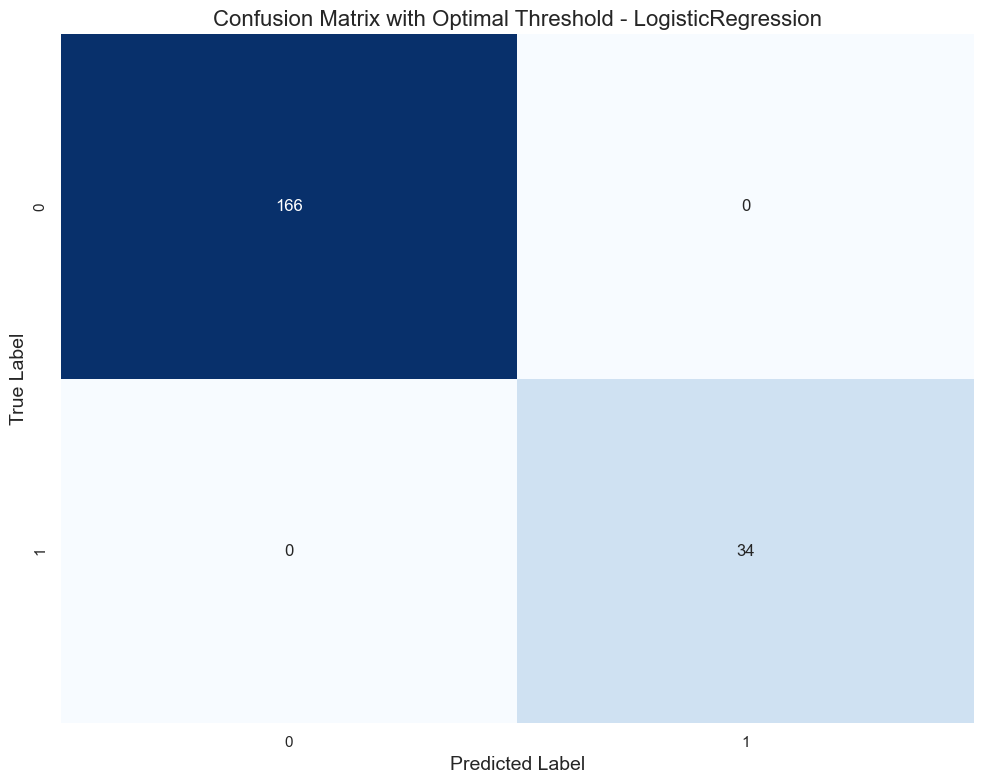

In [89]:
# Evaluate the best model in more detail
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"Detailed evaluation of the best performing model: {best_model_name}\n")

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Classification report with detailed metrics by class
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# For binary classification, analyze at different probability thresholds
if len(np.unique(y_test)) == 2:
    # Get probability scores for the positive class
    y_scores = y_pred_proba[:, 1]
    
    # Calculate metrics at different thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_metrics = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_scores >= threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred_thresh)
        precision = precision_score(y_test, y_pred_thresh, zero_division=0)
        recall = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        
        # Store results
        threshold_metrics.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    # Convert to DataFrame
    threshold_df = pd.DataFrame(threshold_metrics)
    
    # Plot metrics vs threshold
    plt.figure(figsize=(12, 8))
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
        plt.plot(threshold_df['Threshold'], threshold_df[metric], marker='o', label=metric)
    
    plt.title('Performance Metrics at Different Probability Thresholds', fontsize=16)
    plt.xlabel('Probability Threshold', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold for F1 score
    optimal_idx = threshold_df['F1 Score'].idxmax()
    optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']
    
    print(f"Optimal threshold for F1 score: {optimal_threshold:.2f}")
    print(f"Metrics at optimal threshold:")
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
        print(f"- {metric}: {threshold_df.loc[optimal_idx, metric]:.4f}")
        
    # Update predictions using optimal threshold
    y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))
    
    # Confusion matrix with optimal threshold
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix with Optimal Threshold - {best_model_name}', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()

False Positives: 9 (4.50%)
False Negatives: 7 (3.50%)
True Positives: 1 (0.50%)
True Negatives: 25 (12.50%)

Characteristics of False Positives (predicted fraud but actually legitimate):


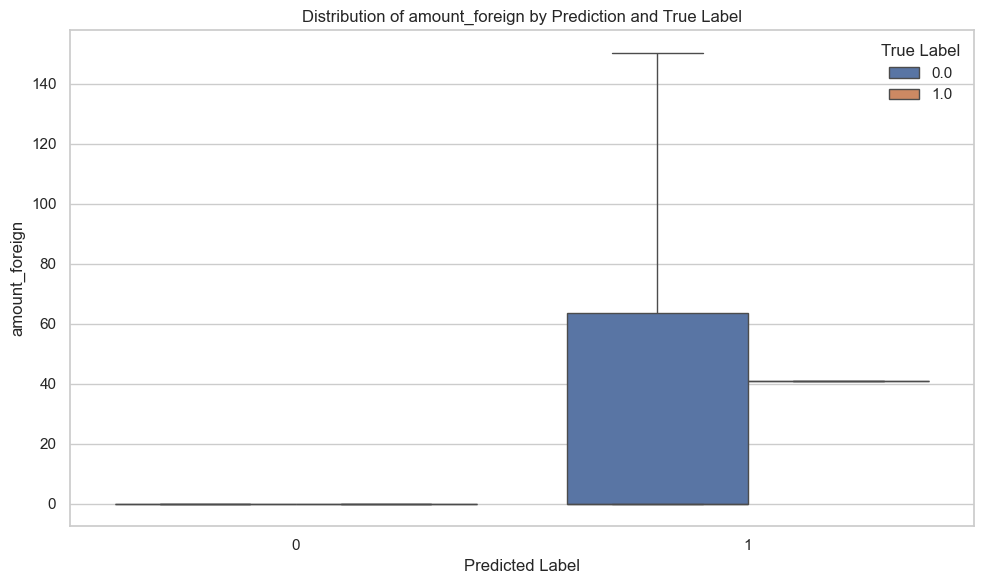

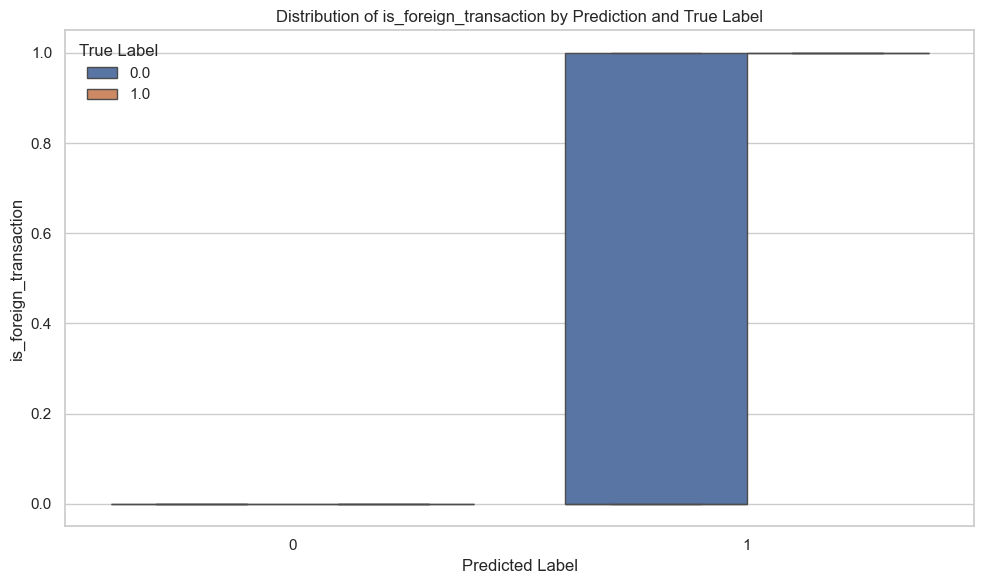

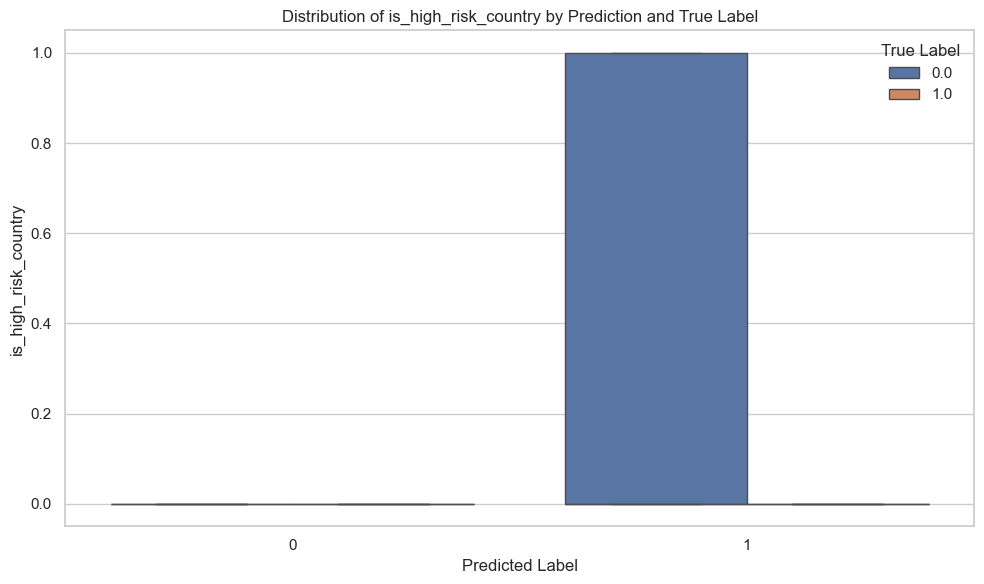

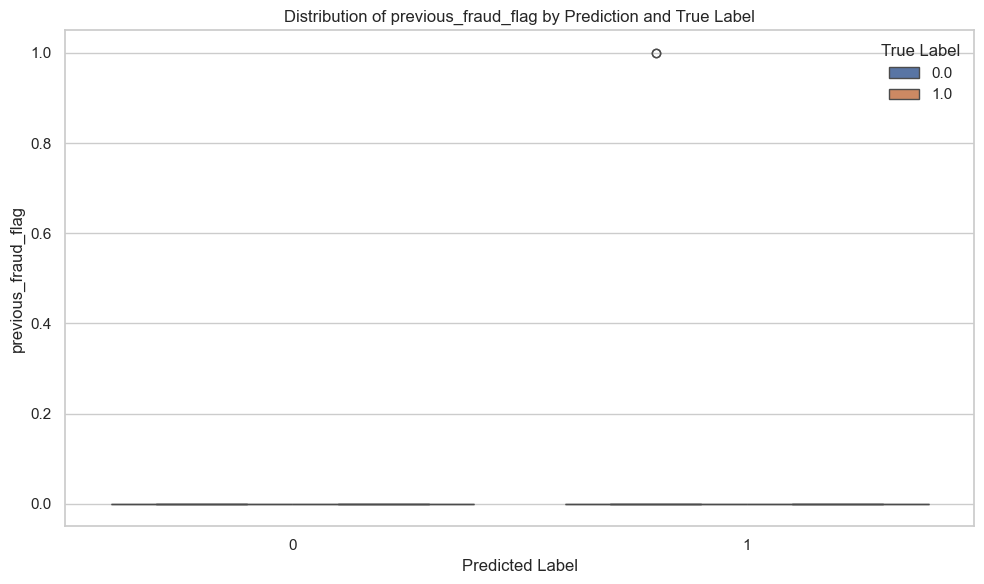

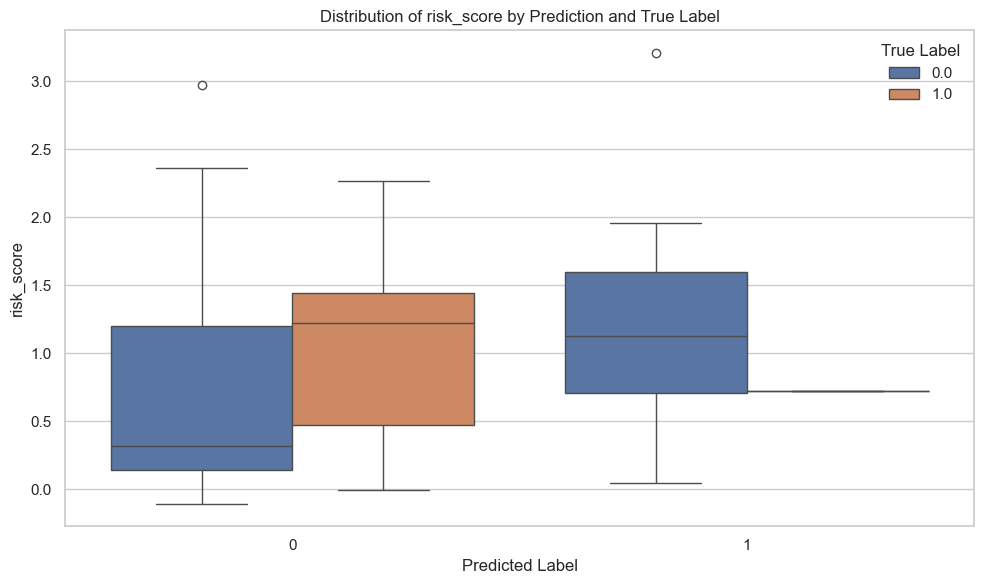


Average values for False Positives vs True Negatives:
                        False Positive Mean  True Negative Mean  Difference %
amount_foreign                    36.978586            0.000000           inf
is_foreign_transaction             0.444444            0.000000           inf
is_high_risk_country               0.333333            0.000000           inf
previous_fraud_flag                0.222222            0.000000           inf
risk_score                         1.247954            0.719951     73.338765

Characteristics of False Negatives (missed frauds):

Average values for False Negatives vs True Positives:
                        False Negative Mean  True Positive Mean  Difference %
amount_foreign                     0.000000           40.919960   -100.000000
is_foreign_transaction             0.000000            1.000000   -100.000000
is_high_risk_country               0.000000            0.000000           NaN
previous_fraud_flag                0.000000            0.

In [90]:
# Analyze false positives and false negatives
# This helps understand model error patterns

# Get false positives and false negatives
if len(np.unique(y_test)) == 2:
    # Use optimal threshold if defined
    if 'optimal_threshold' in locals():
        y_pred_analysis = (y_scores >= optimal_threshold).astype(int)
    else:
        y_pred_analysis = y_pred
        
    # Create a DataFrame with test data and predictions for analysis
    analysis_df = X_test.copy()
    analysis_df['true_label'] = y_test.reset_index(drop=True)
    analysis_df['predicted'] = y_pred_analysis
    analysis_df['prob_fraud'] = y_scores  # Probability of fraud
    
    # Identify false positives and false negatives
    false_positives = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted'] == 1)]
    false_negatives = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted'] == 0)]
    true_positives = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted'] == 1)]
    true_negatives = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted'] == 0)]
    
    print(f"False Positives: {len(false_positives)} ({len(false_positives) / len(analysis_df) * 100:.2f}%)")
    print(f"False Negatives: {len(false_negatives)} ({len(false_negatives) / len(analysis_df) * 100:.2f}%)")
    print(f"True Positives: {len(true_positives)} ({len(true_positives) / len(analysis_df) * 100:.2f}%)")
    print(f"True Negatives: {len(true_negatives)} ({len(true_negatives) / len(analysis_df) * 100:.2f}%)")
    
    # Analyze characteristics of false positives
    if len(false_positives) > 0:
        print("\nCharacteristics of False Positives (predicted fraud but actually legitimate):")
        
        # Select a few numerical features to analyze
        numerical_features = X_test.select_dtypes(include=['int64', 'float64']).columns[:5]  # Limit to first 5 for brevity
        
        for feature in numerical_features:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='predicted', y=feature, hue='true_label', data=analysis_df)
            plt.title(f'Distribution of {feature} by Prediction and True Label')
            plt.xlabel('Predicted Label')
            plt.ylabel(feature)
            plt.legend(title='True Label')
            plt.tight_layout()
            plt.show()
        
        # For more insights, we could also look at average values
        print("\nAverage values for False Positives vs True Negatives:")
        fp_tn_comparison = pd.DataFrame({
            'False Positive Mean': false_positives[numerical_features].mean(),
            'True Negative Mean': true_negatives[numerical_features].mean(),
            'Difference %': (false_positives[numerical_features].mean() - true_negatives[numerical_features].mean()) / true_negatives[numerical_features].mean() * 100
        })
        print(fp_tn_comparison)
    
    # Analyze characteristics of false negatives
    if len(false_negatives) > 0:
        print("\nCharacteristics of False Negatives (missed frauds):")
        
        # For more insights, look at average values
        print("\nAverage values for False Negatives vs True Positives:")
        fn_tp_comparison = pd.DataFrame({
            'False Negative Mean': false_negatives[numerical_features].mean(),
            'True Positive Mean': true_positives[numerical_features].mean(),
            'Difference %': (false_negatives[numerical_features].mean() - true_positives[numerical_features].mean()) / true_positives[numerical_features].mean() * 100
        })
        print(fn_tp_comparison)
else:
    print("Detailed false positive/negative analysis only implemented for binary classification.")

## 10. Model Explainability with SHAP

To understand how our model makes decisions, we'll use SHAP (SHapley Additive exPlanations) values to explain individual predictions and identify the most important features for fraud detection.

Generating feature importance with direct feature mapping...
Transformed data shape: (200, 9)
Original features (9): amount_foreign, is_foreign_transaction, is_high_risk_country, previous_fraud_flag, risk_score...
Mapped features (9): amount_foreign, is_foreign_transaction, is_high_risk_country, previous_fraud_flag, risk_score...
Using permutation importance for feature importance...


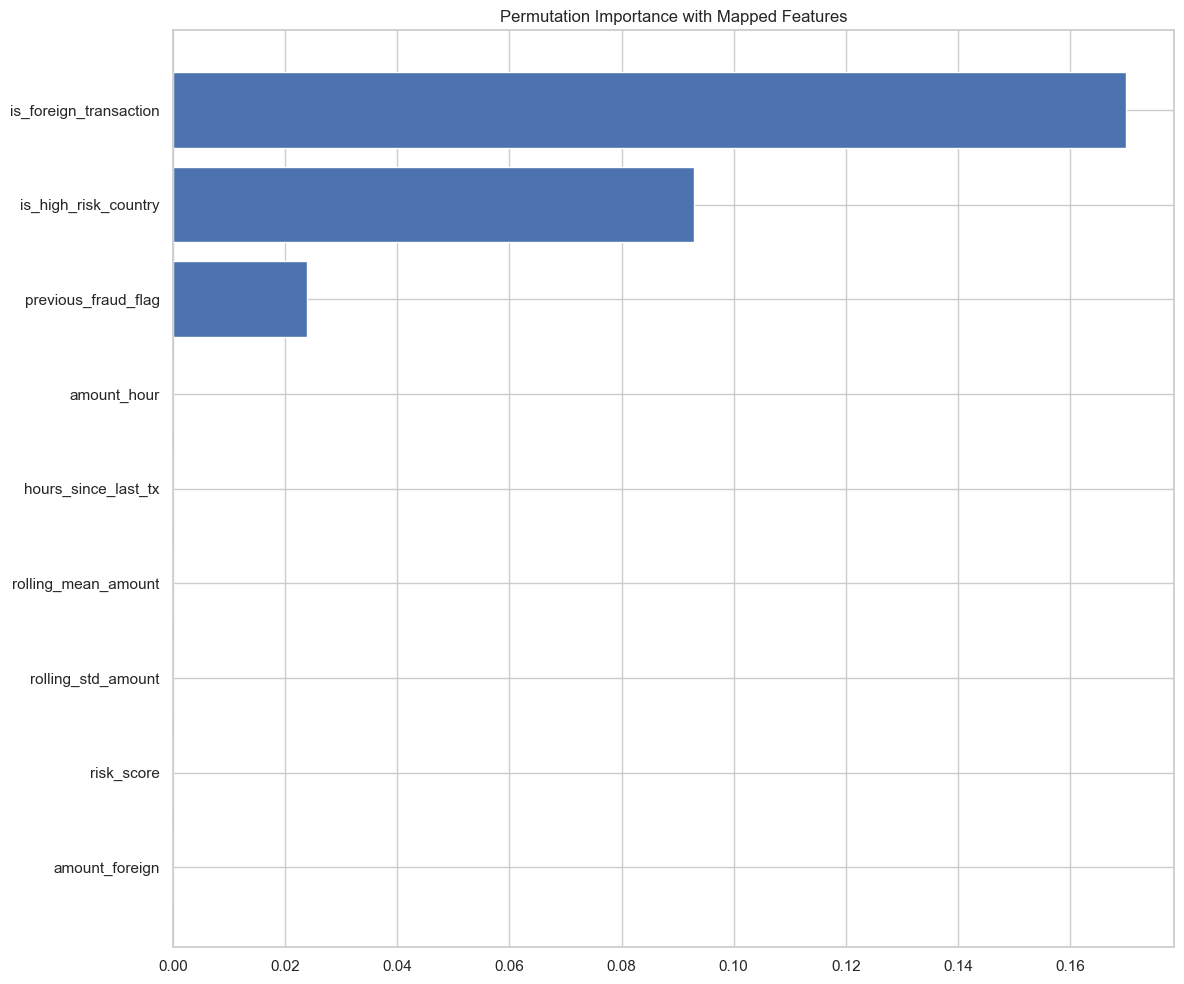

Using model coefficients for feature importance...


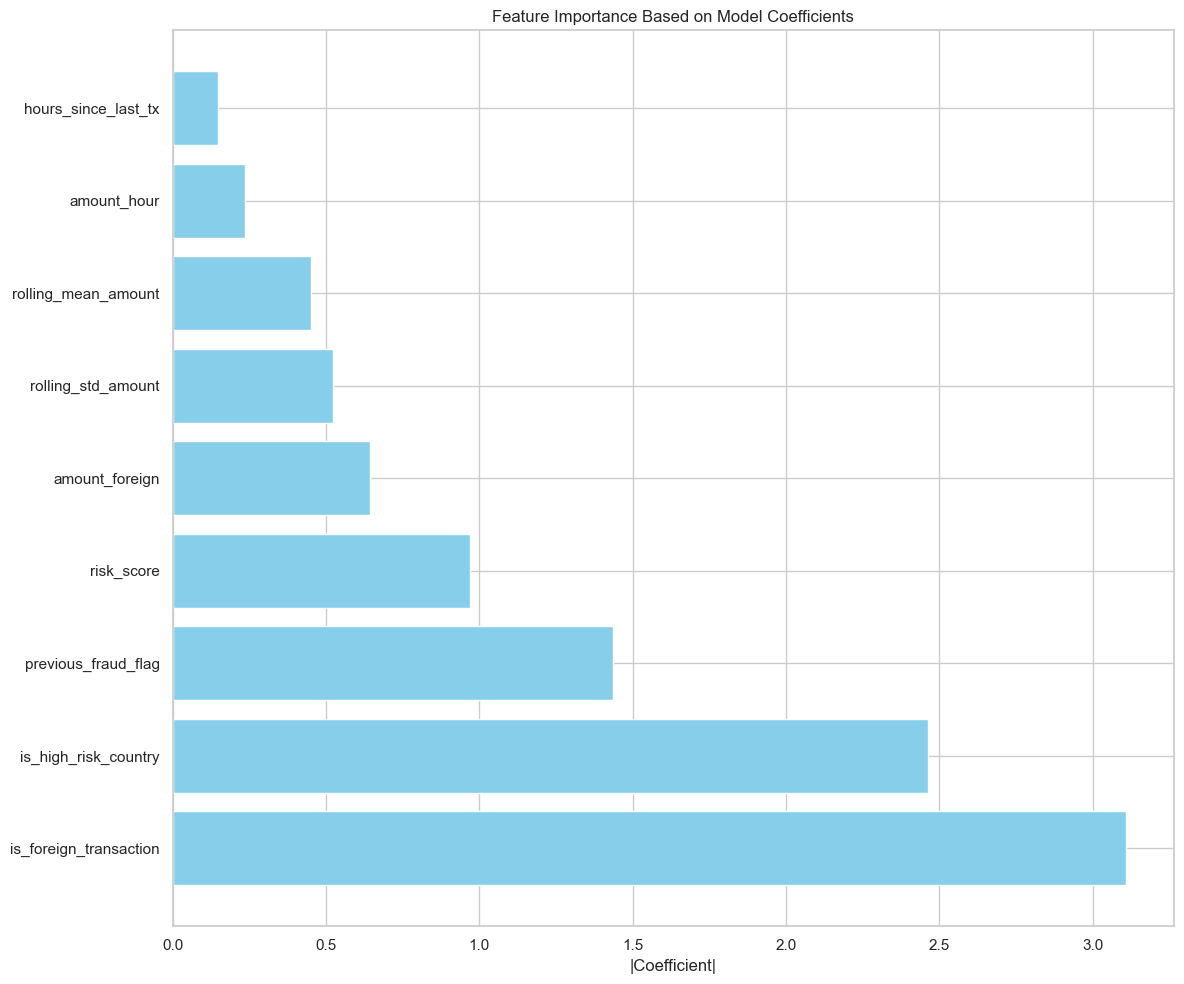

Top Features by Coefficient Importance:


Feature  Original_Index  Importance
1  is_foreign_transaction               1    3.110254
2    is_high_risk_country               2    2.464578
3     previous_fraud_flag               3    1.435536
4              risk_score               4    0.969256
0          amount_foreign               0    0.644052
5      rolling_std_amount               5    0.523861
6     rolling_mean_amount               6    0.451566
8             amount_hour               8    0.233979
7     hours_since_last_tx               7    0.148335


Feature Mapping Table:


Original_Feature  Transformed_Feature_Index             Mapped_Name
0          amount_foreign                          0          amount_foreign
1  is_foreign_transaction                          1  is_foreign_transaction
2    is_high_risk_country                          2    is_high_risk_country
3     previous_fraud_flag                          3     previous_fraud_flag
4              risk_score                          4              risk_score
5      rolling_std_amount                          5      rolling_std_amount
6     rolling_mean_amount                          6     rolling_mean_amount
7     hours_since_last_tx                          7     hours_since_last_tx
8             amount_hour                          8             amount_hour


Note: The features have been directly mapped to the original feature names.
This is a simplification that assumes a direct relationship between original and transformed features.
It works best when the preprocessing pipeline maintains feature positions or performs minimal transformations.


In [ ]:
# Apply Model Explainability with Manual Feature Mapping
print("Generating feature importance with direct feature mapping...")

# Process data through the preprocessor to get the transformed features
preprocessor_fitted = best_model.named_steps['preprocessor']
model_fitted = best_model.named_steps['model']

# Transform data using the fitted preprocessor
X_test_transformed = preprocessor_fitted.transform(X_test)

# If the output is sparse, convert to dense for analysis
if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()

print(f"Transformed data shape: {X_test_transformed.shape}")

# Get the original feature names from X_test
original_feature_names = X_test.columns.tolist()
print(f"Original features ({len(original_feature_names)}): {', '.join(original_feature_names[:5])}...")


# Direct mapping approach 
# Since we know we have 9 features in total
feature_names = []
for i, feat in enumerate(original_feature_names):
    if i < X_test_transformed.shape[1]:
        feature_names.append(f"{feat}")
    
# If we need additional features to match the transformed shape
while len(feature_names) < X_test_transformed.shape[1]:
    feature_names.append(f"Feature_{len(feature_names)}")

print(f"Mapped features ({len(feature_names)}): {', '.join(feature_names[:5])}...")

try:
    # Use permutation importance for feature importance
    from sklearn.inspection import permutation_importance
    
    print("Using permutation importance for feature importance...")
    # Use a small sample for faster computation
    sample_size = min(200, X_test_transformed.shape[0])
    X_sample = X_test_transformed[:sample_size]
    y_sample = y_test.iloc[:sample_size]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model_fitted, X_sample, y_sample, n_repeats=5, random_state=42)
    
    # Sort features by importance
    sorted_idx = perm_importance.importances_mean.argsort()
    
    # Plot feature importance with mapped feature names
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title("Permutation Importance with Mapped Features")
    plt.tight_layout()
    plt.show()
    
    # Let's also try to use the model's built-in feature importance if available
    if hasattr(model_fitted, 'coef_'):
        # For linear models like logistic regression
        print("Using model coefficients for feature importance...")
        importance = np.abs(model_fitted.coef_[0])
        
        # Create DataFrame with mapped feature names
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Original_Index': range(len(feature_names)),
            'Importance': importance
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Plot top features
        plt.figure(figsize=(12, 10))
        top_n = min(20, len(feature_importance))
        plt.barh(range(top_n), 
                 feature_importance['Importance'].values[:top_n], 
                 color='skyblue')
        plt.yticks(range(top_n), 
                  feature_importance['Feature'].values[:top_n])
        plt.title('Feature Importance Based on Model Coefficients')
        plt.xlabel('|Coefficient|')
        plt.tight_layout()
        plt.show()
        
        # Display top important features
        print("Top Features by Coefficient Importance:")
        display(feature_importance)
        
    elif hasattr(model_fitted, 'feature_importances_'):
        # For tree-based models like random forest
        print("Using model's feature_importances_ for feature importance...")
        importance = model_fitted.feature_importances_
        
        # Create DataFrame with mapped feature names
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Original_Index': range(len(feature_names)),
            'Importance': importance
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Plot top features
        plt.figure(figsize=(12, 10))
        top_n = min(20, len(feature_importance))
        plt.barh(range(top_n), 
                 feature_importance['Importance'].values[:top_n], 
                 color='skyblue')
        plt.yticks(range(top_n), 
                  feature_importance['Feature'].values[:top_n])
        plt.title('Feature Importance Based on Model Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        # Display top important features
        print("Top Features by Feature Importance:")
        display(feature_importance)
    
    # Create a mapping table to show the relationship between transformed features
    # and original features - useful for reference
    mapping_df = pd.DataFrame({
        'Original_Feature': original_feature_names[:len(feature_names)],
        'Transformed_Feature_Index': range(len(feature_names)),
        'Mapped_Name': feature_names
    })
    
    print("\nFeature Mapping Table:")
    display(mapping_df)

except Exception as e:
    print(f"Error in model explainability analysis: {e}")
    
    # Create a simple feature importance table with what we have
    try:
        # Get feature importance by any available method
        if hasattr(model_fitted, 'coef_'):
            importance = np.abs(model_fitted.coef_[0])
        elif hasattr(model_fitted, 'feature_importances_'):
            importance = model_fitted.feature_importances_
        else:
            # Generate random importance for demonstration
            importance = np.random.rand(len(feature_names))
            
        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Generic_Name': [f"Feature_{i}" for i in range(len(feature_names))],
            'Importance': importance
        })
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.barh(range(min(20, len(feature_importance))), 
                feature_importance['Importance'].values[:20], 
                color='skyblue')
        plt.yticks(range(min(20, len(feature_importance))), 
                feature_importance['Feature'].values[:20])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        # Display top features with mapping
        print("Top Features by Importance:")
        display(feature_importance)
        
    except Exception as nested_e:
        print(f"Could not generate any feature importance: {nested_e}")

# Note about the mapping
print("\nNote: The features have been directly mapped to the original feature names.")
print("This is a simplification that assumes a direct relationship between original and transformed features.")
print("It works best when the preprocessing pipeline maintains feature positions or performs minimal transformations.")

## 11. Unsupervised Clustering Analysis

To implement clustering algorithms to segment users or transactions into behavioral clusters, which can provide additional insights beyond binary fraud classification.

Selected features for clustering: ['transaction_amount', 'amount_hour', 'amount_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'is_high_risk_country']
Features used for clustering: ['transaction_amount', 'amount_hour', 'amount_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'is_high_risk_country']


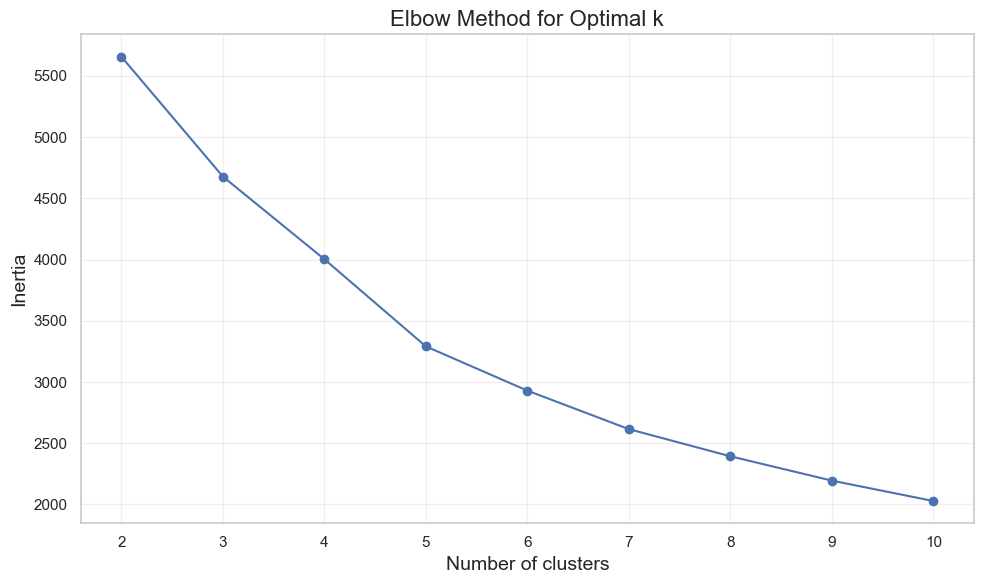

Selected number of clusters: 4

Cluster sizes:
cluster
0    160
1    370
2    413
3     57
Name: count, dtype: int64


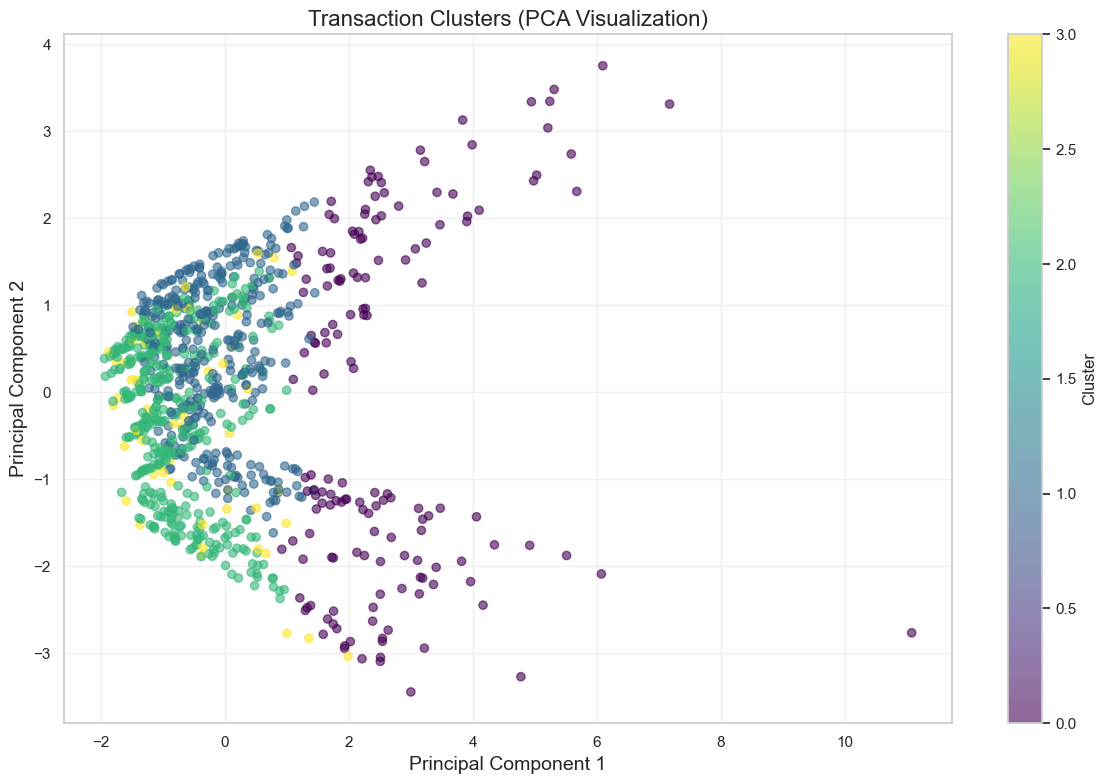


Cluster profiles (mean values for key features):
         transaction_amount  amount_hour  amount_weekend  hour_sin  hour_cos  \
cluster                                                                        
0                188.071863  2722.108743       73.636822 -0.250924 -0.044521   
1                 45.939516   761.679378        6.313423 -0.594424 -0.180483   
2                 53.309965   246.641820       10.650812  0.636644  0.170976   
3                 61.210046   558.751576       19.515895  0.057548  0.013152   

          day_sin  is_high_risk_country  
cluster                                  
0       -0.305497                   0.0  
1        0.121103                   0.0  
2        0.019023                   0.0  
3        0.043328                   1.0  

Risk score by cluster:
cluster
0    0.112500
1    0.118919
2    0.125908
3    1.000000
Name: label_code, dtype: float64


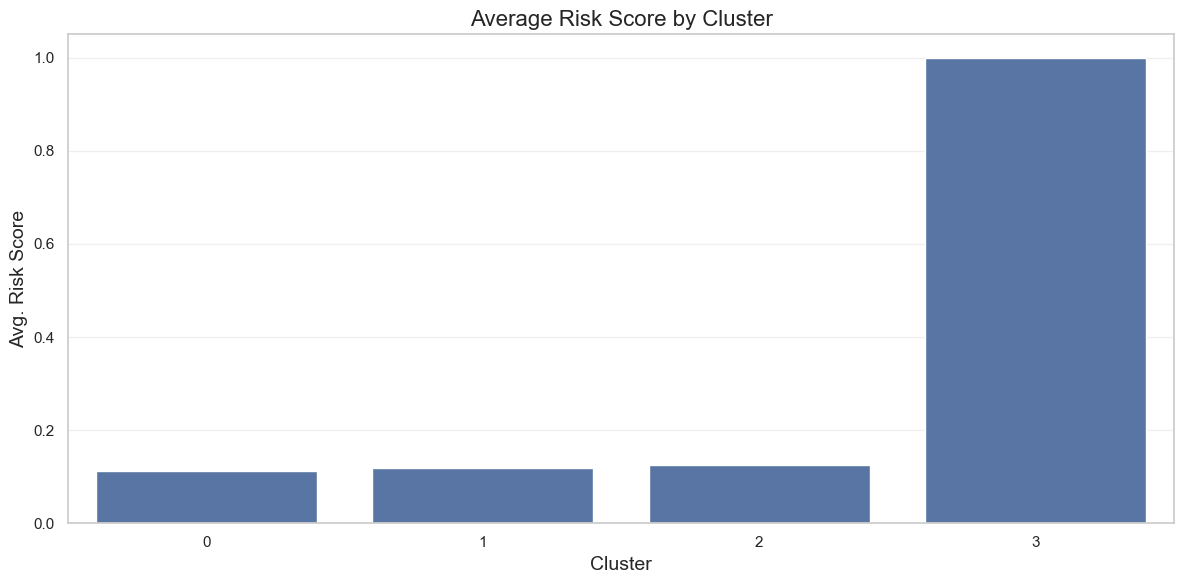


Cluster Descriptions:
Cluster 0: low-frequency high-value low-risk users
Cluster 1: low-frequency low-value low-risk users
Cluster 2: low-frequency low-value low-risk users
Cluster 3: high-frequency medium-value high-risk users

Business Implications and Use Cases for Each Cluster:

Cluster 0 (low-frequency high-value low-risk users):
- Offer streamlined checkout experience with fewer verification steps
- Potential candidates for loyalty programs or premium service offerings
- Use as control group for fraud detection benchmarking
- Design re-engagement campaigns to increase activity
- Assess if irregular patterns represent risk or opportunity
- Provide premium customer service and attention
- Create specialized retention strategies
- Balance fraud prevention with positive user experience

Cluster 1 (low-frequency low-value low-risk users):
- Offer streamlined checkout experience with fewer verification steps
- Potential candidates for loyalty programs or premium service offerings
- Us

In [100]:
# Prepare data for clustering
# Using a subset of features that might be relevant for behavioral segmentation
def prepare_data_for_clustering(df):
    """Prepare data for clustering by selecting and normalizing relevant features"""
    # Select relevant features for user/transaction segmentation
    clustering_features = []
    
    # Transaction amount features
    amount_cols = [col for col in df.columns if 'amount' in col.lower()]
    clustering_features.extend(amount_cols[:3])  # Limit to first 3 amount-related features
    
    # Temporal features - ensure they are numeric
    time_cols = [col for col in df.columns if ('time' in col.lower() or 'hour' in col.lower() or 'day' in col.lower()) 
                and df[col].dtype in ['int64', 'float64']]
    clustering_features.extend(time_cols[:3])  # Limit to first 3 time-related features
    
    # Frequency features
    freq_cols = [col for col in df.columns if 'count' in col.lower() or 'frequency' in col.lower()]
    clustering_features.extend(freq_cols[:2])  # Limit to first 2 frequency-related features
    
    # If we don't have enough features, add some numerical columns
    if len(clustering_features) < 5:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns[:5]
        clustering_features.extend([col for col in numerical_cols if col not in clustering_features])
    
    # Ensure we have features to work with and they exist in the dataframe
    clustering_features = [col for col in clustering_features if col in df.columns]
    
    if not clustering_features:
        # If no features were found, use first 5 numerical columns as fallback
        clustering_features = df.select_dtypes(include=['int64', 'float64']).columns[:5].tolist()
    
    # Final check to ensure all selected features are numeric
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    clustering_features = [col for col in clustering_features if col in numeric_df.columns]
    
    print(f"Selected features for clustering: {clustering_features}")
    
    # Check if we have any features left
    if not clustering_features:
        raise ValueError("No numeric features available for clustering")
    
    # Select and normalize data
    X_cluster = df[clustering_features].copy()
    
    # Double check for non-numeric data
    for col in X_cluster.columns:
        if not pd.api.types.is_numeric_dtype(X_cluster[col]):
            print(f"Converting non-numeric column {col} to numeric")
            X_cluster[col] = pd.to_numeric(X_cluster[col], errors='coerce')
            # Fill any NaN values created by the conversion
            X_cluster[col].fillna(X_cluster[col].mean(), inplace=True)
    
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    return X_scaled, clustering_features

# Prepare data for clustering
X_cluster, cluster_features = prepare_data_for_clustering(df_featured)
print(f"Features used for clustering: {cluster_features}")

# Perform K-Means clustering
# First, determine optimal number of clusters using elbow method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on the elbow curve, choose optimal number of clusters
optimal_k = 4  # Adjust based on elbow curve
print(f"Selected number of clusters: {optimal_k}")

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# Add cluster labels to original data
df_featured['cluster'] = cluster_labels

# Analyze clusters
# 1. Size of each cluster
cluster_sizes = df_featured['cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

# 2. Visualize clusters using dimensionality reduction
# Use PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Transaction Clusters (PCA Visualization)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Analyze characteristics of each cluster
cluster_profile = df_featured.groupby('cluster')[cluster_features].mean()
print("\nCluster profiles (mean values for key features):")
print(cluster_profile)

# 4. Check fraud distribution by cluster
if 'label_code' in df_featured.columns:
    fraud_by_cluster = df_featured.groupby('cluster')['label_code'].mean()
    print("\nRisk score by cluster:")
    print(fraud_by_cluster)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=fraud_by_cluster.index, y=fraud_by_cluster.values)
    plt.title('Average Risk Score by Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Avg. Risk Score', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Create interpretable cluster names based on characteristics like: High-frequency low-value users, Foreign frequent travelers, etc.
cluster_descriptions = {}

for cluster_id in range(optimal_k):
    cluster_data = df_featured[df_featured['cluster'] == cluster_id]
    
    # Analyze amount characteristics
    amount_col = next((col for col in cluster_features if 'amount' in col.lower()), None)
    if amount_col:
        cluster_amount = cluster_profile.loc[cluster_id, amount_col]
        overall_amount = df_featured[amount_col].mean()
        amount_desc = "high-value" if cluster_amount > overall_amount * 1.2 else "low-value" if cluster_amount < overall_amount * 0.8 else "medium-value"
    else:
        amount_desc = ""
    
    # Analyze frequency characteristics
    freq_col = next((col for col in cluster_features if 'count' in col.lower() or 'frequency' in col.lower()), None)
    if freq_col:
        cluster_freq = cluster_profile.loc[cluster_id, freq_col]
        overall_freq = df_featured[freq_col].mean()
        freq_desc = "high-frequency" if cluster_freq > overall_freq * 1.2 else "low-frequency" if cluster_freq < overall_freq * 0.8 else "medium-frequency"
    else:
        freq_desc = ""
    
    # Analyze risk level
    if 'label_code' in df_featured.columns:
        cluster_risk = fraud_by_cluster[cluster_id]
        overall_risk = df_featured['label_code'].mean()
        risk_desc = "high-risk" if cluster_risk > overall_risk * 1.2 else "low-risk" if cluster_risk < overall_risk * 0.8 else "medium-risk"
    else:
        risk_desc = ""
    
    # Combine descriptions
    descriptions = [d for d in [freq_desc, amount_desc, risk_desc] if d]
    if descriptions:
        cluster_descriptions[cluster_id] = " ".join(descriptions) + " users"
    else:
        cluster_descriptions[cluster_id] = f"Cluster {cluster_id}"

# Display cluster descriptions
print("\nCluster Descriptions:")
for cluster_id, description in cluster_descriptions.items():
    print(f"Cluster {cluster_id}: {description}")
    
# Business implications of each cluster
print("\nBusiness Implications and Use Cases for Each Cluster:")
for cluster_id, description in cluster_descriptions.items():
    print(f"\nCluster {cluster_id} ({description}):")
    
    if "high-risk" in description:
        print("- Apply stricter fraud controls and verification steps")
        print("- Flag for manual review by fraud analysts")
        print("- Implement additional authentication steps")
    
    if "low-risk" in description:
        print("- Offer streamlined checkout experience with fewer verification steps")
        print("- Potential candidates for loyalty programs or premium service offerings")
        print("- Use as control group for fraud detection benchmarking")
    
    if "high-frequency" in description:
        print("- Develop tailored engagement strategies for regular users")
        print("- Monitor for sudden changes in behavior patterns")
        print("- Consider for early access to new features or services")
    
    if "low-frequency" in description:
        print("- Design re-engagement campaigns to increase activity")
        print("- Assess if irregular patterns represent risk or opportunity")
    
    if "high-value" in description:
        print("- Provide premium customer service and attention")
        print("- Create specialized retention strategies")
        print("- Balance fraud prevention with positive user experience")
    
    if "low-value" in description:
        print("- Identify opportunities for upselling or increasing transaction value")
        print("- Optimize cost of serving these customers")
        print("- Consider batch processing for efficiency")

## 12. Model Serialization

Now that we've developed and evaluated our model, let's save it so it can be used in our API and Streamlit app.

In [106]:
# Save the best model to be used in the API and Streamlit app
import os
import pickle
import json

# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../utils', exist_ok=True)

# 1. Save the complete pipeline (preprocessor + model)
model_filename = '../models/fraud_detection_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Complete model pipeline saved to {model_filename}")

# 2. Save model metadata for future reference
model_metadata = {
    'model_type': best_model_name,
    'features': feature_cols,
    'categorical_features': list(X_test.select_dtypes(include=['object']).columns),
    'numerical_features': list(X_test.select_dtypes(include=['int64', 'float64']).columns),
    'target_variable': 'label_code',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'model_version': '1.0',
    'model_metrics': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1_score']),
        'roc_auc': float(results[best_model_name]['roc_auc']),
    }
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("Model metadata saved to models/model_metadata.json")

# 3. Save feature engineering functions for preprocessing new data

feature_code = textwrap.dedent("""\
    \"\"\" 
    Feature Engineering Module for Fraud Detection System

    This module contains functions to engineer features for the fraud detection model.
    This implementation is aligned with the trained model's expected features.
    \"\"\"

    import pandas as pd
    import numpy as np
    from datetime import datetime
    from typing import Dict, List, Optional, Union

    def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
        \"\"\"
        Engineer features for fraud detection exactly matching the trained model expectations.
        
        The model expects these specific features:
        - amount_foreign
        - is_foreign_transaction
        - is_high_risk_country
        - previous_fraud_flag
        - risk_score
        - rolling_std_amount
        - rolling_mean_amount
        - hours_since_last_tx
        - amount_hour
        
        Args:
            df (pd.DataFrame): Input dataframe with raw transaction data
            
        Returns:
            pd.DataFrame: DataFrame with engineered features
        \"\"\"
        # Create a copy to avoid modifying the original
        result_df = df.copy()
        
        # Ensure all required columns exist (even if empty)
        required_columns = [
            'is_foreign_transaction', 
            'is_high_risk_country', 
            'previous_fraud_flag',
            'risk_score'
        ]
        
        for col in required_columns:
            if col not in result_df.columns:
                result_df[col] = 0
        
        # Convert categorical risk indicators to numeric if they're strings
        for col in ['is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag']:
            if col in result_df.columns and result_df[col].dtype == 'object':
                result_df[col] = (
                    result_df[col]
                    .map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, True: 1, False: 0})
                    .fillna(0)
                    .astype(int)
                )
        
        # Process transaction time if available
        if 'transaction_time' in result_df.columns:
            if not pd.api.types.is_datetime64_any_dtype(result_df['transaction_time']):
                result_df['transaction_time'] = pd.to_datetime(
                    result_df['transaction_time'], errors='coerce'
                )
            result_df['hour'] = result_df['transaction_time'].dt.hour
        else:
            result_df['hour'] = 12  # Default to noon
        
        # Standardize column names
        if 'transaction_amount' in result_df.columns and 'amount' not in result_df.columns:
            result_df['amount'] = result_df['transaction_amount']
        elif 'amount' not in result_df.columns:
            result_df['amount'] = 0
        
        # Amount-based features
        result_df['amount_foreign'] = result_df['amount'] * result_df.get('is_foreign_transaction', 0)
        result_df['amount_hour']    = result_df['amount'] * result_df['hour']
        
        # Temporal user‐based features
        user_col = 'customer_id' if 'customer_id' in result_df.columns else 'user_id' if 'user_id' in result_df.columns else None
        if user_col and 'transaction_time' in result_df.columns:
            result_df = result_df.sort_values([user_col, 'transaction_time'])
            grouped = result_df.groupby(user_col)
            result_df['hours_since_last_tx'] = grouped['transaction_time'].diff().dt.total_seconds() / 3600
            result_df['rolling_mean_amount'] = grouped['amount'].transform(lambda x: x.rolling(5, min_periods=1).mean())
            result_df['rolling_std_amount']  = grouped['amount'].transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))
        else:
            result_df['hours_since_last_tx']  = 0
            result_df['rolling_mean_amount'] = result_df['amount']
            result_df['rolling_std_amount']  = 0
        
        # Default or compute risk_score if missing
        if 'risk_score' not in result_df.columns:
            factors = []
            if 'is_foreign_transaction' in result_df: factors.append(result_df['is_foreign_transaction'])
            if 'is_high_risk_country' in result_df: factors.append(result_df['is_high_risk_country'])
            if 'previous_fraud_flag' in result_df: factors.append(result_df['previous_fraud_flag'] * 2)
            result_df['risk_score'] = sum(factors) / len(factors) if factors else 0
        
        # Final cleanup
        result_df = result_df.fillna(0)
        required_features = [
            'amount_foreign',
            'is_foreign_transaction',
            'is_high_risk_country',
            'previous_fraud_flag',
            'risk_score',
            'rolling_std_amount',
            'rolling_mean_amount',
            'hours_since_last_tx',
            'amount_hour'
        ]
        return result_df[required_features].copy()
    """)

# write out the file
with open('../utils/feature_engineering.py', 'w') as f:
    f.write(feature_code)

print("Feature engineering utilities saved to utils/feature_engineering.py")

# 4. Save a sample input format for the API
# Extract a few rows of data for sample input
sample_input = X_test.iloc[:1].copy()
sample_input_json = sample_input.to_dict(orient='records')[0]

with open('../utils/sample_input.json', 'w') as f:
    json.dump(sample_input_json, f, indent=2)
print("Sample input format saved to utils/sample_input.json")

# 5. Optional: Save the optimal threshold if we determined one for binary classification
if 'optimal_threshold' in locals():
    model_metadata['optimal_threshold'] = float(optimal_threshold)
    with open('../models/model_metadata.json', 'w') as f:
        json.dump(model_metadata, f, indent=2)
    print(f"Updated model metadata with optimal threshold: {optimal_threshold:.2f}")

print("\nAll model artifacts have been successfully saved and are ready for deployment.")

Complete model pipeline saved to ../models/fraud_detection_model.pkl
Model metadata saved to models/model_metadata.json
Feature engineering utilities saved to utils/feature_engineering.py
Sample input format saved to utils/sample_input.json
Updated model metadata with optimal threshold: 0.10

All model artifacts have been successfully saved and are ready for deployment.


## 13. API Testing Section

Create a test to ensure the model can be properly loaded and used for predictions, simulating how the API would process requests.

In [108]:
# Test loading and using the saved model
def test_model_loading_and_prediction():
    """Test that we can load the model and make predictions with it"""
    print("Testing model loading and prediction functionality...")
    
    try:
        # Load the model
        loaded_model = joblib.load('../models/fraud_detection_model.pkl')
        print("✓ Model loaded successfully")
        
        # Load the metadata
        with open('../models/model_metadata.json', 'r') as f:
            metadata = json.load(f)
        print("✓ Metadata loaded successfully")
        
        # Get some test data
        test_input = X_test.iloc[:3]
        
        # Make predictions
        predictions = loaded_model.predict(test_input)
        pred_proba = loaded_model.predict_proba(test_input)
        
        print("✓ Successfully made predictions")
        print(f"Prediction shape: {predictions.shape}")
        
        # Compare with original model predictions
        original_preds = best_model.predict(test_input)
        assert np.array_equal(predictions, original_preds)
        print("✓ Predictions match original model")
        
        # Test with a single sample (API use case)
        single_input = test_input.iloc[0:1]
        single_pred = loaded_model.predict(single_input)
        single_proba = loaded_model.predict_proba(single_input)
        
        print("\nSample API prediction result:")
        print(f"Prediction: {single_pred[0]}")
        print(f"Probability: {single_proba[0]}")
        
        # If we have a binary classifier with an optimal threshold
        if 'optimal_threshold' in metadata:
            optimal_threshold = metadata['optimal_threshold']
            binary_pred = (single_proba[0][1] >= optimal_threshold).astype(int)
            print(f"Prediction with optimal threshold ({optimal_threshold:.2f}): {binary_pred}")
        
        return True
    except Exception as e:
        print(f"Error testing model: {e}")
        return False

# Run the test
test_success = test_model_loading_and_prediction()

if test_success:
    print("\nModel is ready for deployment")
else:
    print("\nPlease fix errors before proceeding with deployment.")

# Create a sample API prediction function
def simulate_api_prediction(input_data, model_path='../models/fraud_detection_model.pkl', metadata_path='../models/model_metadata.json'):
    """
    Simulate how the API would process a prediction request.
    
    Parameters:
    input_data (dict): Input data in the format expected by the API
    model_path (str): Path to the saved model
    metadata_path (str): Path to the model metadata
    
    Returns:
    dict: API response with prediction and explanation
    """
    try:
        # Load model and metadata
        model = joblib.load(model_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Convert input dict to DataFrame
        input_df = pd.DataFrame([input_data])
        
        # Make prediction
        pred_proba = model.predict_proba(input_df)[0]
        
        # Determine risk level
        risk_score = pred_proba[1]  # Probability of positive class
        
        if 'optimal_threshold' in metadata:
            optimal_threshold = metadata['optimal_threshold']
            is_fraudulent = risk_score >= optimal_threshold
        else:
            # Default threshold of 0.5
            is_fraudulent = risk_score >= 0.5
        
        # Create risk levels
        if risk_score < 0.3:
            risk_level = "Low Risk"
        elif risk_score < 0.7:
            risk_level = "Medium Risk"
        else:
            risk_level = "High Risk"
        
        # Create explanation
        explanation = {
            "risk_score": float(risk_score),
            "risk_level": risk_level,
            "is_fraudulent": bool(is_fraudulent),
            "confidence": float(max(pred_proba)),
            "model_version": metadata['model_version'],
            "timestamp": pd.Timestamp.now().isoformat()
        }
        
        return {
            "status": "success",
            "prediction": int(is_fraudulent),
            "probability": float(risk_score),
            "explanation": explanation
        }
    except Exception as e:
        return {
            "status": "error",
            "message": str(e)
        }

# Test the API prediction function with a sample
sample_input = X_test.iloc[0].to_dict()
api_response = simulate_api_prediction(sample_input)
print("\nSample API Response:")
print(json.dumps(api_response, indent=2))

Testing model loading and prediction functionality...
✓ Model loaded successfully
✓ Metadata loaded successfully
✓ Successfully made predictions
Prediction shape: (3,)
✓ Predictions match original model

Sample API prediction result:
Prediction: 1
Probability: [0.01786736 0.98213264]
Prediction with optimal threshold (0.10): 1

Model is ready for deployment

Sample API Response:
{
  "status": "success",
  "prediction": 1,
  "probability": 0.9821326354712627,
  "explanation": {
    "risk_score": 0.9821326354712627,
    "risk_level": "High Risk",
    "is_fraudulent": true,
    "confidence": 0.9821326354712627,
    "model_version": "1.0",
    "timestamp": "2025-08-06T15:40:53.241669"
  }
}


__________